In [1]:
import numpy
import sys 
import gym
import numpy as np
import pandas as pd
import warnings
import pickle
from joblib import dump, load
from random import randint
from gym import spaces
import ray
import time
import os
import datetime
import joblib
import datetime

In [2]:
from matplotlib import pyplot as plt

In [5]:
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

In [6]:
from ray.rllib import agents

In [7]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [10]:

ray.init(ignore_reinit_error=True, num_gpus= 1)

{'node_ip_address': '192.168.0.40',
 'raylet_ip_address': '192.168.0.40',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2023-02-02_00-31-39_675610_8425/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-02-02_00-31-39_675610_8425/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-02-02_00-31-39_675610_8425',
 'metrics_export_port': 59814,
 'gcs_address': '192.168.0.40:64020',
 'address': '192.168.0.40:64020',
 'node_id': '161c317f1a0b66189177c150eff63911fb9e2b2ce4309866526af41a'}

# Get Dataset

In [11]:
df_train = pd.read_feather('/raid/deallab/yechae/ECM/2023/data/ecm_input.ftr')
df_train = df_train.set_index('timestamp_min')
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

# Make Init Data

In [12]:
# 모델의 Timewindow별 학습하기 위한 데이터를 나눔
def makeData(df_s,Train_date):
    df_s = df_s.resample('10T').first()    
    df_test = df_s[(pd.to_datetime(df_s.index).date) == (Train_date)]
    
    return df_test

In [13]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
start_date = datetime.date(2019,10,16)
Train_date = start_date
print(start_date)
init_date_date = makeData(df_train, Train_date)

2019-10-16


In [14]:
init_date_date

f3_hum  f10_hum  f3_temp  f10_temp  exthum  enhum  temp  \
timestamp_min                                                                  
2019-10-16 00:00:00   44.57    41.92    22.75     23.47    64.7   70.4  35.7   
2019-10-16 00:10:00   44.57    41.92    22.75     23.47    65.0   70.5  35.7   
2019-10-16 00:20:00   44.57    41.92    22.75     23.47    65.6   70.5  35.5   
2019-10-16 00:30:00   44.57    41.92    22.75     23.47    66.3   70.6  35.5   
2019-10-16 00:40:00   44.57    41.92    22.75     23.47    66.7   70.6  35.3   
...                     ...      ...      ...       ...     ...    ...   ...   
2019-10-16 23:10:00   37.62    38.80    25.02     24.32    65.2   80.3  38.5   
2019-10-16 23:20:00   37.62    38.80    25.02     24.30    65.5   80.0  37.9   
2019-10-16 23:30:00   37.82    38.70    25.02     24.30    66.2   79.9  37.8   
2019-10-16 23:40:00   38.02    38.80    24.95     24.32    66.5   79.8  37.6   
2019-10-16 23:50:00   38.02    38.80    24.90     24.30    66.6   79.7  37.2   

                     entemp  extemp  F_SET_MODE_0  F_SET_MODE_1  F_SET_MODE_2  \
timestamp_min                                                                   
2019-10-16 00:00:00    18.9    19.3           1.0           0.0           0.0   
2019-10-16 00:10:00    18.7    19.3           1.0           0.0           0.0   
2019-10-16 00:20:00    18.7    19.1           1.0           0.0           0.0   
2019-10-16 00:30:00    18.7    18.9           1.0           0.0           0.0   
2019-10-16 00:40:00    18.7    18.7           1.0           0.0           0.0   
...                     ...     ...           ...           ...           ...   
2019-10-16 23:10:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:20:00    17.9    19.3           1.0           0.0           0.0   
2019-10-16 23:30:00    17.9    19.1           1.0           0.0           0.0   
2019-10-16 23:40:00    17.8    19.1           1.0           0.0           0.0   
2019-10-16 23:50:00    17.8    19.1           1.0           0.0           0.0   

                     F_SET_MODE_3  F_SET_MODE_4  F_SET_MODE_5  
timestamp_min                                                  
2019-10-16 00:00:00           0.0           0.0           0.0  
2019-10-16 00:10:00           0.0           0.0           0.0  
2019-10-16 00:20:00           0.0           0.0           0.0  
2019-10-16 00:30:00           0.0           0.0           0.0  
2019-10-16 00:40:00           0.0           0.0           0.0  
...                           ...           ...           ...  
2019-10-16 23:10:00           0.0           0.0           0.0  
2019-10-16 23:20:00           0.0           0.0           0.0  
2019-10-16 23:30:00           0.0           0.0           0.0  
2019-10-16 23:40:00           0.0           0.0           0.0  
2019-10-16 23:50:00           0.0           0.0           0.0  

[144 rows x 15 columns]

In [15]:
future_target = 10 # 10분 후 예측
past_history = 1 # input window size
Train_window_size = 1
Train_date = datetime.date(2019,9,20)
# model_name = 'gru_1layer'
# df_test_pre = makeData(df_train, Train_date )
# dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w30_{model_name}.h5'

In [16]:
# #학습된 모델호출
# #model = joblib.load(dl_path)
# model = tf.keras.models.load_model(dl_path)

# Forecasting Model

In [17]:
def Env_ML(model_path, cur_df, operation_condition, step_cnt, max_action, index, train_data):
    
    model = joblib.load(model_path)
    #model = tf.keras.models.load_model(dl_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1, len(input_feature)))

    enhum_value = train_data.iloc[index + step_cnt-1].values[5]
    entemp_value = train_data.iloc[index + step_cnt-1].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

In [18]:
def Env_DL(model_path, cur_df, operation_condition, step_cnt, max_action):
    model = tf.keras.models.load_model(model_path)
    action_arr = np.array([0,0,0,0,0,0])
    
    if (operation_condition == 0):
        action_arr[0] = 1
        cur_df = np.append(cur_df, action_arr)        

    elif (operation_condition == 1):
        action_arr[max_action] = 1
        cur_df = np.append(cur_df, action_arr)     

    else:
        print("Wrong Input...")
        print("curr_temp : ", Current_df, ", Action : ", Operation_Condition)
        return;
    
    # enhum : 5
    # entemp : 7
    # enhum, entemp는 실제 값 넣기 
    
    prediction = model.predict(cur_df.reshape(-1,1,len(input_feature)))

    enhum_value = df_test_pre.iloc[i + step_cnt].values[5]
    entemp_value = df_test_pre.iloc[i + step_cnt].values[7]
 
    prediction = np.insert(prediction[0], 5, enhum_value)
    prediction = np.insert(prediction, 7, entemp_value)

    return prediction

# ENV 

In [19]:
high = np.array([100000., 100000., 100000., 100000., 100000.,100000., 100000., 100000., 100000.])
low = np.array([-100000., -100000., -100000., -100000., -100000.,-100000., -100000., -100000., -100000.])

In [20]:
MAX_STEPS = 6

In [22]:
class ECM_Env_DL(gym.Env):
    def __init__(self, env_config):
        self.init_data = df_test_pre
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = ""
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
    
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = df_test_pre
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_DL(self.model, self.ns, action, self.step_cnt, self.max_action, self.index)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
    
        action_reward = self.reward_al(before_status[0], action)


        temp_violation_reward = round(temp_violation, 2)
        power_reward = round(0.001 * next_power_consumption, 2)
        #reward = (action_reward * 2)  - temp_violation_reward - power_reward 
        reward = (action_reward * 4)  - temp_violation_reward - power_reward 
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
    def temp_violation_func(self, f3_temp, temp_violation):
        violation = 0
        if f3_temp < self.min_temp:
            violation = violation - (temp_violation * 1)
            #violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = violation - (temp_violation * 10)
            #violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = violation + (temp_violation * 10)
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [23]:
class ECM_Env_ML(gym.Env):
    def __init__(self, env_config):
        self.init_data = env_config['init_data']
        self.model_path = ""
        self.index = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low =low,high=high)
        self.min_temp = env_config['min_temp']
        self.max_temp = env_config['max_temp']
        self.method_name = env_config['method_name']
        self.model = env_config['model']
        self.max_action = env_config['max_action']
        self.train_data = init_date_date
        self.ns = self.reset()
        self.done = False
        self.step_cnt = 0
        self.rewards = []
        self.norm_rewards = []
        
    def reset(self):
        self.step_cnt = 0
        self.done = False
        all_data = self.init_data
        index = randint(0,len(all_data)-7)
        self.index = index
        real_value = all_data.iloc[index].values[:9]
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    
#     def setModelPath(self, model_path):
#         self.model_path = model_path
#         print(self.model_path)
#     def getModelPath(self):
#         return self.model_path
#     def setInitData(self, init_data):
#         self.init_data = init_data
#         print("Reset data date:", self.init_data.iloc[0].name)
#     def getInitData(self):
#         return self.init_data
    
    def step(self, action):
        #print(self.step_cnt)
        self.step_cnt = self.step_cnt + 1
        before_status = self.ns
        
       # method = eval(self.method_name)

        # call it like a regular function later
        #args = [self.model, self.ns, action, self.step_cnt, self.max_action]
        #kwargs = {}
        #next_state = method(*args, **kwargs)
        next_state = Env_ML(self.model, self.ns, action, self.step_cnt, self.max_action, self.index, self.init_data)
        
        
        # model, cur_df, operation_condition, step_cnt, max_action
        #next_state = Env(self.model, self.ns, action, self.step_cnt, self.max_action)
        next_temp = round(next_state[2], 2)
        self.ns = next_state
        
        next_power_consumption = self.power_consumption(action)
        
        
        #temp_violation = np.abs(next_temp - self.max_temp) + np.abs(self.min_temp - next_temp)
        temp_violation = self.temp_violation_func(next_temp)
    
        action_reward = self.reward_al(before_status[2], action)


        temp_violation_reward = round(temp_violation * 0.001 , 2)
        power_reward = np.abs(round(0.0001 * next_power_consumption, 2))
        #reward = (action_reward * 2.5)  - temp_violation_reward - power_reward 
        reward = (action_reward * 2.5) - temp_violation_reward - power_reward
        #reward = (action_reward * 5)  - temp_violation_reward - power_reward, power reward = 0.1
        #reward = action_reward * 2
        #reward = -temp_violation_reward - power_reward
        reward = round(reward, 2)
        
        if self.step_cnt >= MAX_STEPS:
            self.done = True     
        return next_state, reward, self.done, {}
     
    def result_step(self, action):
        before_status = self.ns
        next_env = Env([self.ns], action)
        next_step = round(next_env[2], 2)
        reward = 0
        self.ns = next_env

        next_env[0][0] = next_step
        return next_env, reward, next_step, {}
    
    def power_consumption(self, action):
        return 0 if action==0 else 200
        
#     def temp_violation_func(self, f3_temp, temp_violation):
#         violation = 0
#         if f3_temp < self.min_temp:
#             violation = violation - (temp_violation * 1)
#             #violation = np.abs(f3_temp - self.min_temp)
#         elif f3_temp > self.max_temp:
#             violation = violation - (temp_violation * 10)
#             #violation = np.abs(f3_temp - self.max_temp)
#         elif self.min_temp <= f3_temp <= self.max_temp:
#             violation = violation + (temp_violation * 10)
        
#         return violation
    def temp_violation_func(self, f3_temp):
        vio_reward = 0
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            vio_reward = 0
        if f3_temp > self.max_temp:
            vio_reward = np.abs(f3_temp - self.max_temp)
        if f3_temp < self.min_temp:
            #vio_reward = np.abs(f3_temp - self.min_temp)
            vio_reward = 0.2
            
        return vio_reward
        
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
            reward = reward 
        if f3_temp >= self.max_temp and action == 0:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward  
    
#     def reward_al(self, f3_temp, action):
#         reward = 0
#         if f3_temp >= self.max_temp and action == 1:
#             reward = reward + 100
#         if f3_temp >= self.max_temp and action == 0:
#             reward = reward -100
#         if f3_temp <= self.min_temp and action == 1:
#             reward = reward - 100
#         if f3_temp <= self.min_temp and action == 0:
#             reward = reward + 100
#         if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
#             if action == 0:
#                 reward = reward + 100
#             if action == 1:                
#                 #random_action = random.randint(0,1)
#                 reward = reward + 10
#                 #reward = reward + random_action
                
#         return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [24]:
# env_config = {'max_temp': 27, 'min_temp' : 21}
# env = ECM_Env(env_config)

In [28]:
# for i in range(5):
#     a, b, c, d = env.step(0)
#     print(a)

In [29]:

import tempfile
from ray.tune.logger import UnifiedLogger
def custom_log_creator(custom_path, custom_str):
    
    timestr = datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}".format(custom_str, timestr)
    def logger_creator(config):
    
        if not os.path.exists(custom_path):
            os.makedirs(custom_path)
        logdir = tempfile.mkdtemp(prefix=logdir_prefix, dir=custom_path)
        return UnifiedLogger(config, logdir, loggers=None)

    return logger_creator


In [30]:
def getMaxAction(df_test_pre):
    action_list = []
    action_list.append(df_test_pre.F_SET_MODE_0.sum())
    action_list.append(df_test_pre.F_SET_MODE_1.sum())
    action_list.append(df_test_pre.F_SET_MODE_2.sum())
    action_list.append(df_test_pre.F_SET_MODE_3.sum())
    action_list.append(df_test_pre.F_SET_MODE_4.sum())
    action_list.append(df_test_pre.F_SET_MODE_5.sum())
    #print("{} - ACTION 0 : {}, 1 : {}, 2: {}, 3: {}, 4: {}, 5: {}".format(Train_date, df_test_pre.F_SET_MODE_0.sum(),df_test_pre.F_SET_MODE_1.sum(),df_test_pre.F_SET_MODE_2.sum(),df_test_pre.F_SET_MODE_3.sum(),df_test_pre.F_SET_MODE_4.sum(),df_test_pre.F_SET_MODE_5.sum()))
    #print(action_list.index(max(action_list)))
    return action_list.index(max(action_list))

# GET Best Forecasting Model List

In [31]:
best_forecastmodel = pd.read_csv("/raid/deallab/yechae/ECM/2023/data/linear_regressor_best_t3_rmse.csv")
best_forecastmodel = best_forecastmodel.set_index(best_forecastmodel.date)
best_forecastmodel = best_forecastmodel.drop('date', axis=1)
ml_models = ['extra_trees_regressor', 'xgb_regressor','linear_svr', 'xgbrf_regressor', 'linear_tree_regressor', 'linear_regression']
dl_models = ['gru_1layer',  'simpleRNN']

In [32]:
best_forecastmodel

model  window_size        t3_mae       t3_rmse  \
date                                                                     
2019-08-23  linear_regression            1  1.471099e-01  3.714375e-01   
2019-08-24  linear_regression            1  2.861478e-01  4.111759e-01   
2019-08-25  linear_regression            1  1.154393e-01  1.370982e-01   
2019-08-26  linear_regression            1  2.996205e-15  3.262615e-15   
2019-08-27  linear_regression            1  9.750167e-01  1.416785e+00   
...                       ...          ...           ...           ...   
2019-10-20  linear_regression            1  4.016957e-02  5.115313e-02   
2019-10-21  linear_regression           14  3.220961e-02  5.069454e-02   
2019-10-22  linear_regression            7  2.688419e-02  4.725529e-02   
2019-10-23  linear_regression           30  5.696565e-02  1.403227e-01   
2019-10-24  linear_regression            7  5.084847e-02  7.282941e-02   

               t3_mape             1         [         2         3         4  
date                                                                          
2019-08-23   93.930399  5.974359e-03  1.590579  1.889319 -1.462644  0.028358  
2019-08-24   89.471188  1.311018e-02  0.401321  0.548269  0.709518  0.007762  
2019-08-25  -15.311966  5.458642e-03  0.143140  0.173085 -0.003137  0.002751  
2019-08-26 -438.392857  1.422024e-16  0.000000  0.000000  1.000000  0.000000  
2019-08-27   14.785691  4.164219e-02  0.856755  1.344554  0.000000  0.016476  
...                ...           ...       ...       ...       ...       ...  
2019-10-20   91.599138  1.670757e-03  0.284817  0.489013  0.955812  0.007659  
2019-10-21   82.190496  1.337197e-03  0.312730  0.718734  0.921034  0.008462  
2019-10-22   86.933115  1.143585e-03  0.257110  0.404504  0.877164  0.007026  
2019-10-23   79.127448  2.395269e-03  0.324199  0.663960  0.745473  0.008840  
2019-10-24   94.966786  2.167679e-03  0.270108  0.356713  0.729212  0.007396  

[63 rows x 10 columns]

In [33]:
  
# for i in range(54):
#     # 1. dataset 만들기
#     #  method_name, model, action, max_action
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = train_model_data(df_train, Train_window_size, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'

#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         model = joblib.load(path)
#         method_name = "Env_ML"
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         model = tf.keras.models.load_model(dl_path)
#         method_name = "Env_DL"
#     max_action = getMaxAction(df_test_pre)
    
#     # ENV 세팅
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : model, 'max_action' : max_action}
#     env = ECM_Env(env_config)
    
    
    
    
#     Train_date = Train_date+datetime.timedelta(days=1)
    
    

In [34]:
# Train_date = datetime.date(2019,9,22)
# # init 
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# if model_name in ml_models:
#     path = ml_path
#     print("ML : ", model_name)
#     #model = joblib.load(path)
#     method_name = "Env_ML"
# else:
#     path = dl_path
#     print("DL : ", model_name)
#     #model = tf.keras.models.load_model(dl_path)
#     method_name = "Env_DL"
# print(path)
# max_action = getMaxAction(df_test_pre)

# # ENV 세팅
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
# env = ECM_Env_ML(env_config)

# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 1500
# config_dqn["timesteps_per_iteration"] = 144
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 144
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# print(save_path)
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

In [35]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
#end_date = datetime.date(2019,10,24)
#daterange = pd.date_range(Train_date, end_date)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date)
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.window_size.values[0]
model_name = cur_model.model.values[0]

#dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
print(path)


max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': "ML", 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = False
config_dqn["double_q"] = False

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN-linear-basic-7'))

2023-02-01 21:28:25,808	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-01 21:28:25,811	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-01 21:28:25,812	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-01 21:28:25,813	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
Reset data f3_temp : 27.3
/raid/deallab/yechae/ECM/2023/result/2019-08-23/
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37


2023-02-01 21:28:29,905	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-01 21:28:29,906	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


In [36]:
s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
train_dqn_episode = 100
reward_dqn_list = pd.DataFrame(columns = ['mean'])
# === Train === 
start = time.time()
start_after_for = time.time()
print(train_dqn_episode)
for i in range(train_dqn_episode):
    print("start_after_for : ", time.time() - start_after_for )
    start_episode = time.time()
    result = trainer_dqn.train()
    print(s.format(
        i + 1,
        result["episode_reward_min"],
        result["episode_reward_mean"],
        result["episode_reward_max"],
        result["episode_len_mean"]
       ))
    reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
    if i % 100 == 0:
        checkpoint = trainer_dqn.save()
        print("checkpoint saved at", checkpoint)
    print("Elapsed time one episode : ", time.time() - start_episode)
    start_after_for = time.time()
print("Elapsed time : ", time.time() - start)
checkpoint = trainer_dqn.save()

print("checkpoint saved at", checkpoint)
print(trainer_dqn)


#Train_date = Train_date+datetime.timedelta(days=1)

100
start_after_for :  0.0003159046173095703
Reset data f3_temp : 24.3
Reset data f3_temp : 24.3
Reset data f3_temp : 24.47
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
(RolloutWorker pid=848) Reset data f3_temp : 24.3
(RolloutWorker pid=848) Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 23.37


(RolloutWorker pid=848) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=848)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.25
Reset data f3_temp : 24.17
Reset data f3_temp : 24.25
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3


2023-02-01 21:28:33,458	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min : -10.02/ mean :  -0.94/ max :  14.88/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-08-23/RL_ECM_DQN-linear-basic-7_2023-02-01_21-28-259zb8gund/checkpoint_000001/checkpoint-1
Elapsed time one episode :  1.6872446537017822
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 23.25
Reset data f3_temp : 24.37
Reset data f3_temp : 24.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
  2 reward min : -10.02/ mean :  -1.78/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9545512199401855
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 24.45
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 23.65
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
  3 reward

Reset data f3_temp : 24.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 23.97
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.45
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 23.85
 20 reward min : -10.02/ mean :   1.33/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0446577072143555
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 23.85
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 23.37
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
 21 reward min : -10.02/ mean :   1.73/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0610582828521729
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 24.25
Reset data f3_temp : 27.3
Re

Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.2
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
 38 reward min : -10.02/ mean :   3.08/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0247201919555664
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.37
Reset data f3_temp : 24.2
Reset data f3_temp : 24.17
Reset data f3_temp : 23.85
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.47
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
 39 reward min : -10.02/ mean :   2.98/ max :  14.88/ len   6.00
Elapsed time one episode :  1.037548542022705
start_after_for :  9.5367431640625e-07
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data 

Reset data f3_temp : 23.65
Reset data f3_temp : 24.3
Reset data f3_temp : 23.55
 57 reward min : -10.02/ mean :   4.67/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0467631816864014
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
 58 reward min : -10.02/ mean :   4.52/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0094609260559082
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 23.27
Reset data f3_temp : 23.55
Reset data f3_temp : 24.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
 59 reward min : -10.02/ mean :   4.47/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0391786098480225
start_after_for :  1.

 77 reward min : -10.02/ mean :   7.01/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0542645454406738
start_after_for :  2.1457672119140625e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.47
Reset data f3_temp : 24.47
Reset data f3_temp : 24.37
Reset data f3_temp : 24.25
Reset data f3_temp : 27.3
Reset data f3_temp : 23.27
 78 reward min : -10.02/ mean :   6.91/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0289359092712402
start_after_for :  1.430511474609375e-06
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 23.25
Reset data f3_temp : 27.3
Reset data f3_temp : 23.85
Reset data f3_temp : 27.3
Reset data f3_temp : 27.3
 79 reward min : -10.02/ mean :   6.86/ max :  14.88/ len   6.00
Elapsed time one episode :  1.14935827255249

Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.47
Reset data f3_temp : 23.77
Reset data f3_temp : 24.25
Reset data f3_temp : 24.17
Reset data f3_temp : 23.37
Reset data f3_temp : 24.07
 96 reward min :  -5.04/ mean :   8.21/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0119357109069824
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 27.3
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
Reset data f3_temp : 27.3
Reset data f3_temp : 24.17
Reset data f3_temp : 23.77
Reset data f3_temp : 24.37
Reset data f3_temp : 24.47
Reset data f3_temp : 24.17
Reset data f3_temp : 24.17
Reset data f3_temp : 24.37
Reset data f3_temp : 24.17
 97 reward min :  -5.04/ mean :   8.16/ max :  14.88/ len   6.00
Elapsed time one episode :  1.008326768875122
start_after_for :  1.1920928955078125e-06
Reset data f3_temp : 23.55
Reset data f3_temp : 24.3
Reset data f3_temp : 27.3


In [35]:
class test_env():
    def __init__(self):
        self.min_temp = 21
        self.max_temp = 27
        self.step_cnt = 0 
        self.init_data = pd.DataFrame()
        
    def reset(self, init_data):
        self.step_cnt = 0
        self.done = False
        all_data = init_data
        self.init_data = init_data
        #index = randint(0,len(all_data)-1) 
        real_value = all_data.iloc[0].values[:9]
        # df_pre.iloc[0][output_feature].values
        print("Reset data f3_temp : {}".format(real_value[2]))
        #print(real_value)
        return real_value
    
    def step(self,model_path, cur_df, action, max_action):
        self.step_cnt = self.step_cnt + 1
        
        
        # get the function by name
        #method_name = 'Env_ML'
#         method = eval(method_name)

#         # call it like a regular function later
#         args = [model, [cur_df], action, self.step_cnt, max_action]
#         kwargs = {}
        #next_env = method(*args, **kwargs)
        #next_env = Env_DL(model, [cur_df], action, self.step_cnt)
        next_env = Env_ML(model_path, cur_df, action, self.step_cnt, max_action, 0, self.init_data)
        next_step = round(next_env[2], 2)
        #next_hum = round(next_env[0][1], 2)
        
        #temp = np.abs(max(next_step - self.max_setpoint, 0)) + np.abs(max(self.min_setpoint - next_step, 0))
        temp = np.abs(next_step - self.max_temp) + np.abs(self.min_temp - next_step)
        reward = self.reward_al(cur_df[0], action) - 0.1 *  temp
        
        #next_env = next_step
        return next_env, reward, next_env, {}
    
    def temp_violation_func(self, f3_temp):
        # 평균 온도 확인 
        violation = 0
        if f3_temp < self.min_temp:
            violation = np.abs(f3_temp - self.min_temp)
        elif f3_temp > self.max_temp:
            violation = np.abs(f3_temp - self.max_temp)
        elif self.min_temp <= f3_temp <= self.max_temp:
            violation = 0
        
        return violation
    
    def reward_al(self, f3_temp, action):
        reward = 0
        if f3_temp >= self.max_temp and action == 1:
            reward = reward + 1
        if f3_temp >= self.max_temp and action == 0:
            reward = reward -1
        if f3_temp <= self.min_temp and action == 1:
            reward = reward - 1
        if f3_temp <= self.min_temp and action == 0:
            reward = reward + 1
        if f3_temp <= self.max_temp and f3_temp >= self.min_temp:
            if action == 0:
                reward = reward + 1
            if action == 1:                
                #random_action = random.randint(0,1)
                reward = reward + 0
                #reward = reward + random_action
                
        return reward   
    
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def close (self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass
        

In [42]:
from matplotlib import gridspec

def result_graph2(real_df, next_df, filename, actions):

    plt.clf()
    fig = plt.figure(figsize=(16,15))
    fig.set_facecolor('white')
    
    
#     plt.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
#     plt.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
   
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[2,1,1])
    
    ax1 = fig.add_subplot(spec[0])
    plt.ylim([18, 34])

    ax1.set_xticks([])
    lns1 = ax1.plot(next_df.f3_temp, color ="red",alpha=0.8, label="Predicted Temperature (simulation)", linewidth= 5.0) # linewidth=5.0
    lns2 = ax1.plot(real_df.temp, color='blue', alpha=0.8,label="Past Temperature (actual)", linewidth= 5.0) # linewidth=5.0
    min_setpoint = np.full(144, 21)
    max_setpoint= np.full(144, 27)
    lns3 = ax1.plot(next_df.index, min_setpoint, '--', label="The Minimum Set Point", alpha=0.4, linewidth=2.0, color='black')
    lns4 = ax1.plot(next_df.index,max_setpoint,'--' , label="The Maximum Set Point", alpha=0.4, linewidth=2.0, color='black')
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=9, ncol=2, fontsize=22)
    
    ax2 = fig.add_subplot(spec[1])
    plt.text(45, 2.3, "Expected Action (simulation)", fontsize=20)
    plt.ylim([0, 2])

    ax2.set_xticks([])
    plt.yticks([0,2], ['OFF', 'ON'])
    lns5 = ax2.plot(actions, drawstyle='steps', color = '#fa5ab5', label='Expected Action (simulation)')# linewidth =5
    
    ax3 = fig.add_subplot(spec[2])
    plt.text(45, 2.3, "Past Action (actual)", fontsize=20)
    plt.ylim([0, 2])
    plt.xticks(np.arange(0,143, step = 20))

    plt.yticks([0,2], ['OFF', 'ON'])
    lns6 = ax3.plot(real_df.action.values * 1,  color = "#ffc14f", drawstyle='steps',label="Past Action (actual)")

    

    ax1.set_ylabel("Temperature")

    ax2.set_ylabel("HVAC Status")
    ax3.set_xlabel('Time(minutes)')
    ax3.set_ylabel("HVAC Status")
    



    plt.rc('font', size=30)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기

    plt.rc('figure', titlesize=30) # figure title 폰트 크기
    image_path = f'/raid/deallab/yechae/ECM/2023/result/FinalResult2/{filename}-DQN.png'
    plt.savefig(image_path)
    plt.show()

In [37]:
test_env = test_env()
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

In [38]:
def result_base_RL(datas, name, model_path, max_action, DQN):
    i = 0
    before_action = 0
    after_action = 0
    before_mean = 0
    after_mean = 0
    real_avg_arr = []
    predict_avg_arr = []
    result_df = pd.DataFrame(columns=['date', 'actual_temp', 'predict_temp', 'power_reduction'])
    #P, I, D = 1e-10, 0, 0
    max_action_str = f'F_SET_MODE_{max_action}'
    print(max_action_str)
    
    for data in datas:
        #print(real_value)
        days = 1
        gamma = 0.98
        lr = 1e-4 * 5
        
        
        real_value = data.iloc[0].values

        init_state = test_env.reset(data)
    
        observation = init_state
        next_df = pd.DataFrame()
        actions = []
        
        for times in range(144):
            next_df = next_df.append(pd.Series(observation), ignore_index=True)
            action = DQN.compute_action(observation)
            #action = train_over_dqn.compute_action(observation)
            actions.append(action)
            
            #observation, reward, done, info = test_env.step(cur_df=observation, action=action)
            # model_path, cur_df, action, max_action
            observation, reward, done, info = test_env.step(model_path, cur_df=observation, action=action, max_action=max_action)
            #print(observation)
            #print("Action : {}, observation : {}".format(action, observation))
            #next_df = next_df.append(pd.Series(observation), ignore_index=True)
        
        next_df.columns = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp']
        #next_df['outstatus_0x0008'] = next_df['outstatus_0x0008'].apply(lambda x: 0 if x<=0.3 else 1 )
        before_action = before_action + sum(data[max_action_str])
        after_action = after_action + sum(actions)
        print(actions)
       
        #null_data_cnt = data.isnull().sum()[0]
        #null_data = data.dropna(axis=0)
        #before_action = before_action + null_data_cnt
        
        before_mean = before_mean + (sum(data['f3_temp']) / len(data))
        after_mean = after_mean + (sum(next_df['f3_temp']) / len(next_df))
        
        real_avg_temp = sum(data['f3_temp']) / len(data)
        predict_avg_temp = sum(next_df['f3_temp']) / len(next_df)
        #real_avg_arr.append(real_avg_temp)
        #predict_avg_arr.append(predict_avg_temp)
        day_real_action = sum(data[max_action_str])
        day_predict_action = sum(actions)
        day_reduction = ((day_real_action - day_predict_action) / day_real_action) * 100
        
        print(name, "실제 데이터 길이 : ", len(data)," : real action : " ,day_real_action , ", expected action : ", day_predict_action, "실제 평균 온도 : ", real_avg_temp, "학습 평균 온도 : ", predict_avg_temp)
        
        result_df = result_df.append(pd.Series([name, real_avg_temp, predict_avg_temp, day_reduction]), ignore_index=True)       
        
        real_df = pd.DataFrame()
        real_df['temp'] = data['f3_temp']
        real_df['hum'] = data['f3_hum']
        real_df['action'] = data[max_action_str]
        #next_df.to_csv("./thesis/result/basic_no_cluster/" + names[i] + ".csv")
        #print(real_df.iloc[0].values)
        #result_graph(real_df, next_df, names[i])
        next_df = next_df.set_index(real_df.index)
        result_graph2(real_df, next_df, name, actions)
        #         if(len(null_data) == len(next_df)):
#             check(data.f3_temp,next_df.f3_temp)
        i = i+1
    bm = before_mean / i
    am = after_mean / i
    print(before_action)
    print(after_action)
    print("===============================================================================================================================================================")
    print(i, "일 평균 절감율 : " , ((before_action - after_action) / before_action) * 100, "실제 평균 온도 : ", bm, "학습 평균 온도 : ", am, "오차율 : ", bm - am  )
    print("===============================================================================================================================================================")
    #check(real_avg_arr, predict_avg_arr)
    print("===============================================================================================================================================================")
    return real_df, next_df, actions, result_df
    #result_df.to_csv("./thesis/result/basic_no_cluster/result.csv")
        #if len(data) == len(next_df):
        #    check(data.f3_temp, next_df.f3_temp)
        #else:
         #   print("실제 데이터 부족 :", len(data) )


In [38]:
real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
new_df = pd.DataFrame()
new_df.index = real_df.index
new_df['real_temp'] = real_df['temp']
new_df['real_hum'] = real_df['hum']
new_df['real_action'] = real_df['action']
new_df['RL_temp'] = next_df['f3_temp']
new_df['RL_hum'] = next_df['f3_hum']
new_df['RL_action'] = actions
result_final_df = pd.DataFrame()

new_df.to_csv(f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DQN-pre-7.csv')
result_final_df = result_final_df.append(result_df)
result_final_df.to_csv("/raid/deallab/yechae/ECM/2023/result/DQN-result-pre-7.csv")

NameError: name 'path' is not defined

In [32]:
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))

# config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
# config_dqn["log_level"] = "WARN"
# config_dqn["env"] = select_env
# config_dqn["env_config"] = env_config
# config_dqn["evaluation_num_workers"] = 1
# config_dqn["train_batch_size"] = 256
# # config_dqn["model.fcnet_activation"] = 'relu'
# config_dqn["target_network_update_freq"] = 50
# config_dqn["learning_starts"] = 100
# config_dqn["timesteps_per_iteration"] = 6
# config_dqn["num_gpus_per_worker"] = 1
# config_dqn["model"]["custom_model"] = False
# #config_dqn["model"]["custom_model"] = "my_model"
# config_dqn["model"]["fcnet_hiddens"] = [256,256]
# config_dqn["model"]["fcnet_activation"] = "relu"
# config_dqn["n_step"] = 6
# config_dqn["dueling"] = False
# config_dqn["double_q"] = False

In [38]:
checkpoint

'/raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN_linear_regression_2023-01-27_11-26-30j73v05ac/checkpoint_000100/checkpoint-100'

In [ ]:
w21_linear_regression

In [39]:
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 100
config_dqn["timesteps_per_iteration"] = 6
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 6
config_dqn["dueling"] = False
config_dqn["double_q"] = False

2023-02-02 00:31:58,433	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-02-02 00:31:58,437	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:31:58,437	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-02-02 00:31:58,438	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


/raid/deallab/yechae/ECM/2023/result/2019-10-17/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-17-593ig24zeg/checkpoint_005400/checkpoint-5400
/raid/deallab/ecm/model_result/2019-10-18/20191018w30_linear_regression.joblib
Reset data f3_temp : 26.05
Reset data f3_temp : 24.5
Reset data f3_temp : 25.95


2023-02-02 00:32:02,574	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:32:02,574	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


2023-02-02 00:32:02,826	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-17/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-17-593ig24zeg/checkpoint_005400/checkpoint-5400
2023-02-02 00:32:02,827	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5400, '_timesteps_total': 1382400, '_time_total': 6751.593460321426, '_episodes_total': 28036}


100
start_after_for :  6.103515625e-05
Reset data f3_temp : 26.15
Reset data f3_temp : 24.42
Reset data f3_temp : 25.82
Reset data f3_temp : 25.95
Reset data f3_temp : 25.72
Reset data f3_temp : 26.05
Reset data f3_temp : 24.42
Reset data f3_temp : 25.95
Reset data f3_temp : 24.95
Reset data f3_temp : 25.62
Reset data f3_temp : 25.65
Reset data f3_temp : 25.72
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 26.15
Reset data f3_temp : 25.82
Reset data f3_temp : 24.22
Reset data f3_temp : 25.92


2023-02-02 00:32:04,205	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


  1 reward min : -15.00/ mean :  -6.77/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-18/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-31-582v0sr2mj/checkpoint_005401/checkpoint-5401
Elapsed time one episode :  1.4645874500274658
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 24.5
Reset data f3_temp : 24.32
Reset data f3_temp : 25.95
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 25.92
Reset data f3_temp : 25.95
Reset data f3_temp : 25.82
  2 reward min : -15.00/ mean :  -9.40/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9715452194213867
start_after_for :  1.6689300537109375e-06
(RolloutWorker pid=8755) Reset data f3_temp : 26.15
(RolloutWorker pid=8755) Reset data f3_temp : 24.42
Reset data f3_temp : 26.15


(RolloutWorker pid=8755) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8755)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 26.25
Reset data f3_temp : 25.3
Reset data f3_temp : 26.15
Reset data f3_temp : 25.92
Reset data f3_temp : 25.87
Reset data f3_temp : 24.22
Reset data f3_temp : 25.92
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
  3 reward min : -15.00/ mean : -10.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1030046939849854
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 25.42
Reset data f3_temp : 24.22
Reset data f3_temp : 25.3
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 25.65
Reset data f3_temp : 25.82
Reset data f3_temp : 25.12
Reset data f3_temp : 24.22
  4 reward min : -15.00/ mean : -11.60/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0097572803497314
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 25.82
Reset data f3_temp : 24.72
Reset data f3_temp : 

Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 24.22
Reset data f3_temp : 25.92
Reset data f3_temp : 25.3
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 24.95
Reset data f3_temp : 24.22
Reset data f3_temp : 25.12
Reset data f3_temp : 25.92
 21 reward min :  -5.04/ mean :  14.18/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0492005348205566
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 25.82
Reset data f3_temp : 24.95
Reset data f3_temp : 25.82
Reset data f3_temp : 26.25
Reset data f3_temp : 26.15
Reset data f3_temp : 24.55
Reset data f3_temp : 26.05
Reset data f3_temp : 25.65
Reset data f3_temp : 24.22
Reset data f3_temp : 26.05
 22 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0703644752502441
start_after_for :  5.4836273193359375e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 25.95
Reset data f3_temp

Reset data f3_temp : 24.42
Reset data f3_temp : 24.22
Reset data f3_temp : 25.82
Reset data f3_temp : 25.3
Reset data f3_temp : 24.95
Reset data f3_temp : 25.95
 39 reward min :   9.90/ mean :  14.68/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0228955745697021
start_after_for :  6.198883056640625e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 25.0
Reset data f3_temp : 25.92
Reset data f3_temp : 24.42
Reset data f3_temp : 25.82
Reset data f3_temp : 25.52
Reset data f3_temp : 25.35
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
 40 reward min :   9.90/ mean :  14.68/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0071628093719482
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 26.15
Reset data f3_temp : 26.25
Reset data f3_temp : 24.82
Reset data f3_temp : 24.22
Reset data f3_temp : 25.42
Reset data f3_temp : 25.92
Reset data f3_temp : 25.82
Reset data f3_temp : 25.95
Reset data f3_temp :

Reset data f3_temp : 24.22
Reset data f3_temp : 25.92
Reset data f3_temp : 24.72
 57 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0525214672088623
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 25.3
Reset data f3_temp : 25.82
Reset data f3_temp : 25.35
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 25.87
Reset data f3_temp : 25.82
Reset data f3_temp : 25.87
Reset data f3_temp : 26.15
Reset data f3_temp : 25.92
Reset data f3_temp : 25.65
 58 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0209944248199463
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 25.82
Reset data f3_temp : 24.32
Reset data f3_temp : 25.82
Reset data f3_temp : 25.72
Reset data f3_temp : 25.3
Reset data f3_temp : 25.3
Reset data f3_temp : 24.22
Reset data f3_temp : 24.85
Reset data f3_temp : 24.72
Reset data f3_temp : 24.32
Reset data f3_temp : 25.92
Reset data f3_temp : 

Reset data f3_temp : 24.22
Reset data f3_temp : 24.5
Reset data f3_temp : 24.35
Reset data f3_temp : 24.35
Reset data f3_temp : 24.22
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 25.12
Reset data f3_temp : 25.12
Reset data f3_temp : 25.62
 76 reward min :   9.90/ mean :  14.68/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1144986152648926
start_after_for :  8.58306884765625e-06
Reset data f3_temp : 25.0
Reset data f3_temp : 25.87
Reset data f3_temp : 26.15
Reset data f3_temp : 25.82
Reset data f3_temp : 26.25
Reset data f3_temp : 25.82
Reset data f3_temp : 25.82
Reset data f3_temp : 24.95
Reset data f3_temp : 25.87
Reset data f3_temp : 25.82
 77 reward min :   9.90/ mean :  14.63/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9876530170440674
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 24.42
Reset data f3_temp : 25.82
Reset data f3_temp : 24.32
Reset data f3_temp : 24.25
Reset data f3_temp : 25.95
Reset data f3_temp : 2

Reset data f3_temp : 25.95
Reset data f3_temp : 25.95
Reset data f3_temp : 25.92
Reset data f3_temp : 25.95
Reset data f3_temp : 24.22
Reset data f3_temp : 25.92
Reset data f3_temp : 25.95
Reset data f3_temp : 24.22
 96 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.1442811489105225
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 26.25
Reset data f3_temp : 25.82
Reset data f3_temp : 25.95
Reset data f3_temp : 24.32
Reset data f3_temp : 25.92
Reset data f3_temp : 24.22
Reset data f3_temp : 25.95
Reset data f3_temp : 24.85
Reset data f3_temp : 24.22
 97 reward min :   9.90/ mean :  14.58/ max :  14.88/ len   6.00
Elapsed time one episode :  0.9337575435638428
start_after_for :  2.6226043701171875e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 25.02
Reset data f3_temp : 24.22
Reset data f3_temp : 25.92
Reset data f3_temp : 25.92
Reset data f3_temp : 26.05
Reset data f3_temp : 25.92
Reset data f3_temp : 24.35
Reset data f3_temp

2023-02-02 00:33:47,970	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


100 reward min :   9.90/ mean :  14.53/ max :  14.88/ len   6.00
Elapsed time one episode :  1.0909104347229004
Elapsed time :  105.10356330871582
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-18/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-31-582v0sr2mj/checkpoint_005500/checkpoint-5500
F_SET_MODE_3
Reset data f3_temp : 25.82
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-18 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  144 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.466289291062786


<Figure size 432x288 with 0 Axes>

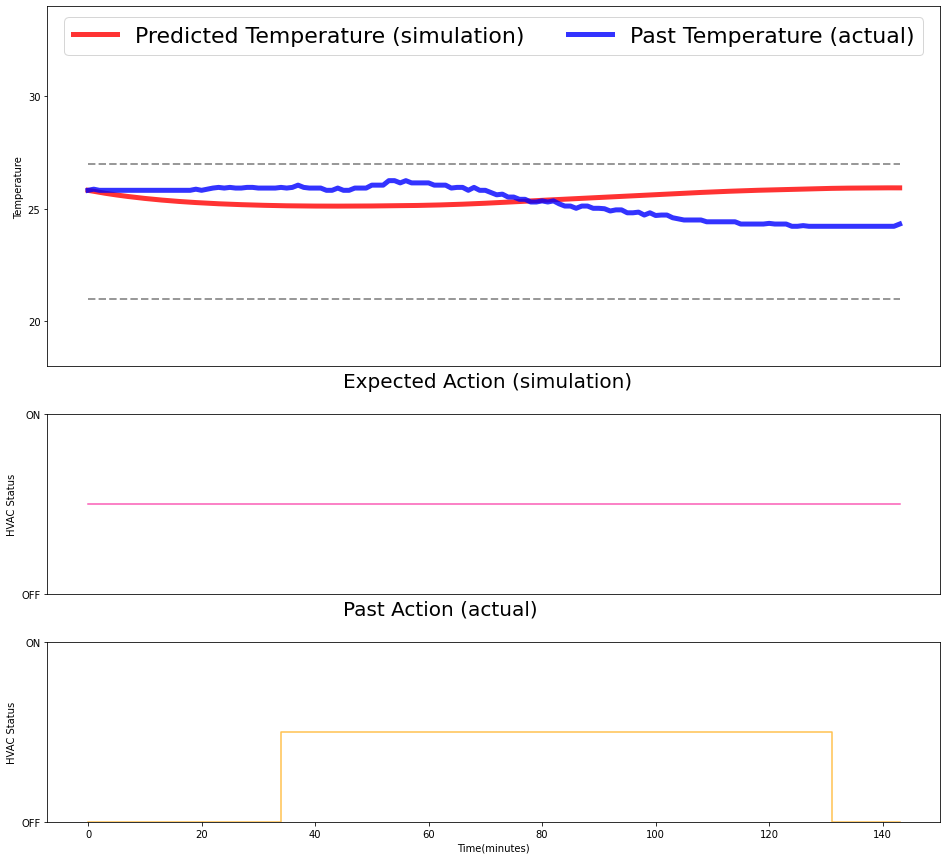

2023-02-02 00:33:49,954	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
144
1 일 평균 절감율 :  -48.45360824742268 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.466289291062786 오차율 :  -0.17302540217391638
/raid/deallab/ecm/model_result/2019-10-19/20191019w7_linear_regression.joblib
Reset data f3_temp : 24.55
Reset data f3_temp : 23.92
Reset data f3_temp : 24.62


2023-02-02 00:33:51,253	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:33:51,254	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:33:51,534	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-18/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-31-582v0sr2mj/checkpoint_005500/checkpoint-5500
2023-02-02 00:33:51,535	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5500, '_timesteps_total': 1408000, '_time_total': 6852.092402219772, '_episodes_total': 29123}


100
start_after_for :  0.00012087821960449219
Reset data f3_temp : 24.35
Reset data f3_temp : 24.42
Reset data f3_temp : 24.42
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.22
Reset data f3_temp : 24.5
Reset data f3_temp : 24.45
Reset data f3_temp : 24.32
Reset data f3_temp : 23.72
Reset data f3_temp : 24.5
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
Reset data f3_temp : 24.62
Reset data f3_temp : 24.55
  1 reward min :  -0.12/ mean :   0.18/ max :   2.40/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-19/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-33-49nq3rn0ym/checkpoint_005501/checkpoint-5501
Elapsed time one episode :  1.9802944660186768
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 24.62
Reset data f3_temp : 24.42
Reset data f3_temp : 24.62
Reset data f3_temp : 24.5
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02

(RolloutWorker pid=8737) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8737)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.5
Reset data f3_temp : 24.42
Reset data f3_temp : 24.72
  3 reward min :  -0.12/ mean :   0.13/ max :   2.40/ len   6.00
Elapsed time one episode :  1.0394442081451416
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.42
Reset data f3_temp : 24.35
Reset data f3_temp : 24.05
Reset data f3_temp : 24.72
Reset data f3_temp : 24.32
Reset data f3_temp : 24.62
Reset data f3_temp : 24.5
Reset data f3_temp : 24.5
  4 reward min :  -0.12/ mean :   0.08/ max :   2.40/ len   6.00
Elapsed time one episode :  1.0829927921295166
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.62
Reset data f3_temp : 23.82
Reset data f3_temp : 24.62
  5 reward min :  -0.12/ mean :   0.05/ max :   2.40/ len   6.00
Elapsed time one episode :  1.024214744567871
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 24.35
Reset data f3_temp : 24.02
Reset 

Reset data f3_temp : 23.92
Reset data f3_temp : 24.42
Reset data f3_temp : 24.35
Reset data f3_temp : 24.32
Reset data f3_temp : 24.72
Reset data f3_temp : 24.32
 23 reward min :   9.98/ mean :  14.77/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2712554931640625
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.42
Reset data f3_temp : 23.7
Reset data f3_temp : 24.62
Reset data f3_temp : 24.42
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.72
Reset data f3_temp : 24.35
 24 reward min :   9.98/ mean :  14.75/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9560937881469727
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.42
Reset data f3_temp : 24.42
Reset data f3_temp : 24.35
Reset data f3_temp : 24.5
Reset data f3_temp : 24.62
Reset data f3_temp : 24.02
Reset data f3_temp : 24.42
Reset data f3_temp : 24.72
Reset data f3_temp : 24.02
 25 reward min :   9.98/

Reset data f3_temp : 24.5
Reset data f3_temp : 23.92
 42 reward min :   4.96/ mean :  14.75/ max :  15.00/ len   6.00
Elapsed time one episode :  1.159285306930542
start_after_for :  1.2159347534179688e-05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.62
Reset data f3_temp : 24.42
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 24.22
Reset data f3_temp : 24.62
 43 reward min :   4.96/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0973665714263916
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.72
Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
Reset data f3_temp : 24.62
Reset data f3_temp : 24.45
Reset data f3_temp : 24.35
Reset data f3_temp : 24.5
Reset data f3_temp : 24.02
Reset data f3_temp : 24.42
Reset data f3_temp : 24.62
Reset data f3_temp : 24.72
 44 reward min :   4.96/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time 

Reset data f3_temp : 24.42
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 24.35
Reset data f3_temp : 24.22
Reset data f3_temp : 23.82
Reset data f3_temp : 24.42
Reset data f3_temp : 24.42
 62 reward min :   9.98/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0327823162078857
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 24.72
Reset data f3_temp : 24.35
Reset data f3_temp : 24.42
 63 reward min :   9.98/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2071657180786133
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.42
Reset data f3_temp : 24.35
Reset data f3_temp : 24.32
Reset data f3_temp : 23.7
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.32
Reset data f3_temp : 24.42
Reset data f3_temp

Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.62
Reset data f3_temp : 23.7
Reset data f3_temp : 24.22
Reset data f3_temp : 24.55
 82 reward min :   9.98/ mean :  14.87/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0060131549835205
start_after_for :  3.814697265625e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.42
Reset data f3_temp : 24.62
Reset data f3_temp : 24.42
Reset data f3_temp : 24.72
Reset data f3_temp : 24.55
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.62
Reset data f3_temp : 23.82
 83 reward min :   9.98/ mean :  14.82/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0115737915039062
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 24.5
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.5
Reset data f3_temp : 24.62
Reset data f3_temp : 24.72
Reset data f3_temp : 23.8

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-19 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  1 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.176830326988533


<Figure size 432x288 with 0 Axes>

2023-02-02 00:35:40,032	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
1
1 일 평균 절감율 :  98.96907216494846 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.176830326988533 오차율 :  0.07358633967814399
/raid/deallab/ecm/model_result/2019-10-20/20191020w1_linear_regression.joblib
Reset data f3_temp : 24.15
Reset data f3_temp : 23.95
Reset data f3_temp : 24.22


2023-02-02 00:35:41,206	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:35:41,208	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:35:41,459	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-19/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-33-49nq3rn0ym/checkpoint_005600/checkpoint-5600
2023-02-02 00:35:41,529	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5600, '_timesteps_total': 1433600, '_time_total': 6952.820028305054, '_episodes_total': 30126}


100
start_after_for :  0.0005338191986083984
Reset data f3_temp : 24.1
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 23.82
Reset data f3_temp : 23.72
Reset data f3_temp : 24.32
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 24.35
Reset data f3_temp : 24.32
Reset data f3_temp : 23.72
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
  1 reward min :  12.48/ mean :  14.70/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-20/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-35-40pcbwy_gh/checkpoint_005601/checkpoint-5601
Elapsed time one episode :  2.1317954063415527
start_after_for :  2.86102294921875e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 23.95
Reset data f3_temp : 24.05
Reset data f3_temp : 23.

(RolloutWorker pid=8723) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8723)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
  3 reward min : -10.00/ mean :  13.23/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0760314464569092
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 23.7
  4 reward min : -10.00/ mean :  13.55/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0815162658691406
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 24.32
Reset data f3_temp : 24.1
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 23.7
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
  5 reward min : -10.00/ mean :  13.70/ max :  15.00/ len   6.00
Elapsed t

Reset data f3_temp : 24.02
Reset data f3_temp : 23.82
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
 25 reward min : -15.00/ mean :   7.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0745110511779785
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
Reset data f3_temp : 23.92
 26 reward min : -15.00/ mean :   8.07/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0295491218566895
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 23.72
Reset data f3_temp : 24.1
Reset data f3_temp : 24.22
 27 reward min : -15.00/ mean :   8.90/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0853469371795654
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 24.32
Rese

Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.05
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
 47 reward min : -15.00/ mean :  12.10/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0659809112548828
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
 48 reward min : -15.00/ mean :  12.20/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2473392486572266
start_after_for :  7.3909759521484375e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
 49 reward min : -15.00/ mean :  11.92/ max : 

 67 reward min : -10.00/ mean :  13.99/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9815235137939453
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.32
Reset data f3_temp : 23.82
Reset data f3_temp : 23.72
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
 68 reward min : -10.00/ mean :  14.07/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0494921207427979
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.1
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.05
 69 reward min : -15.00/ mean :  13.22/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0083386898040771
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 24.22
R

Reset data f3_temp : 24.02
Reset data f3_temp : 24.1
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.02
Reset data f3_temp : 24.32
 88 reward min : -15.00/ mean :  12.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.060788631439209
start_after_for :  3.814697265625e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.32
Reset data f3_temp : 23.82
Reset data f3_temp : 23.7
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
 89 reward min : -15.00/ mean :  12.97/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0740022659301758
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.05
Reset data f3_temp : 24.1
Reset data f3_temp : 24.22

<Figure size 432x288 with 0 Axes>

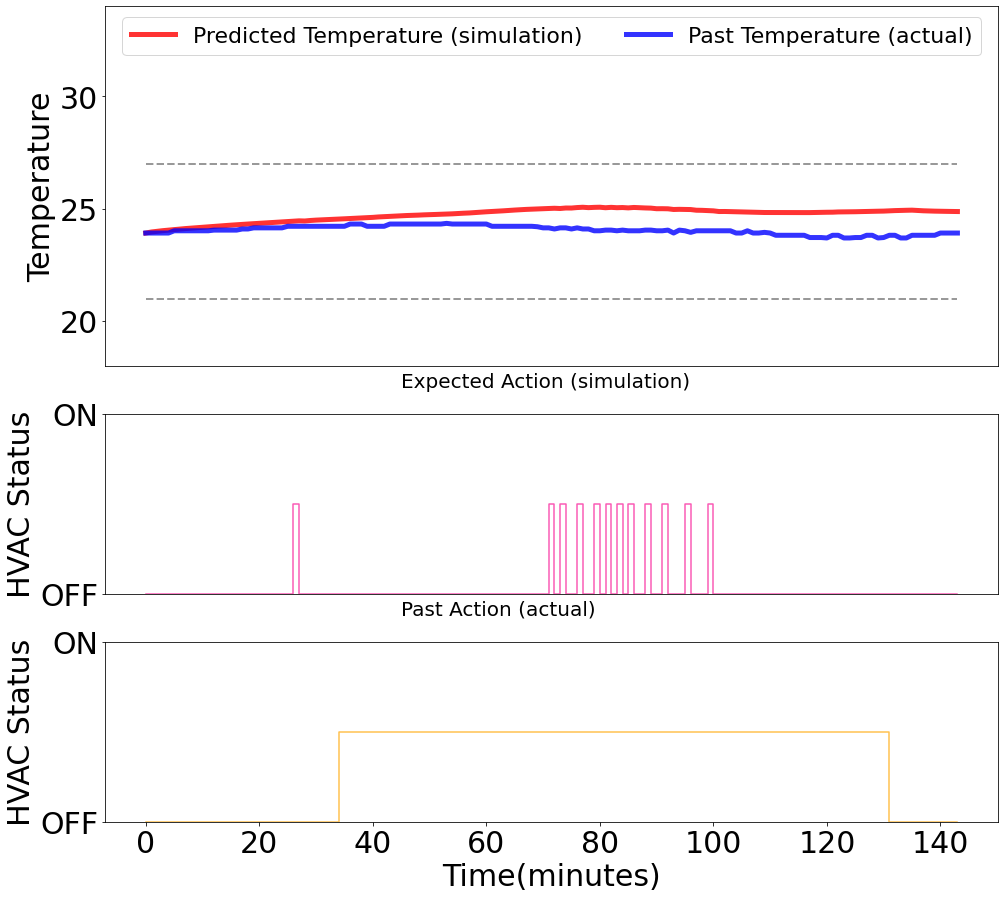

2023-02-02 00:37:32,347	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
12
1 일 평균 절감율 :  87.62886597938144 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.73264637732994 오차율 :  -0.6805630439965995
/raid/deallab/ecm/model_result/2019-10-21/20191021w14_linear_regression.joblib
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22


2023-02-02 00:37:33,864	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:37:33,866	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:37:34,100	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-20/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-35-40pcbwy_gh/checkpoint_005700/checkpoint-5700
2023-02-02 00:37:34,103	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5700, '_timesteps_total': 1459200, '_time_total': 7056.123692750931, '_episodes_total': 31016}


100
start_after_for :  5.793571472167969e-05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
  1 reward min :  -0.12/ mean :   8.77/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-21/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-37-32dikdnkai/checkpoint_005701/checkpoint-5701
Elapsed time one episode :  1.8041136264801025
start_after_for :  8.344650268554688e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 23.82
Reset data f3_temp : 2

(RolloutWorker pid=8760) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8760)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=8760) Reset data f3_temp : 24.05
(RolloutWorker pid=8760) Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
 16 reward min : -15.00/ mean :   2.94/ max :  15.00/ len   6.00
Elapsed time one episode :  1.364973545074463
start_after_for :  1.4781951904296875e-05
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
 17 reward min : -15.00/ mean :   2.61/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0647985935211182
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.

Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
 38 reward min :   7.44/ mean :  11.93/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9995651245117188
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.32
Reset data f3_temp : 23.92
 39 reward min :   7.44/ mean :  11.95/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0403711795806885
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
 40 reward min :   7.

Reset data f3_temp : 23.92
 62 reward min : -15.00/ mean :  -2.03/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0549871921539307
start_after_for :  5.9604644775390625e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 24.32
Reset data f3_temp : 24.1
Reset data f3_temp : 24.02
 63 reward min : -15.00/ mean :  -1.68/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0877203941345215
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
 64 reward min : -15.00/ mean :  -0.35/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2367725372314453
start_after_for :  1.8835067749023438e-05
Reset data f3_temp : 23.92
Reset data f3_temp : 24.02
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Res

Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
 86 reward min : -15.00/ mean :  -0.20/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0171563625335693
start_after_for :  5.9604644775390625e-06
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.22
Reset data f3_temp : 24.22
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
 87 reward min : -15.00/ mean :  -0.63/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0330603122711182
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 24.02
Reset data f3_temp : 24.22
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
 88 reward min : -15.00/ mean :  -1.53/ max :  

<Figure size 432x288 with 0 Axes>

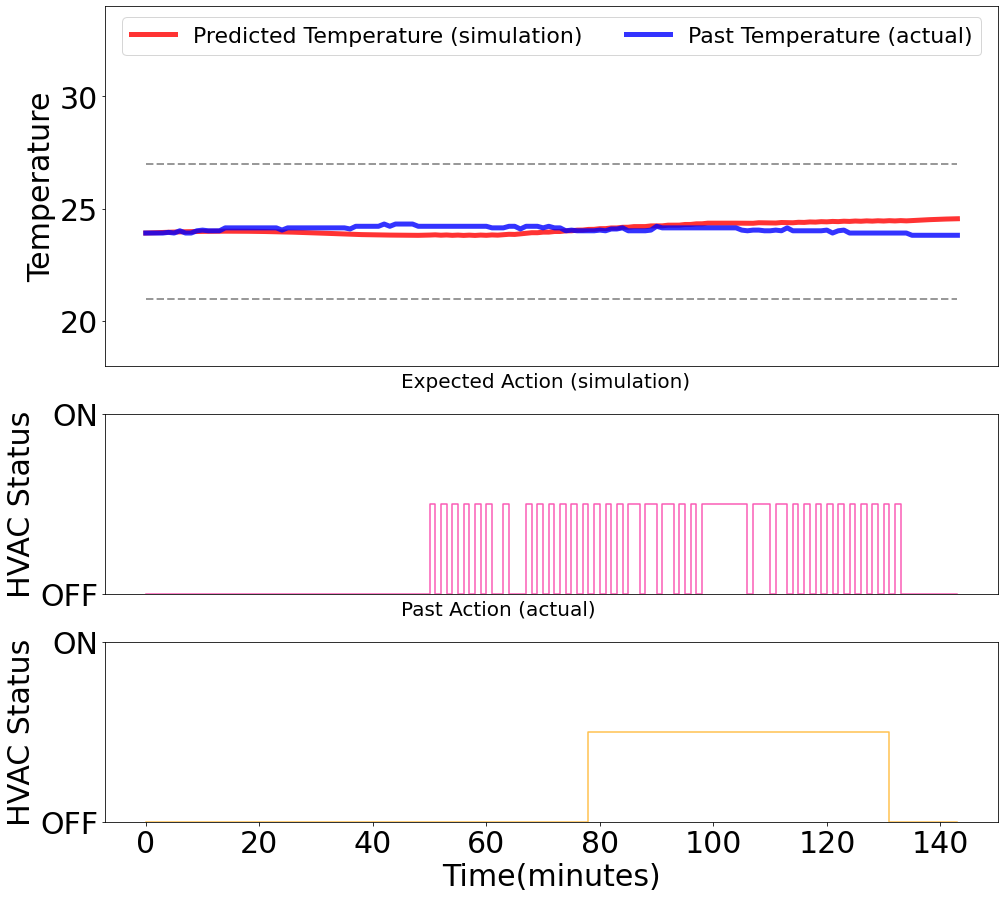

2023-02-02 00:39:26,619	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


53.0
47
1 일 평균 절감율 :  11.320754716981133 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  24.118590725011313 오차율 :  -0.03491016945572767
/raid/deallab/ecm/model_result/2019-10-22/20191022w7_linear_regression.joblib
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62


2023-02-02 00:39:28,330	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:39:28,332	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:39:28,596	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-21/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-37-32dikdnkai/checkpoint_005800/checkpoint-5800
2023-02-02 00:39:28,598	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5800, '_timesteps_total': 1484800, '_time_total': 7158.512354850769, '_episodes_total': 31770}


100
start_after_for :  0.0001327991485595703
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.55
  1 reward min :   9.98/ mean :  14.41/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-22/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-39-26r0gqqcef/checkpoint_005801/checkpoint-5801
Elapsed time one episode :  2.0644443035125732
start_after_for :  1.621246337890625e-05
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 2

2023-02-02 00:39:41,045	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff29339bc0ed8b4cc0467fcfb801000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {GPU: 1.000000}, {CPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 108.704351 GiB/108.704351 GiB memory, 0.000000/1.000000 GPU, 50.578962 GiB/50.578962 GiB object_store_memory, 1.000000/1.000000 accelerator_type:V100, 1.000000/1.000000 node:192.168.0.40}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.82
 11 reward min :  -0.12/ mean :  13.01/ max :  15.00/ len   6.00
Elapsed time one episode :  1.3822436332702637
start_after_for :  1.6689300537109375e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.7
Reset data f3_temp : 23.72
Reset data f3_temp : 23.72
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
 12 reward min :  -0.12/ mean :  13.15/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9607715606689453
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 23.55
Reset data f3_temp : 23.62
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
 13 reward min :  -0.12/ mean :  13.25/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0202674865722656
start_after_for :  3.0994415283203125e-06
Reset data f3_temp : 23.72
(RolloutWorker pid=8743) Reset data f3_temp : 23.52
(RolloutWorker pid=8743) Reset data f3_temp : 23.72
Reset data f3_temp : 23.82


(RolloutWorker pid=8743) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8743)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
 14 reward min :  -0.12/ mean :  13.34/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0106964111328125
start_after_for :  4.0531158447265625e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.42
Reset data f3_temp : 23.7
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 15 reward min :  -0.12/ mean :  13.39/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0792553424835205
start_after_for :  3.0994415283203125e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 16 reward min :  -0.12/ mean :  13.39/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0606727600097656
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82

Reset data f3_temp : 23.52
Reset data f3_temp : 23.32
Reset data f3_temp : 23.62
Reset data f3_temp : 23.32
Reset data f3_temp : 23.82
 38 reward min :   9.96/ mean :  14.75/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0189063549041748
start_after_for :  3.337860107421875e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.32
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
 39 reward min :   9.96/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2068424224853516
start_after_for :  1.52587890625e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
 40 reward min :   9.96/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2680439949035645
start_after_for :  3.814697265625e-06
Reset da

Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.72
 63 reward min :  12.48/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2884080410003662
start_after_for :  3.814697265625e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.32
 64 reward min :  12.48/ mean :  14.75/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0516910552978516
start_after_for :  3.5762786865234375e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
 65 reward min :  12.48/ mean :  14.77/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1999399662017822
start_after_for :  1.2874603271484375e-05
Re

Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
 89 reward min :  12.48/ mean :  14.85/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2273433208465576
start_after_for :  9.298324584960938e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.55
Reset data f3_temp : 23.72
Reset data f3_temp : 23.82
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 90 reward min :  12.48/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9764435291290283
start_after_for :  1.52587890625e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
 91 reward min :  12.48/ mean :  14.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.340935230255127
start_after_for :  5.9604644775390625e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 23.62
Reset

<Figure size 432x288 with 0 Axes>

2023-02-02 00:41:23,212	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


97.0
2
1 일 평균 절감율 :  97.9381443298969 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.89009652777365 오차율 :  -0.30724930555143715
/raid/deallab/ecm/model_result/2019-10-23/20191023w30_linear_regression.joblib
Reset data f3_temp : 23.92
Reset data f3_temp : 23.82
Reset data f3_temp : 23.42


2023-02-02 00:41:25,303	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:41:25,361	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:41:25,791	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-22/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-39-26r0gqqcef/checkpoint_005900/checkpoint-5900
2023-02-02 00:41:25,793	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 5900, '_timesteps_total': 1510400, '_time_total': 7261.766680717468, '_episodes_total': 32442}


100
start_after_for :  5.7220458984375e-05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.62
Reset data f3_temp : 24.05
Reset data f3_temp : 23.52
Reset data f3_temp : 24.22
Reset data f3_temp : 23.62
Reset data f3_temp : 23.52
Reset data f3_temp : 24.15
Reset data f3_temp : 23.42
Reset data f3_temp : 23.3
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.92
Reset data f3_temp : 23.62
Reset data f3_temp : 23.65
Reset data f3_temp : 23.42
  1 reward min : -10.00/ mean :  13.23/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-41-2363f1zxyt/checkpoint_005901/checkpoint-5901
Elapsed time one episode :  1.8937206268310547
start_after_for :  4.291534423828125e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.95
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.5

2023-02-02 00:41:41,004	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffb54b07fedaae174b23e96cbb01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 108.704351 GiB/108.704351 GiB memory, 0.000000/1.000000 GPU, 50.578962 GiB/50.578962 GiB object_store_memory, 1.000000/1.000000 accelerator_type:V100, 1.000000/1.000000 node:192.168.0.40}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.52
 14 reward min : -15.00/ mean :   5.85/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1313467025756836
start_after_for :  5.245208740234375e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.4
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 23.82
 15 reward min : -15.00/ mean :   5.67/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1107985973358154
start_after_for :  1.811981201171875e-05
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
Reset data f3_temp : 23.72
Reset data f3_temp : 24.22
(RolloutWorker pid=8729) Reset data f3_temp : 23.52
(RolloutWorker pid=8729) Reset data f3_temp : 23.62
Reset data f3_temp : 24.05
 16 reward min : -15.00/ mean :   5.50/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9737362861633301
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 23.92


(RolloutWorker pid=8729) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8729)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Reset data f3_temp : 23.52
Reset data f3_temp : 23.82
Reset data f3_temp : 23.32
Reset data f3_temp : 24.15
 17 reward min : -15.00/ mean :   5.35/ max :  15.00/ len   6.00
Elapsed time one episode :  1.189225673675537
start_after_for :  1.2874603271484375e-05
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 24.05
Reset data f3_temp : 23.7
 18 reward min : -15.00/ mean :   6.50/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9929609298706055
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.15
Reset data f3_temp : 24.42
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 23.42
Reset data f3_temp : 24.05
 19 reward min : -15.00/ mean :   7.54/ max :  15.00/ len   6.00
Elapsed time one episode :  1.3128390312194824
start_after_for :  1.9550323486328125e-05
Reset data f3_temp : 24.22
Reset data f3_temp : 24.05
Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52


Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 23.52
Reset data f3_temp : 23.52
 43 reward min :   9.96/ mean :  11.32/ max :  15.00/ len   6.00
Elapsed time one episode :  1.042726993560791
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 23.42
Reset data f3_temp : 24.05
Reset data f3_temp : 24.22
 44 reward min :   9.96/ mean :  11.35/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2547428607940674
start_after_for :  1.1682510375976562e-05
Reset data f3_temp : 24.1
Reset data f3_temp : 24.15
Reset data f3_temp : 23.52
Reset data f3_temp : 23.42
Reset data f3_temp : 24.22
 45 reward min :   9.96/ mean :  11.27/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9474272727966309
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 23.82
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
Reset data f3_temp : 24.05
Reset data f3_temp : 24.15
Reset

Reset data f3_temp : 23.42
Reset data f3_temp : 23.62
Reset data f3_temp : 24.15
Reset data f3_temp : 23.62
 70 reward min : -10.02/ mean :  10.92/ max :  15.00/ len   6.00
Elapsed time one episode :  1.239839792251587
start_after_for :  1.5974044799804688e-05
Reset data f3_temp : 24.15
Reset data f3_temp : 23.32
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.1
Reset data f3_temp : 23.82
 71 reward min : -10.02/ mean :  10.92/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9780328273773193
start_after_for :  6.9141387939453125e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 23.8
Reset data f3_temp : 23.42
Reset data f3_temp : 23.3
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
 72 reward min : -10.02/ mean :  10.95/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0531723499298096
start_after_for :  5.7220458984375e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.62
Reset data f3_temp : 23.42
Reset

Reset data f3_temp : 23.42
Reset data f3_temp : 24.05
Reset data f3_temp : 23.52
Reset data f3_temp : 23.92
Reset data f3_temp : 23.42
Reset data f3_temp : 23.72
Reset data f3_temp : 23.42
 96 reward min :  -5.02/ mean :  10.77/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0784316062927246
start_after_for :  7.62939453125e-06
Reset data f3_temp : 23.92
Reset data f3_temp : 24.15
Reset data f3_temp : 24.15
Reset data f3_temp : 23.42
Reset data f3_temp : 24.05
Reset data f3_temp : 23.42
Reset data f3_temp : 24.15
 97 reward min :  -5.02/ mean :  10.80/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0448625087738037
start_after_for :  5.0067901611328125e-06
Reset data f3_temp : 24.22
Reset data f3_temp : 23.4
Reset data f3_temp : 23.92
Reset data f3_temp : 23.82
Reset data f3_temp : 23.72
Reset data f3_temp : 24.15
 98 reward min :  -5.02/ mean :  10.85/ max :  15.00/ len   6.00
Elapsed time one episode :  1.5258212089538574
start_after_for :  1.2636184692382812e-05
Rese

<Figure size 432x288 with 0 Axes>

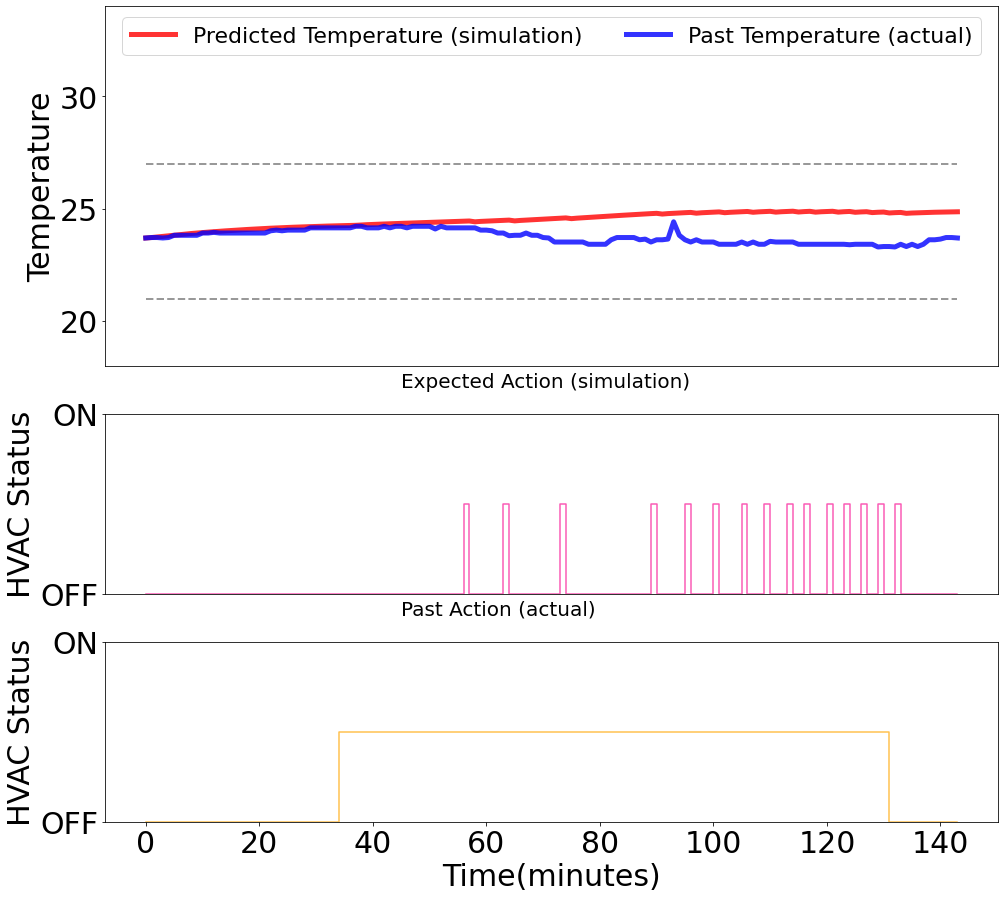

97.0
15
1 일 평균 절감율 :  84.5360824742268 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.510503594816747 오차율 :  -0.7484897059278417
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
Reset data f3_temp : 23.82


2023-02-02 00:43:23,151	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


Reset data f3_temp : 23.4
Reset data f3_temp : 23.3


2023-02-02 00:43:25,289	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:43:25,293	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:43:25,626	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-23/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-41-2363f1zxyt/checkpoint_006000/checkpoint-6000
2023-02-02 00:43:25,628	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6000, '_timesteps_total': 1536000, '_time_total': 7365.705756187439, '_episodes_total': 33058}


100
start_after_for :  6.651878356933594e-05
Reset data f3_temp : 24.05
Reset data f3_temp : 23.4
Reset data f3_temp : 23.82
Reset data f3_temp : 23.82
Reset data f3_temp : 23.25
Reset data f3_temp : 23.72
Reset data f3_temp : 23.92
Reset data f3_temp : 23.62
Reset data f3_temp : 23.12
Reset data f3_temp : 23.82
Reset data f3_temp : 23.2
Reset data f3_temp : 23.2
Reset data f3_temp : 23.92
Reset data f3_temp : 23.12
Reset data f3_temp : 23.12
Reset data f3_temp : 23.12
Reset data f3_temp : 23.82
Reset data f3_temp : 24.05
  1 reward min :   9.98/ mean :  13.96/ max :  15.00/ len   6.00
checkpoint saved at /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-43-22wiao_vyi/checkpoint_006001/checkpoint-6001
Elapsed time one episode :  3.3321290016174316
start_after_for :  1.430511474609375e-05
Reset data f3_temp : 23.0
Reset data f3_temp : 24.02
Reset data f3_temp : 24.15
Reset data f3_temp : 23.92
  2 reward min : -10.02/ mean :  10.59/ max :  15.00/

2023-02-02 00:43:41,013	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffd73cb936ac3bffb50efefb5101000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 108.704351 GiB/108.704351 GiB memory, 0.000000/1.000000 GPU, 50.578962 GiB/50.578962 GiB object_store_memory, 1.000000/1.000000 accelerator_type:V100, 1.000000/1.000000 node:192.168.0.40}
 In total there are 0 pending tasks and 1 pending actors on this node.


Reset data f3_temp : 23.42
Reset data f3_temp : 23.42
 12 reward min : -15.00/ mean :   6.12/ max :  15.00/ len   6.00
Elapsed time one episode :  2.030642032623291
start_after_for :  2.765655517578125e-05
Reset data f3_temp : 24.15
 13 reward min : -15.00/ mean :   5.80/ max :  15.00/ len   6.00
Elapsed time one episode :  0.2966644763946533
start_after_for :  1.9073486328125e-06
Reset data f3_temp : 23.7
Reset data f3_temp : 23.32
Reset data f3_temp : 24.02
Reset data f3_temp : 23.32
 14 reward min : -15.00/ mean :   4.63/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0493512153625488
start_after_for :  7.62939453125e-06
Reset data f3_temp : 24.1
Reset data f3_temp : 23.3
Reset data f3_temp : 24.02
Reset data f3_temp : 23.4


(RolloutWorker pid=8734) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8734)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=8734) Reset data f3_temp : 24.05
(RolloutWorker pid=8734) Reset data f3_temp : 23.4
Reset data f3_temp : 23.32
 15 reward min : -15.00/ mean :   3.34/ max :  15.00/ len   6.00
Elapsed time one episode :  1.1535792350769043
start_after_for :  4.5299530029296875e-06
Reset data f3_temp : 23.52
Reset data f3_temp : 23.12
Reset data f3_temp : 23.42
Reset data f3_temp : 23.12
 16 reward min : -15.00/ mean :   2.48/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0667905807495117
start_after_for :  6.67572021484375e-06
Reset data f3_temp : 23.2
Reset data f3_temp : 23.2
Reset data f3_temp : 23.2
Reset data f3_temp : 23.2
 17 reward min : -15.00/ mean :   1.71/ max :  15.00/ len   6.00
Elapsed time one episode :  1.026263952255249
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 24.1
Reset data f3_temp : 23.42
Reset data f3_temp : 23.52
Reset data f3_temp : 23.4
 18 reward min : -15.00/ mean :   1.35/ max :  15.00/ len   6.00
Elapsed time one episode :  1.

Reset data f3_temp : 23.32
 43 reward min : -15.00/ mean :   3.46/ max :  15.00/ len   6.00
Elapsed time one episode :  1.5260777473449707
start_after_for :  1.239776611328125e-05
Reset data f3_temp : 23.2
Reset data f3_temp : 23.42
Reset data f3_temp : 23.82
Reset data f3_temp : 23.72
 44 reward min : -15.00/ mean :   3.16/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9665629863739014
start_after_for :  2.1696090698242188e-05
Reset data f3_temp : 23.12
Reset data f3_temp : 23.72
Reset data f3_temp : 24.02
Reset data f3_temp : 23.12
 45 reward min : -15.00/ mean :   3.54/ max :  15.00/ len   6.00
Elapsed time one episode :  0.9914155006408691
start_after_for :  7.3909759521484375e-06
Reset data f3_temp : 24.05
Reset data f3_temp : 23.12
Reset data f3_temp : 23.92
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
 46 reward min : -15.00/ mean :   4.02/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2423362731933594
start_after_for :  7.3909759521484375e-06
Reset dat

Reset data f3_temp : 23.92
Reset data f3_temp : 23.72
Reset data f3_temp : 23.42
Reset data f3_temp : 23.12
 74 reward min : -15.00/ mean :   7.13/ max :  15.00/ len   6.00
Elapsed time one episode :  1.0243206024169922
start_after_for :  6.4373016357421875e-06
Reset data f3_temp : 23.42
Reset data f3_temp : 23.92
Reset data f3_temp : 23.42
Reset data f3_temp : 24.15
Reset data f3_temp : 23.12
 75 reward min : -15.00/ mean :   5.90/ max :  15.00/ len   6.00
Elapsed time one episode :  1.2303545475006104
start_after_for :  4.76837158203125e-06
Reset data f3_temp : 23.2
Reset data f3_temp : 24.02
Reset data f3_temp : 23.42
Reset data f3_temp : 24.02
Reset data f3_temp : 23.92
 76 reward min : -15.00/ mean :   4.71/ max :  15.00/ len   6.00
Elapsed time one episode :  1.285700798034668
start_after_for :  1.3113021850585938e-05
Reset data f3_temp : 23.12
Reset data f3_temp : 23.92
Reset data f3_temp : 23.2
Reset data f3_temp : 23.12
Reset data f3_temp : 23.72
 77 reward min : -15.00/ mean 

<Figure size 432x288 with 0 Axes>

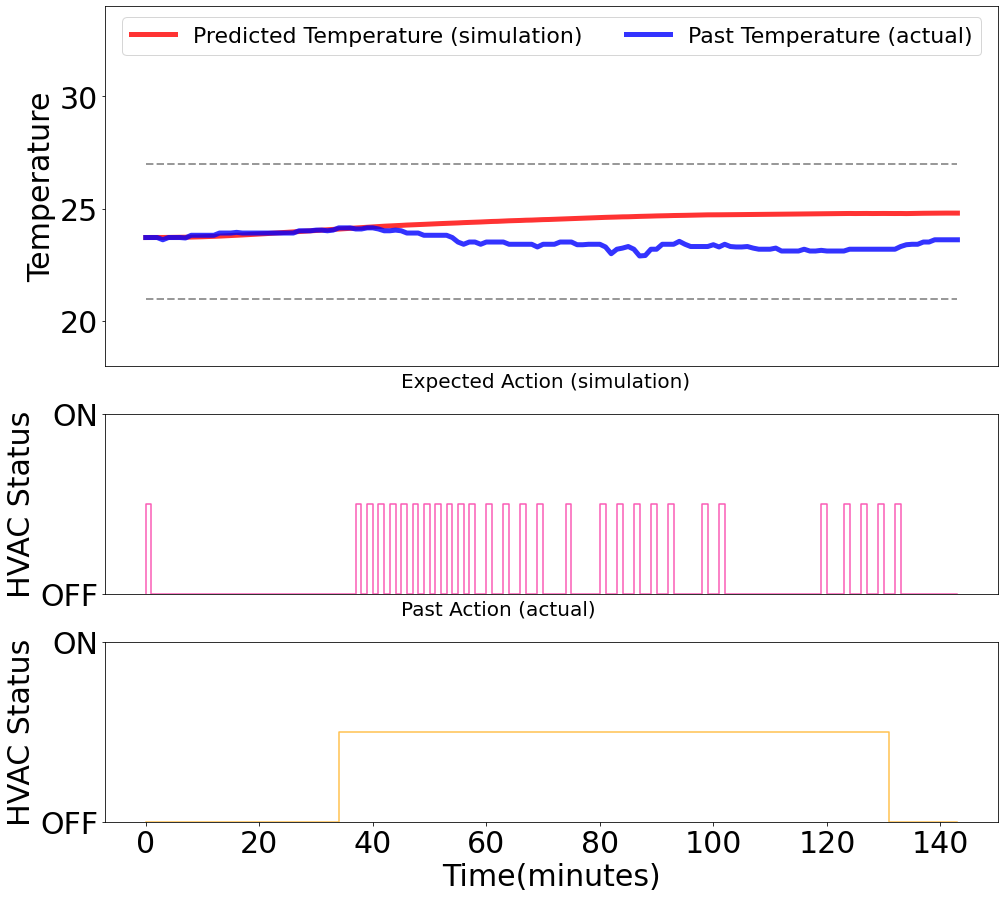

97.0
29
1 일 평균 절감율 :  70.10309278350515 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.415391913324097 오차율 :  -0.860600246657441


In [40]:
Train_date =  datetime.date(2019,10,18)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-17/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-17-593ig24zeg/checkpoint_005400/checkpoint-5400'
print(checkpoint_path)
first_start = time.time()
result_final_df = pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN-result-pre-7.csv')

for single_date in daterange:
#for i in range(81):
# 발산값 처리 
    if Train_date==datetime.date(2019,9,18) or Train_date==datetime.date(2019,8,27)  :
        Train_date = Train_date+datetime.timedelta(days=1)
        continue
        
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 25, 'min_temp' : 23.5, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN-lin-6-pre-basic-7'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    Elapsed_time = time.time() - start
    print("Elapsed time : ", Elapsed_time)
   
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint_path)
    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DQN-pre-7.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
     # elapsed 타임 너무 오래 걸리면 끝내기
    if Elapsed_time > 240:
        print(checkpoint)
        print(Train_date)
        print("Finished Time : ", time.time() - first_start)
        break

    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_final_df = result_final_df.sort_values(by=['0'], axis=0)
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN-result-pre-7.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# /raid/deallab/yechae/ECM/2023/result/2019-09-20/RL_ECM_DQN-lin-6-pre-basic-3_2023-02-01_13-15-35fvg49ev7/checkpoint_002800/checkpoint-2800 : 결과 잘 나올 것 같음 ㅠㅠ 

In [66]:
[ 5.2000000e+01,  5.6270924e+01,  2.5820463e+01,  2.2370001e+01,
       -7.8326700e+11,  8.0400002e+01,  9.6600801e+10,  2.7500000e+01,
       -2.0922839e+10]

2023-02-01 11:14:06,722	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffff0e159c35f2d0f2d108f42edd01000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}, {GPU: 1.000000}
Available resources on this node: {39.000000/40.000000 CPU, 126.704317 GiB/126.704317 GiB memory, 0.000000/1.000000 GPU, 58.293233 GiB/58.293233 GiB object_store_memory, 1.000000/1.000000 node:192.168.0.40, 1.000000/1.000000 accelerator_type:V100}
 In total there are 0 pending tasks and 1 pending actors on this node.


[52.0,
 56.270924,
 25.820463,
 22.370001,
 -783267000000.0,
 80.400002,
 96600801000.0,
 27.5,
 -20922839000.0]

(RolloutWorker pid=18204) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=18204)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(RolloutWorker pid=18204) Reset data f3_temp : 21.07
(RolloutWorker pid=18204) Reset data f3_temp : 25.37


In [ ]:
app = test1.append(test2)

In [50]:
app = app.sort_values(by=['0'], axis=0)

In [51]:
app.to_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [43]:
test1= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result.csv')

In [44]:
test2= pd.read_csv(f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-range-pre-result-2.csv')

In [43]:
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-linear-6-result.csv'
result_df.to_csv(result_df_path)

In [ ]:
'/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic_2023-01-31_21-28-08h1rw2fp6/checkpoint_006300/checkpoint-6300' # 첫번째, reward = (action_reward * 2.5)  - temp_violation_reward - power_reward , basic

# 결과 확인

2023-02-02 00:50:28,704	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.


/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-43-22wiao_vyi/checkpoint_006100/checkpoint-6100
Reset data f3_temp : 23.72
Reset data f3_temp : 23.42
Reset data f3_temp : 24.1


2023-02-02 00:50:31,295	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-02-02 00:50:31,297	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-02-02 00:50:31,557	INFO trainable.py:496 -- Restored on 192.168.0.40 from checkpoint: /raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-43-22wiao_vyi/checkpoint_006100/checkpoint-6100
2023-02-02 00:50:31,559	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 6100, '_timesteps_total': 1561600, '_time_total': 7467.838735818863, '_episodes_total': 33540}


/raid/deallab/ecm/model_result/2019-08-23/20190823w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 27.3
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  143 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.16986370580996


<Figure size 432x288 with 0 Axes>

139.0
143
1 일 평균 절감율 :  -2.877697841726619 실제 평균 온도 :  25.0945138888889 학습 평균 온도 :  28.16986370580996 오차율 :  -3.075349816921058
/raid/deallab/ecm/model_result/2019-08-24/20190824w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 24.17
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-24 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  141 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.73479432462807


<Figure size 432x288 with 0 Axes>

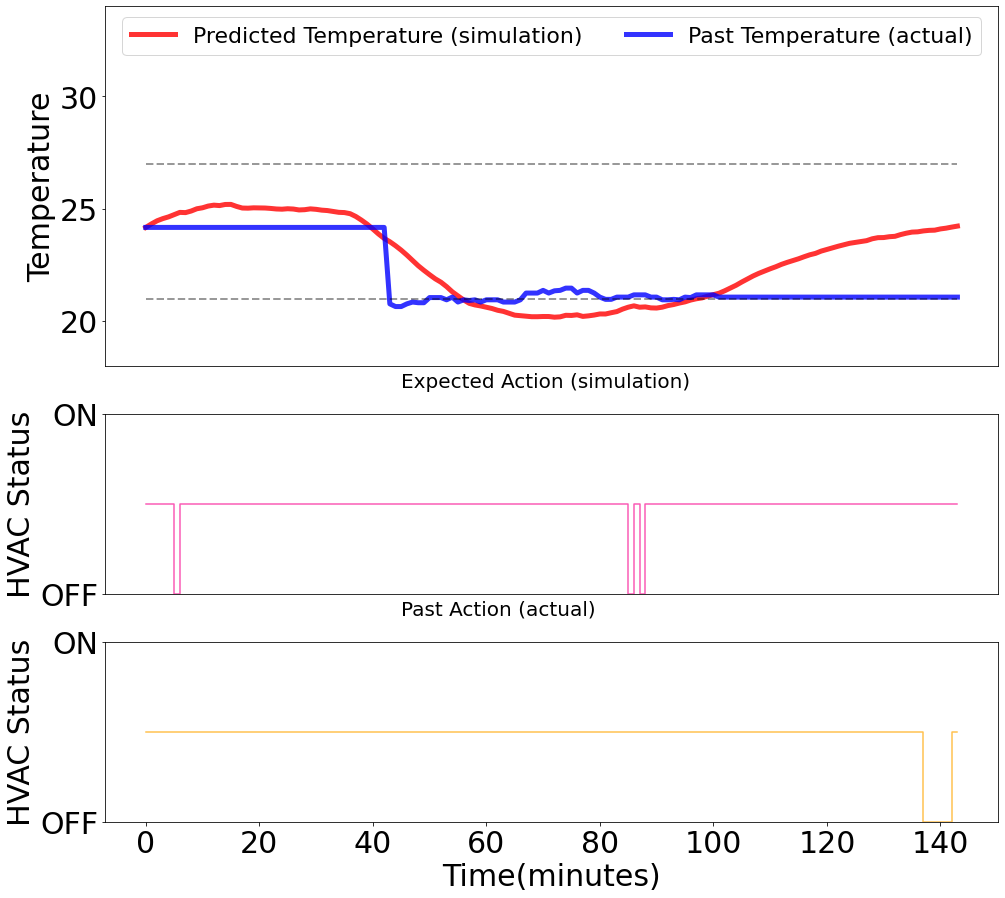

139.0
141
1 일 평균 절감율 :  -1.4388489208633095 실제 평균 온도 :  21.98923611111115 학습 평균 온도 :  22.73479432462807 오차율 :  -0.7455582135169188
/raid/deallab/ecm/model_result/2019-08-25/20190825w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
(scheduler +19m6s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-25 실제 데이터 길이 :  144  : real action :  139.0 , expect

<Figure size 432x288 with 0 Axes>

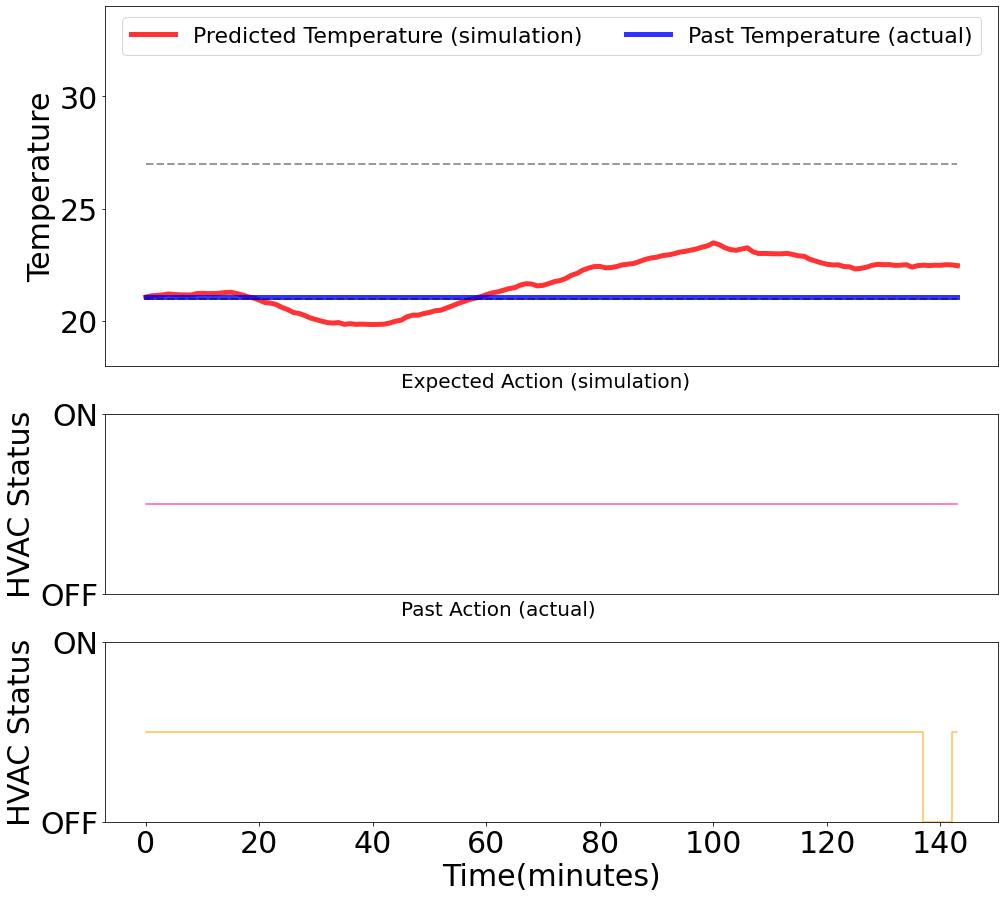

139.0
144
1 일 평균 절감율 :  -3.597122302158273 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.717401160032043 오차율 :  -0.6474011600320075
/raid/deallab/ecm/model_result/2019-08-26/20190826w1_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 21.07
(RolloutWorker pid=8750) Reset data f3_temp : 23.92
(RolloutWorker pid=8750) Reset data f3_temp : 23.92


(RolloutWorker pid=8750) /home/deallab/anaconda3/envs/daewoong/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8750)   warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-26 실제 데이터 길이 :  144  : real action :  144.0 , expected action :  142 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004


<Figure size 432x288 with 0 Axes>

144.0
142
1 일 평균 절감율 :  1.3888888888888888 실제 평균 온도 :  21.070000000000036 학습 평균 온도 :  21.07000000000004 오차율 :  -3.552713678800501e-15
/raid/deallab/ecm/model_result/2019-08-27/20190827w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-08-27 실제 데이터 길이 :  144  : real action :  79.0 , expected action :  143 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036


<Figure size 432x288 with 0 Axes>

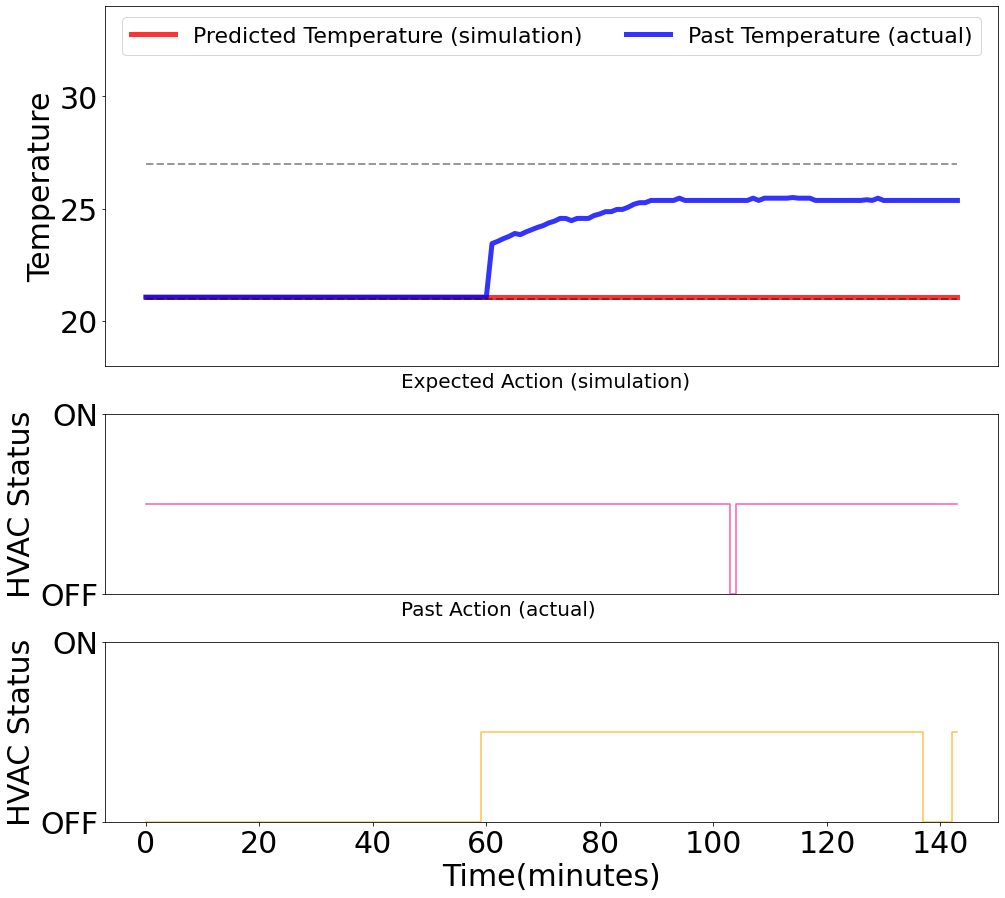

79.0
143
1 일 평균 절감율 :  -81.0126582278481 실제 평균 온도 :  23.379374999999953 학습 평균 온도 :  21.070000000000036 오차율 :  2.3093749999999176
/raid/deallab/ecm/model_result/2019-08-28/20190828w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.37
[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  70 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.333693984681094


<Figure size 432x288 with 0 Axes>

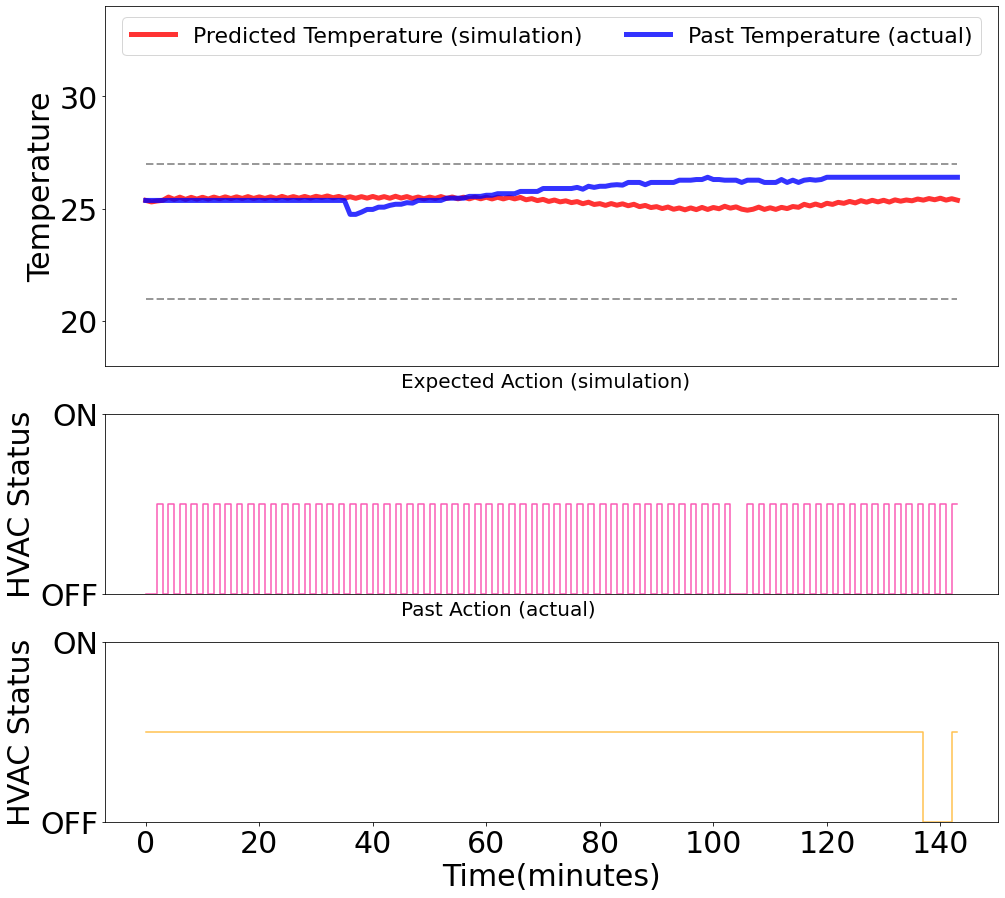

139.0
70
1 일 평균 절감율 :  49.64028776978417 실제 평균 온도 :  25.814513888888925 학습 평균 온도 :  25.333693984681094 오차율 :  0.4808199042078307
/raid/deallab/ecm/model_result/2019-08-29/20190829w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.4
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-08-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  72 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.158493184843373


<Figure size 432x288 with 0 Axes>

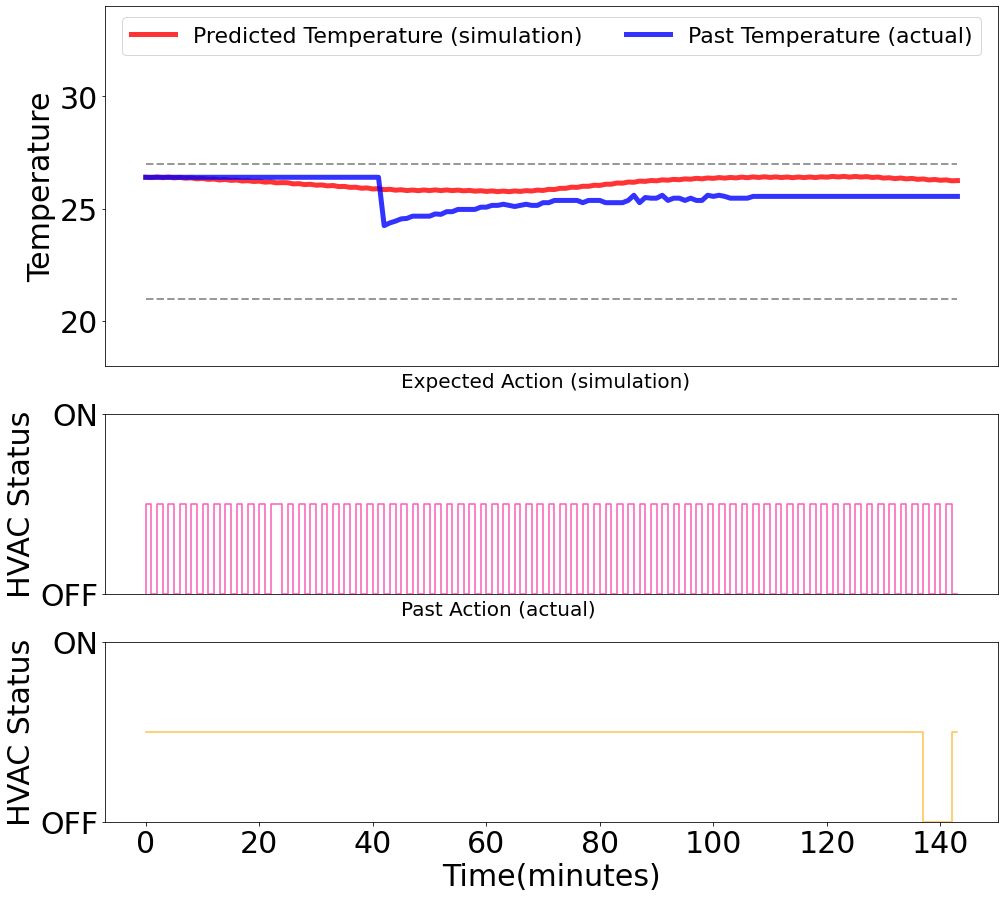

139.0
72
1 일 평균 절감율 :  48.201438848920866 실제 평균 온도 :  25.631250000000026 학습 평균 온도 :  26.158493184843373 오차율 :  -0.5272431848433463
/raid/deallab/ecm/model_result/2019-08-30/20190830w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.55
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-08-30 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  72 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  24.027376461114784


<Figure size 432x288 with 0 Axes>

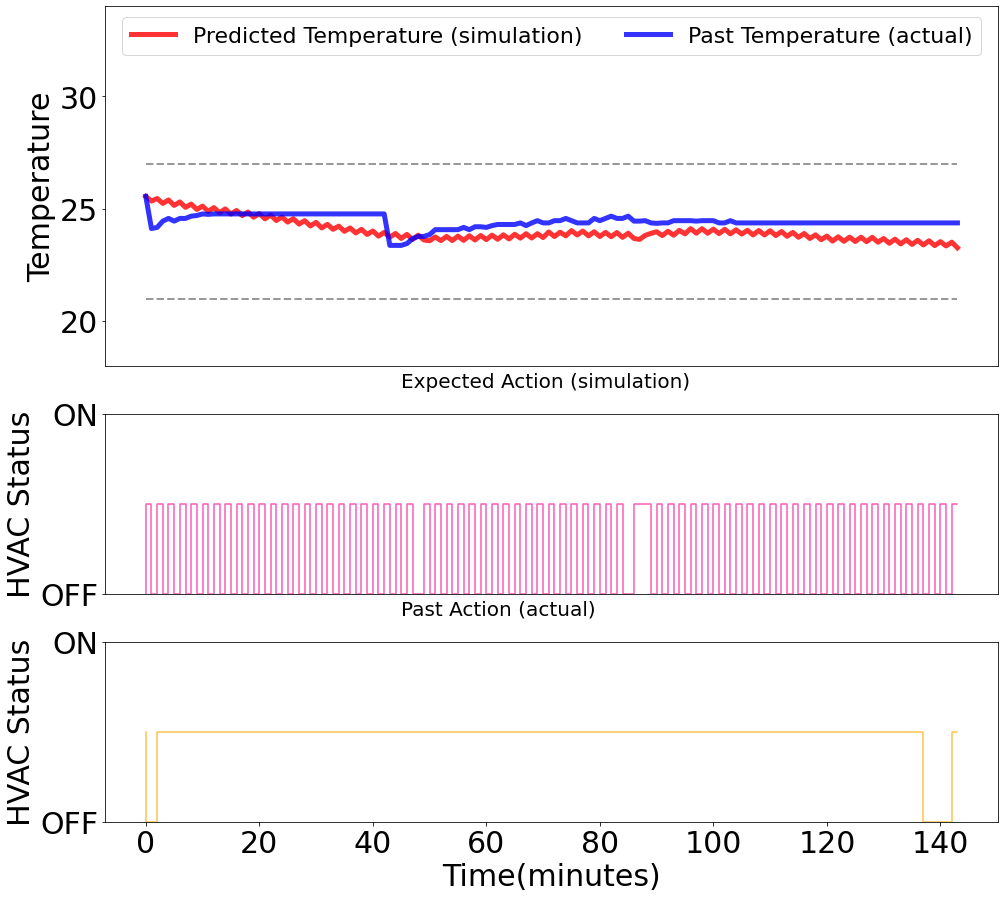

137.0
72
1 일 평균 절감율 :  47.44525547445255 실제 평균 온도 :  24.43333333333327 학습 평균 온도 :  24.027376461114784 오차율 :  0.40595687221848564
/raid/deallab/ecm/model_result/2019-08-31/20190831w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-08-31 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  73 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.552105940113083


<Figure size 432x288 with 0 Axes>

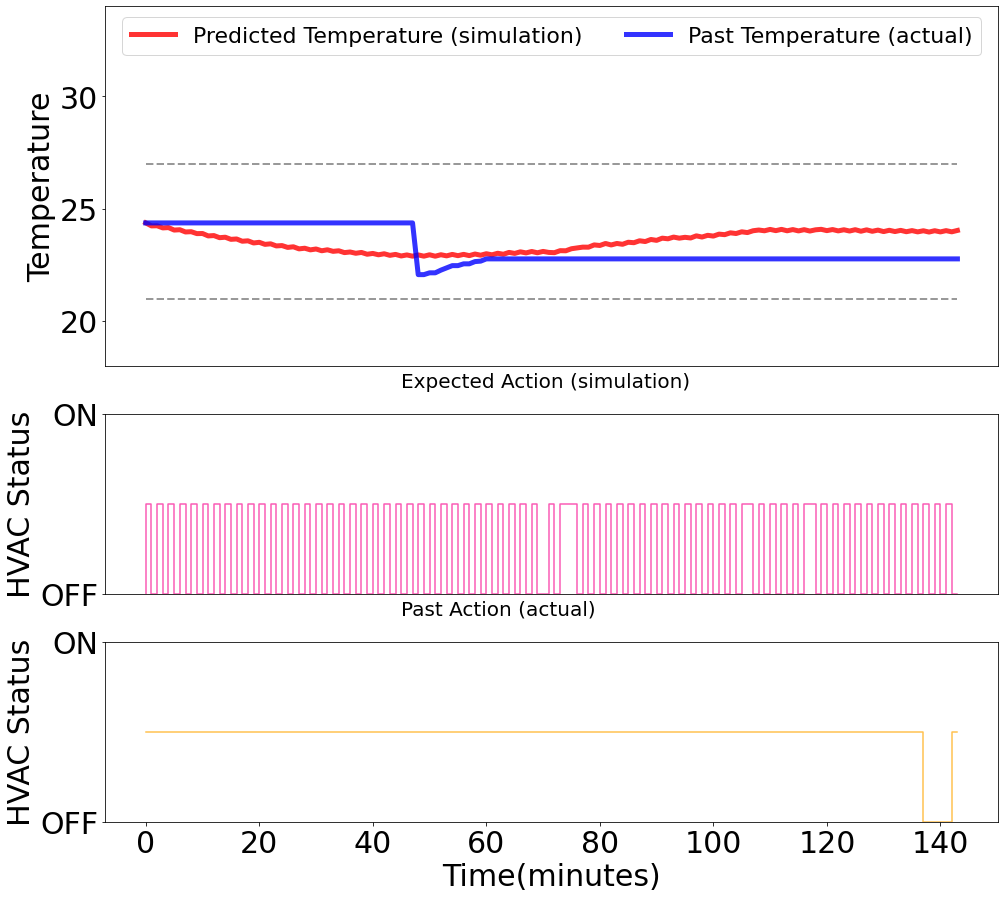

139.0
73
1 일 평균 절감율 :  47.482014388489205 실제 평균 온도 :  23.26999999999999 학습 평균 온도 :  23.552105940113083 오차율 :  -0.28210594011309453
/raid/deallab/ecm/model_result/2019-09-01/20190901w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  68 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.57909747522366


<Figure size 432x288 with 0 Axes>

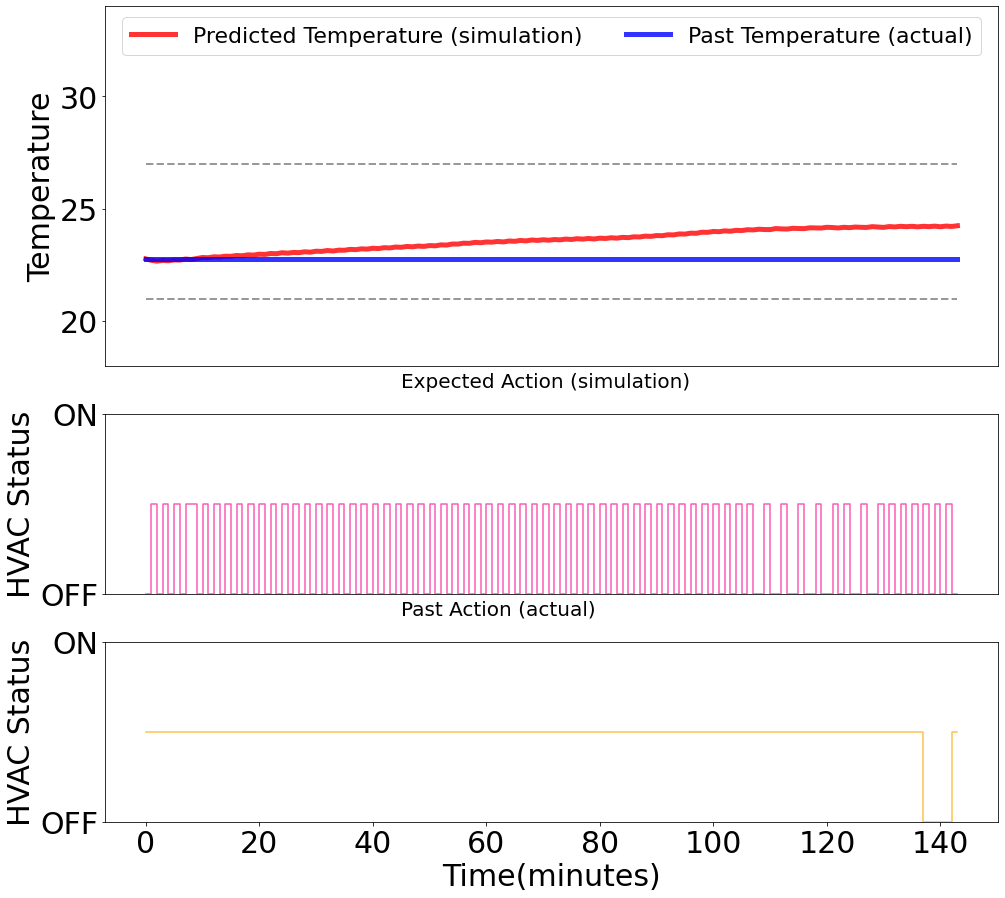

139.0
68
1 일 평균 절감율 :  51.07913669064749 실제 평균 온도 :  22.769999999999985 학습 평균 온도 :  23.57909747522366 오차율 :  -0.8090974752236733
/raid/deallab/ecm/model_result/2019-09-02/20190902w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.77
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  10 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.800605691901108


<Figure size 432x288 with 0 Axes>

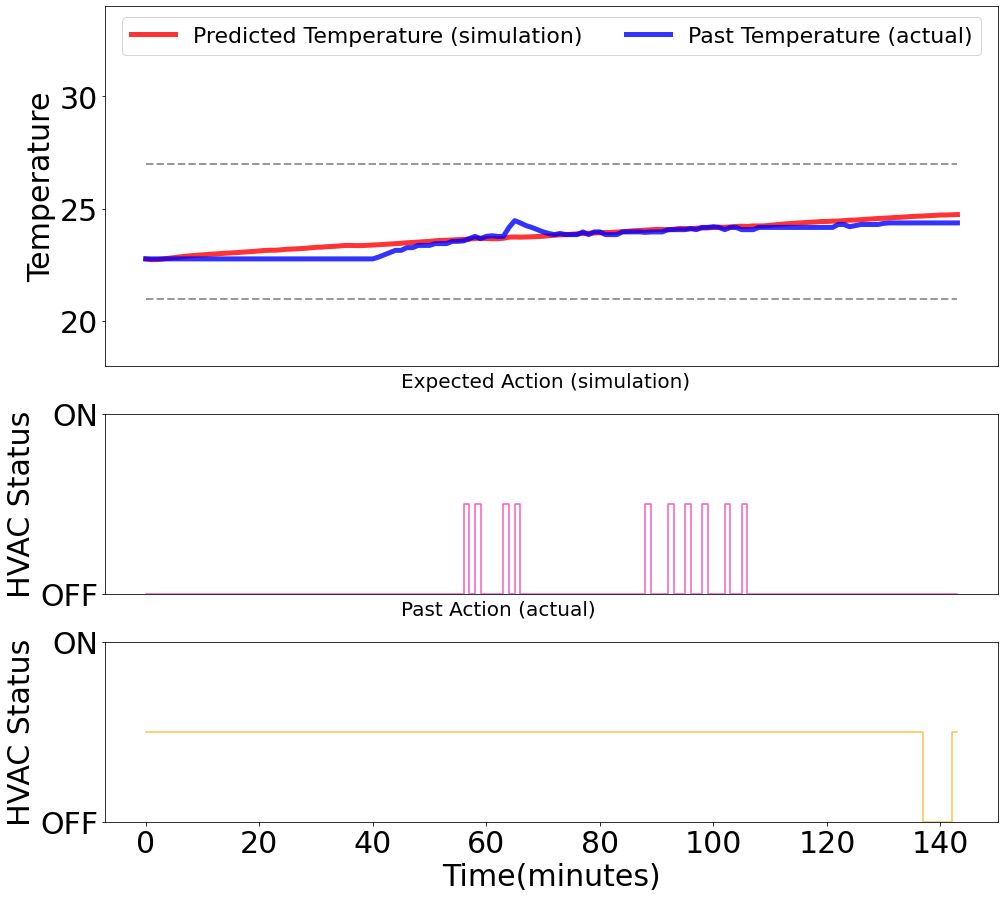

139.0
10
1 일 평균 절감율 :  92.80575539568345 실제 평균 온도 :  23.638333333333335 학습 평균 온도 :  23.800605691901108 오차율 :  -0.16227235856777256
/raid/deallab/ecm/model_result/2019-09-03/20190903w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-03 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  18 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  25.011921661698235


<Figure size 432x288 with 0 Axes>

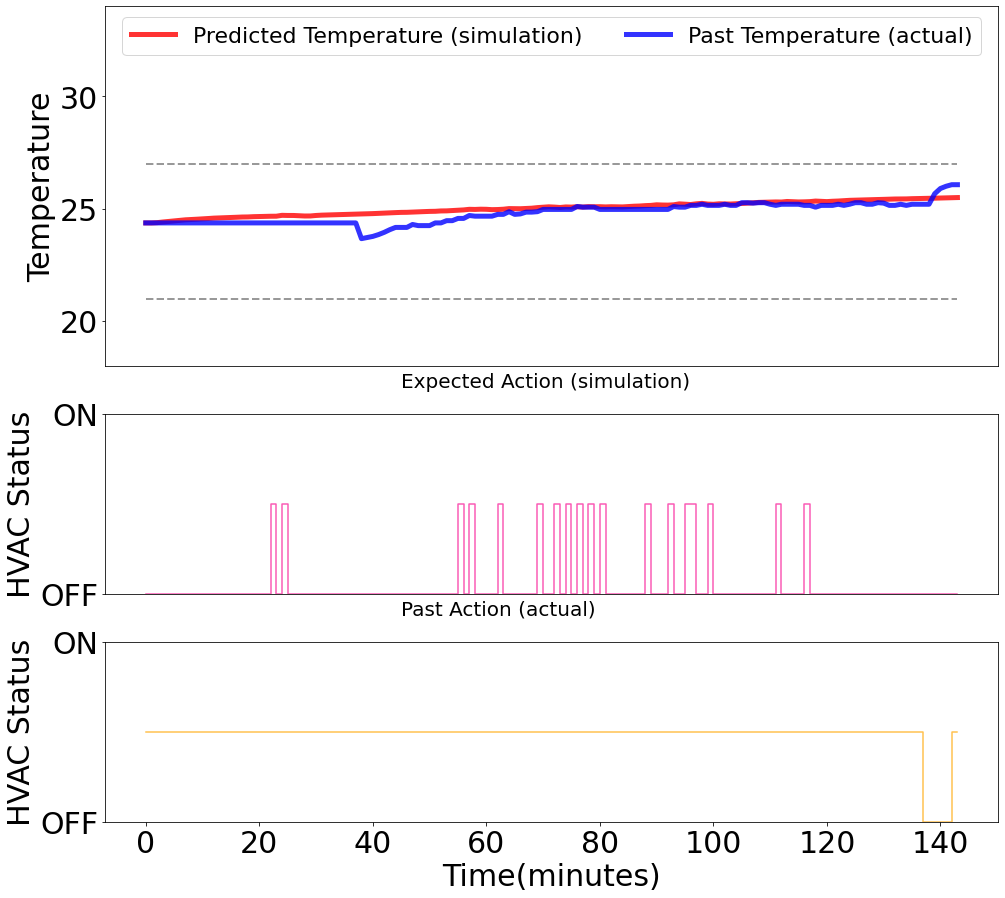

139.0
18
1 일 평균 절감율 :  87.05035971223022 실제 평균 온도 :  24.793124999999982 학습 평균 온도 :  25.011921661698235 오차율 :  -0.21879666169825285
/raid/deallab/ecm/model_result/2019-09-04/20190904w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-04 실제 데이터 길이 :  144  : real action :  130.0 , expected action :  2 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.839532938344888


<Figure size 432x288 with 0 Axes>

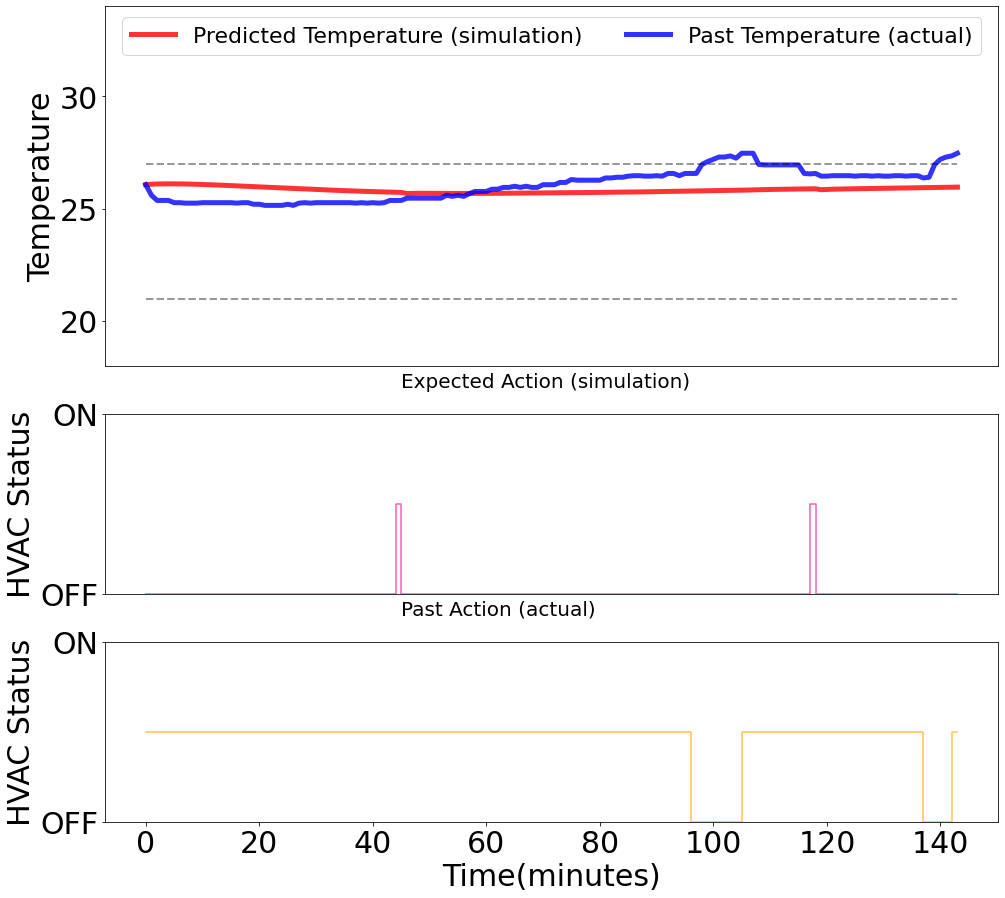

130.0
2
1 일 평균 절감율 :  98.46153846153847 실제 평균 온도 :  26.05597222222217 학습 평균 온도 :  25.839532938344888 오차율 :  0.21643928387728195
/raid/deallab/ecm/model_result/2019-09-05/20190905w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 27.37
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
2019-09-05 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  58 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.77004826780443


<Figure size 432x288 with 0 Axes>

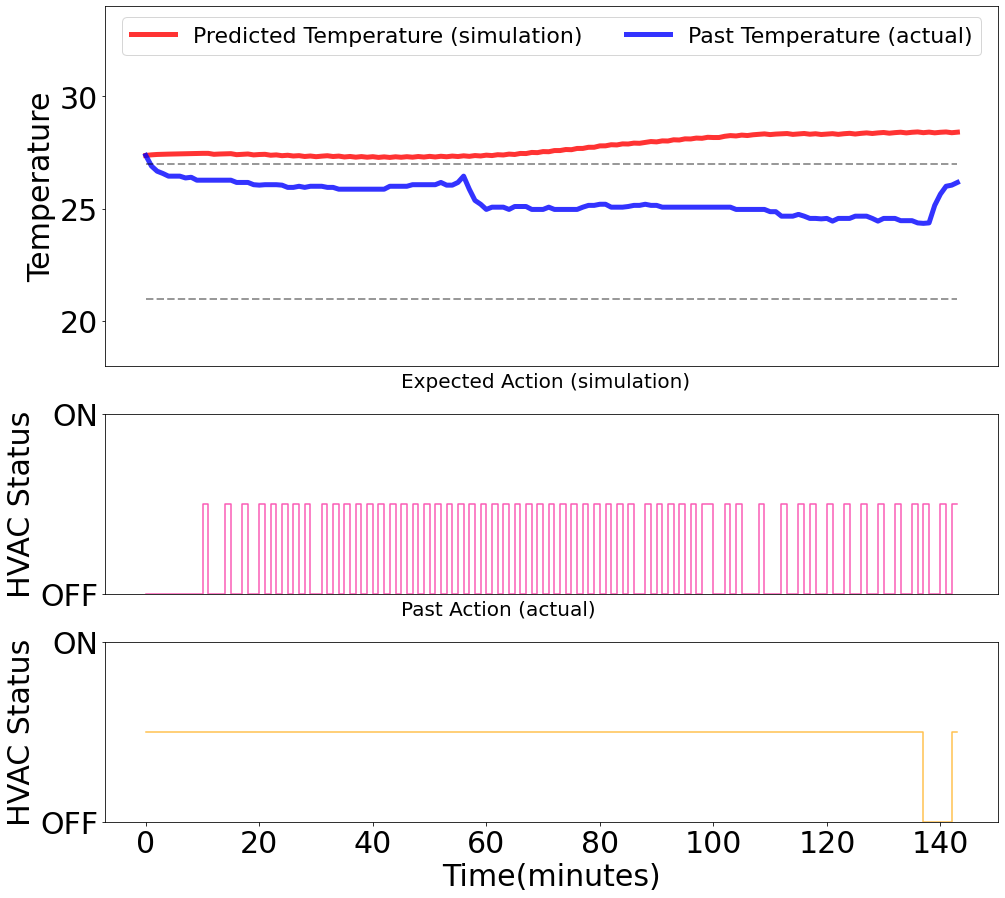

139.0
58
1 일 평균 절감율 :  58.27338129496403 실제 평균 온도 :  25.426458333333343 학습 평균 온도 :  27.77004826780443 오차율 :  -2.343589934471087
/raid/deallab/ecm/model_result/2019-09-06/20190906w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-06 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  37 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  27.88862504497919


<Figure size 432x288 with 0 Axes>

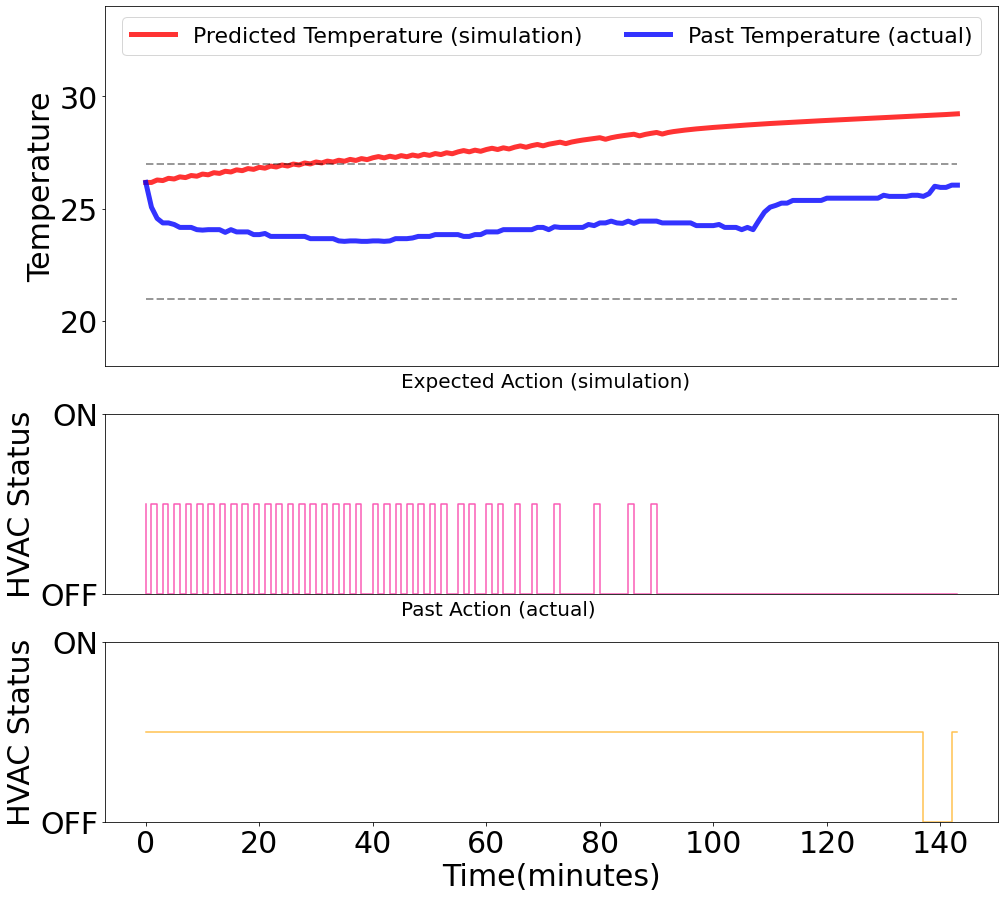

139.0
37
1 일 평균 절감율 :  73.38129496402878 실제 평균 온도 :  24.405972222222196 학습 평균 온도 :  27.88862504497919 오차율 :  -3.482652822756993
/raid/deallab/ecm/model_result/2019-09-07/20190907w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
2019-09-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  73 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.305139089879983


<Figure size 432x288 with 0 Axes>

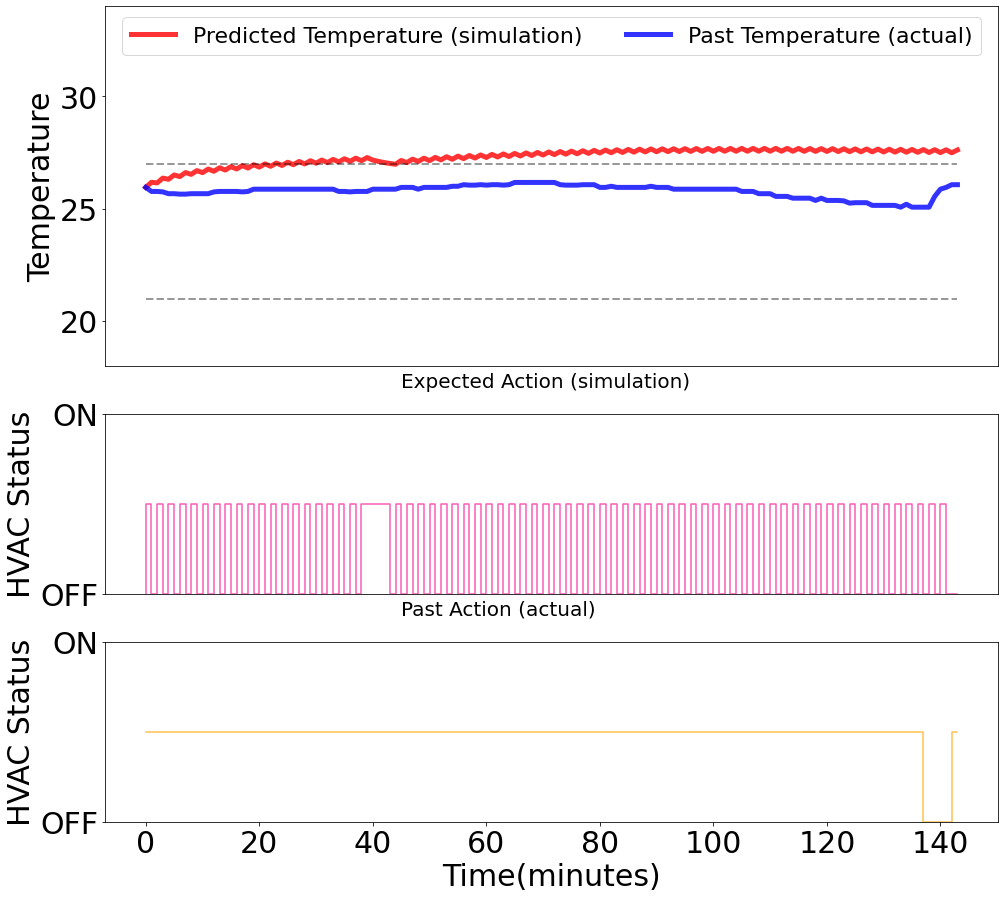

139.0
73
1 일 평균 절감율 :  47.482014388489205 실제 평균 온도 :  25.782152777777753 학습 평균 온도 :  27.305139089879983 오차율 :  -1.5229863121022298
/raid/deallab/ecm/model_result/2019-09-08/20190908w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.05
[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-08 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  5 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  27.971905543029347


<Figure size 432x288 with 0 Axes>

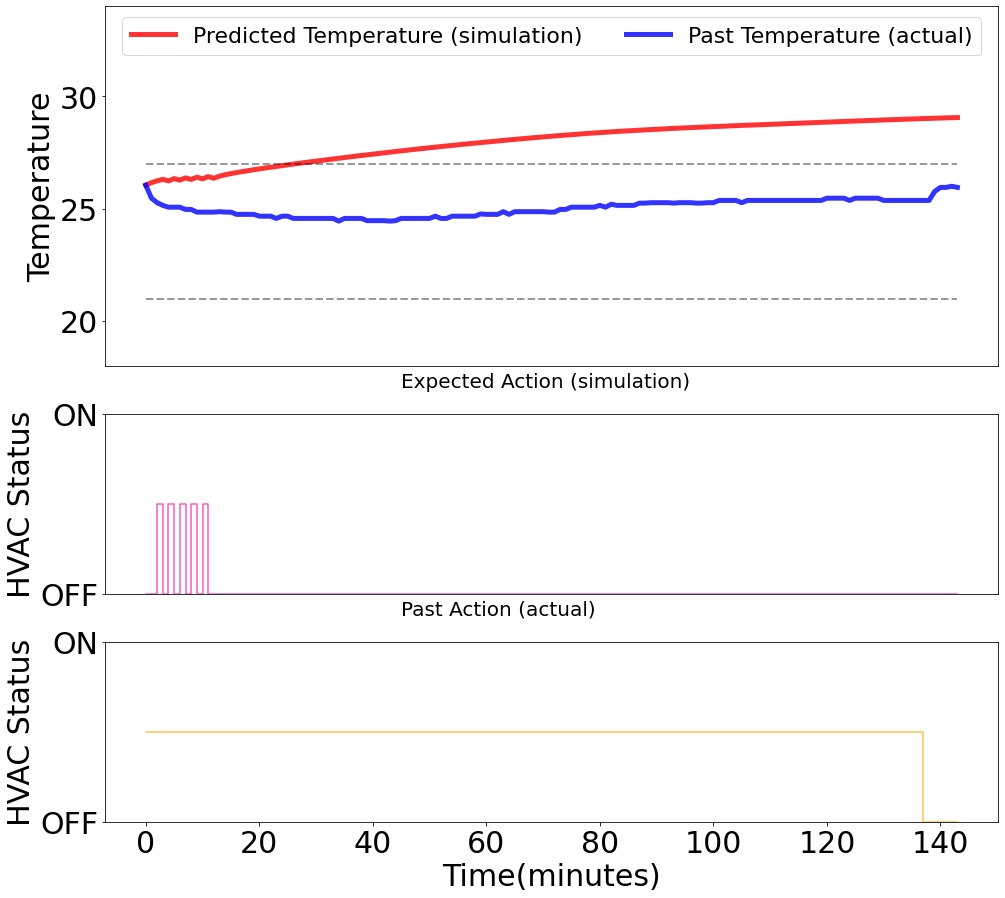

138.0
5
1 일 평균 절감율 :  96.37681159420289 실제 평균 온도 :  25.039444444444403 학습 평균 온도 :  27.971905543029347 오차율 :  -2.9324610985849446
/raid/deallab/ecm/model_result/2019-09-09/20190909w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-09 실제 데이터 길이 :  144  : real action :  140.0 , expected action :  28 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  27.689070020070275


<Figure size 432x288 with 0 Axes>

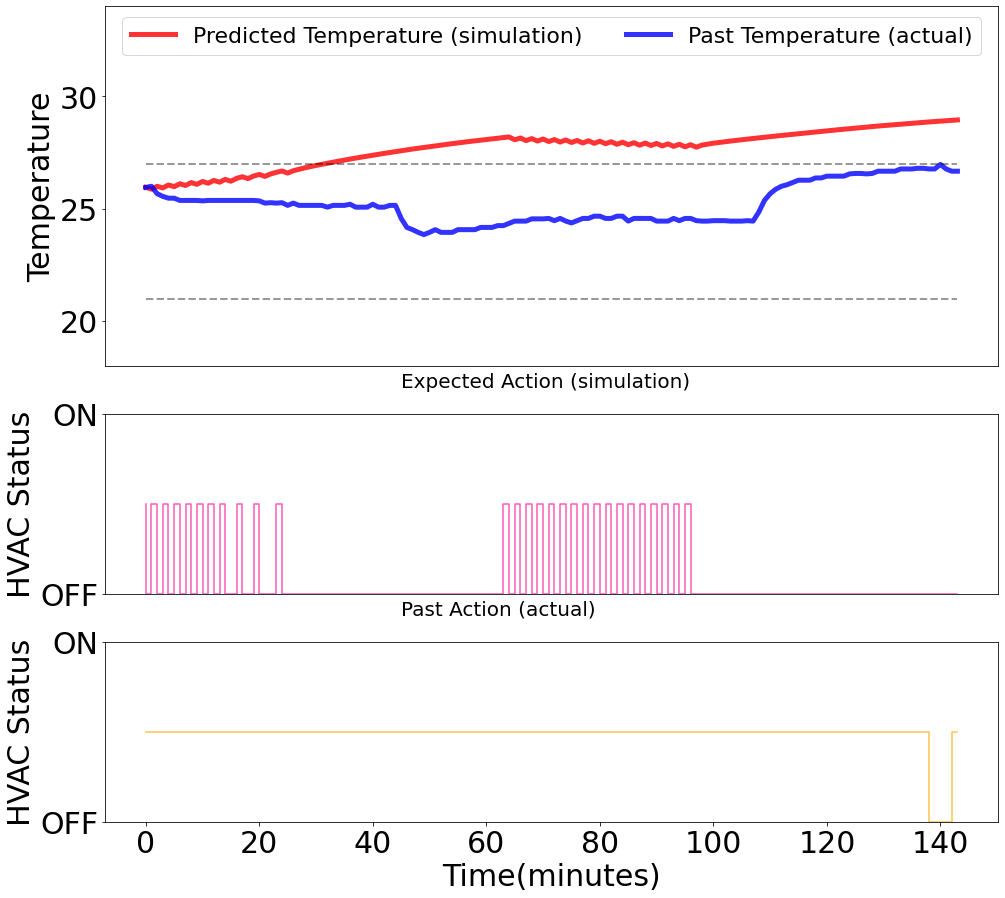

140.0
28
1 일 평균 절감율 :  80.0 실제 평균 온도 :  25.180833333333325 학습 평균 온도 :  27.689070020070275 오차율 :  -2.50823668673695
/raid/deallab/ecm/model_result/2019-09-10/20190910w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.77
[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  106 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  26.36199540205823


<Figure size 432x288 with 0 Axes>

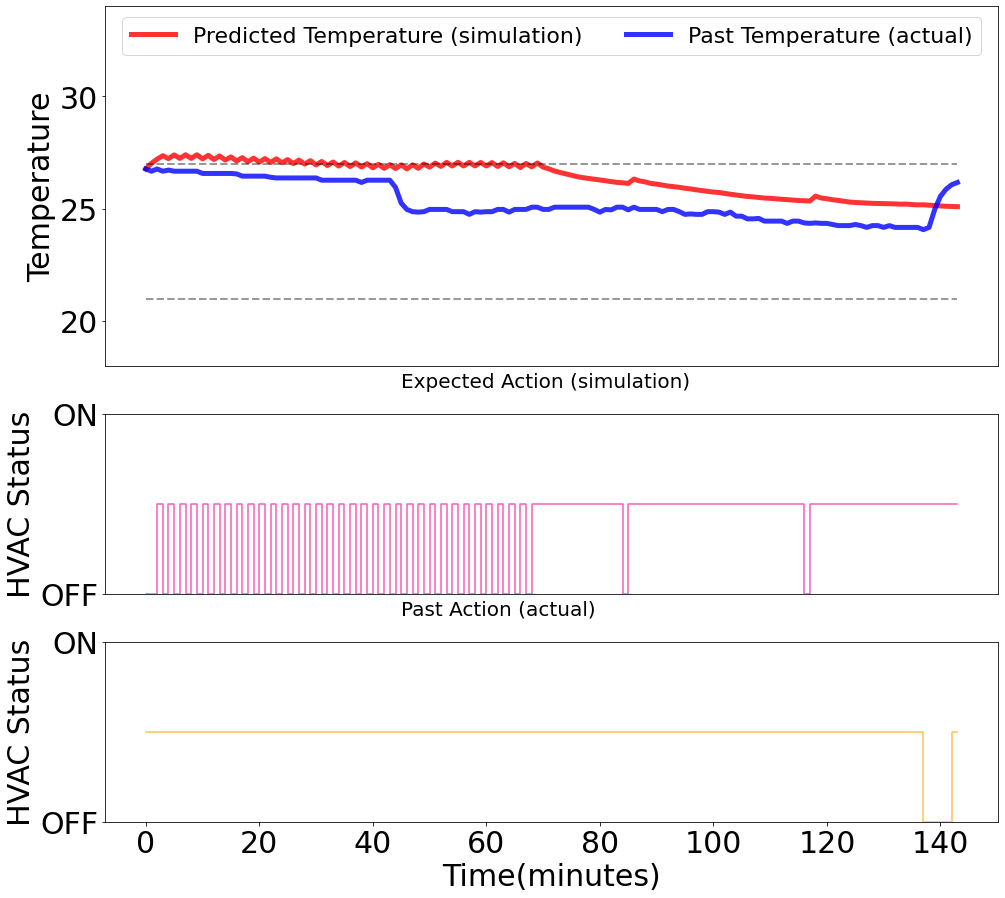

139.0
106
1 일 평균 절감율 :  23.741007194244602 실제 평균 온도 :  25.288888888888867 학습 평균 온도 :  26.36199540205823 오차율 :  -1.073106513169364
/raid/deallab/ecm/model_result/2019-09-11/20190911w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-09-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  79 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.567147134560365


<Figure size 432x288 with 0 Axes>

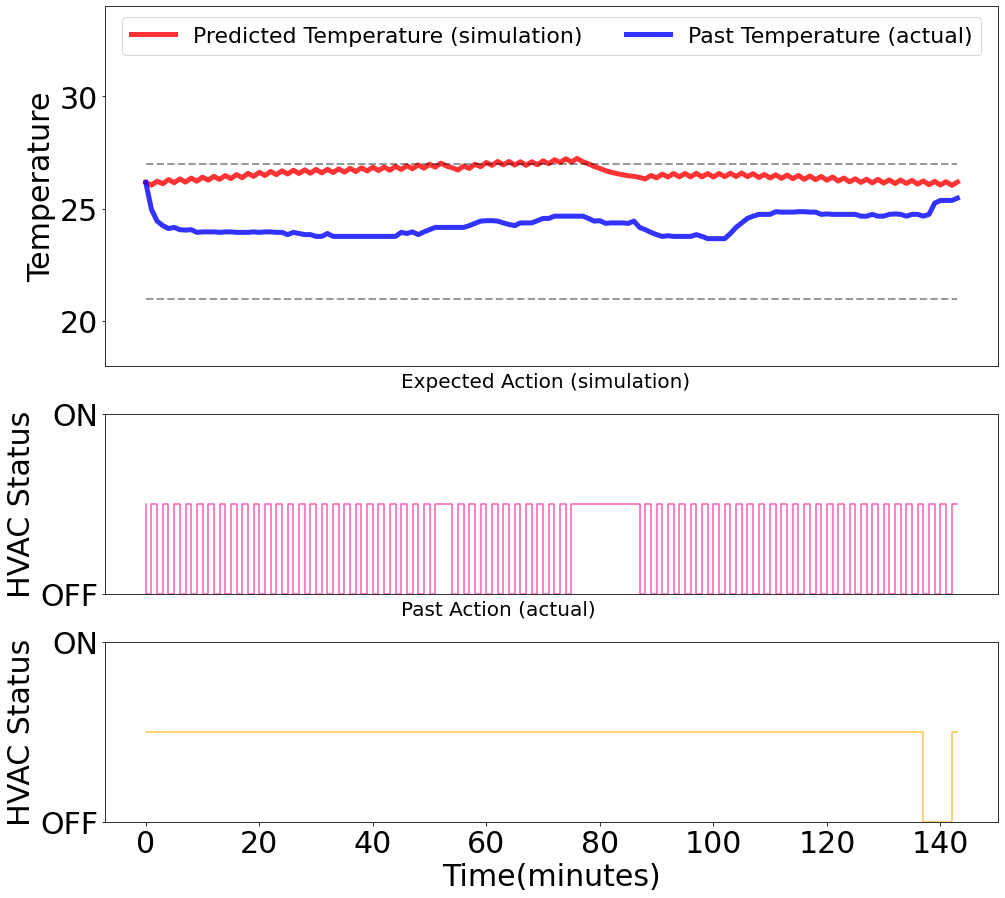

139.0
79
1 일 평균 절감율 :  43.16546762589928 실제 평균 온도 :  24.302152777777774 학습 평균 온도 :  26.567147134560365 오차율 :  -2.2649943567825908
/raid/deallab/ecm/model_result/2019-09-12/20190912w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.47
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  40 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.353725546271633


<Figure size 432x288 with 0 Axes>

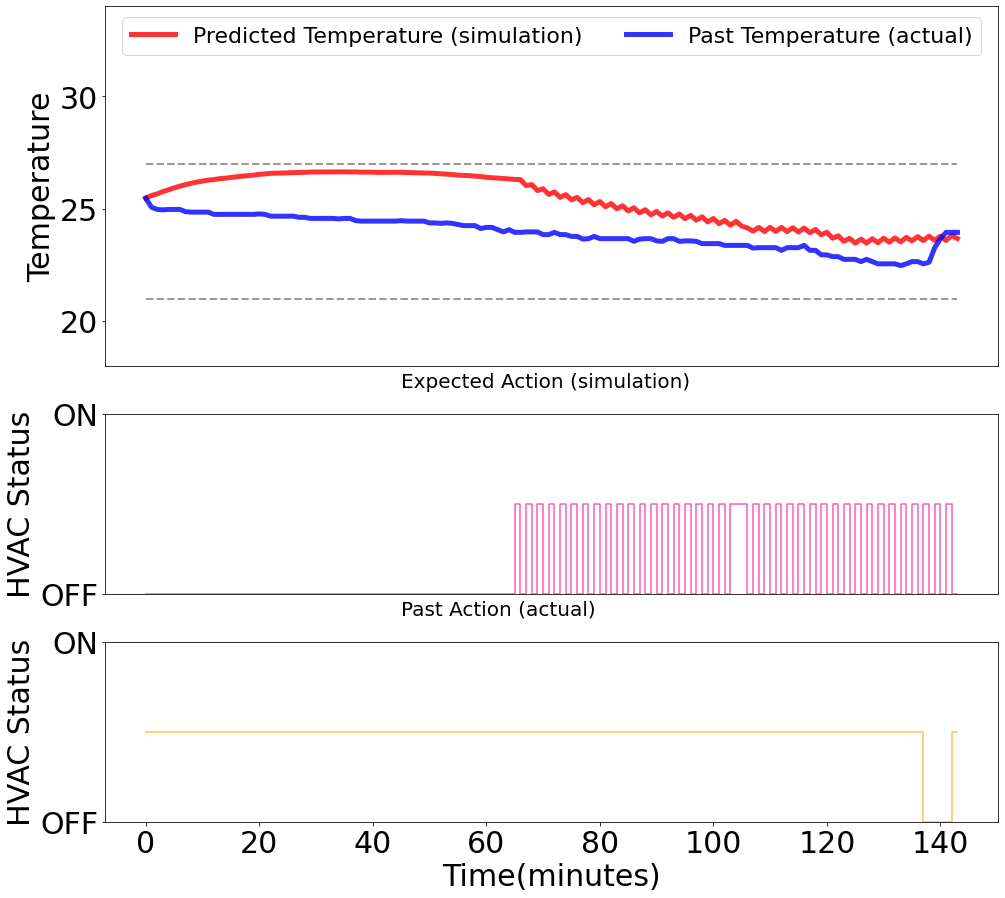

139.0
40
1 일 평균 절감율 :  71.22302158273382 실제 평균 온도 :  23.907569444444448 학습 평균 온도 :  25.353725546271633 오차율 :  -1.4461561018271851
/raid/deallab/ecm/model_result/2019-09-13/20190913w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.95
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.053458734825


<Figure size 432x288 with 0 Axes>

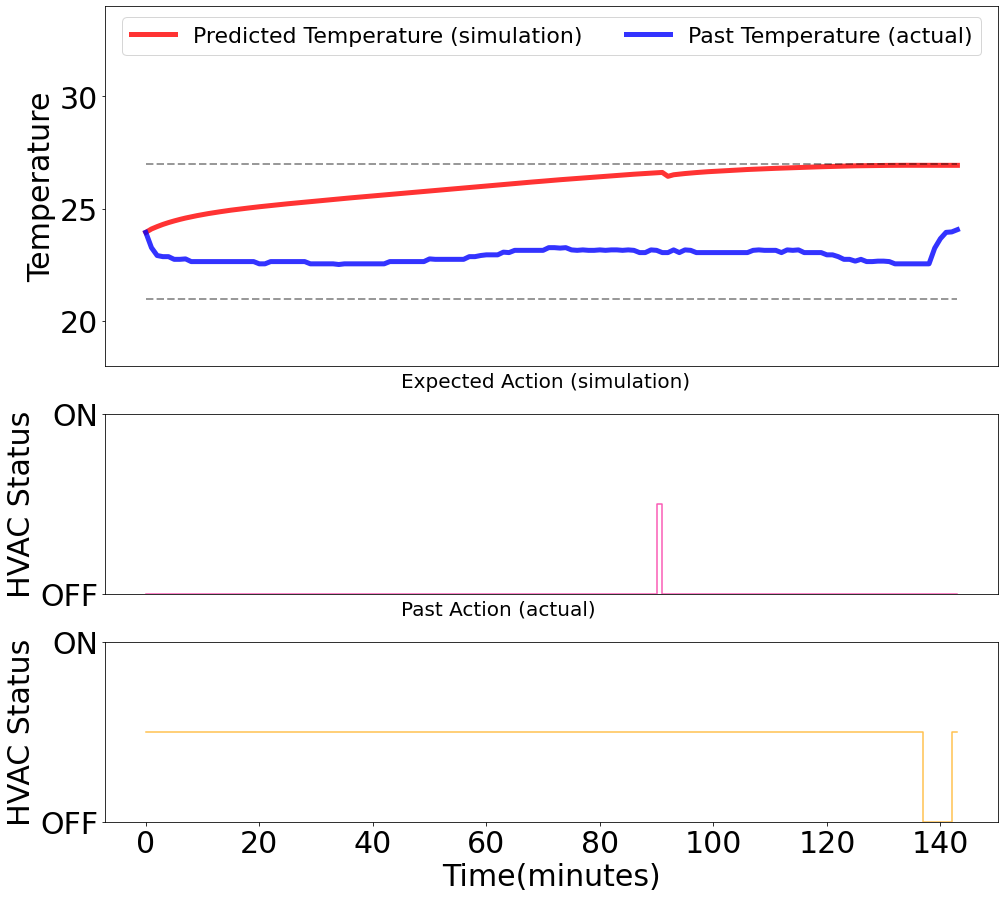

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  22.905625000000043 학습 평균 온도 :  26.053458734825 오차율 :  -3.1478337348249568
/raid/deallab/ecm/model_result/2019-09-14/20190914w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-09-14 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  49 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  24.925364475280887


<Figure size 432x288 with 0 Axes>

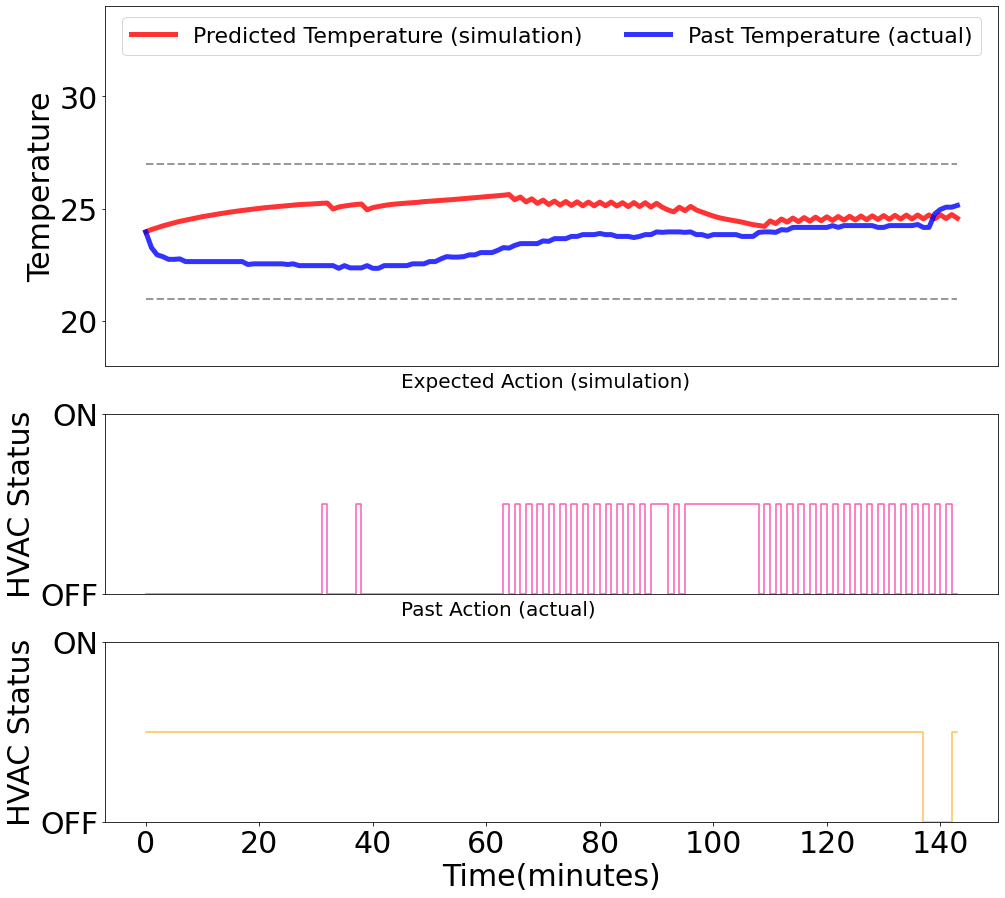

139.0
49
1 일 평균 절감율 :  64.74820143884892 실제 평균 온도 :  23.40687499999999 학습 평균 온도 :  24.925364475280887 오차율 :  -1.518489475280898
/raid/deallab/ecm/model_result/2019-09-15/20190915w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-15 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  16 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.382397703374956


<Figure size 432x288 with 0 Axes>

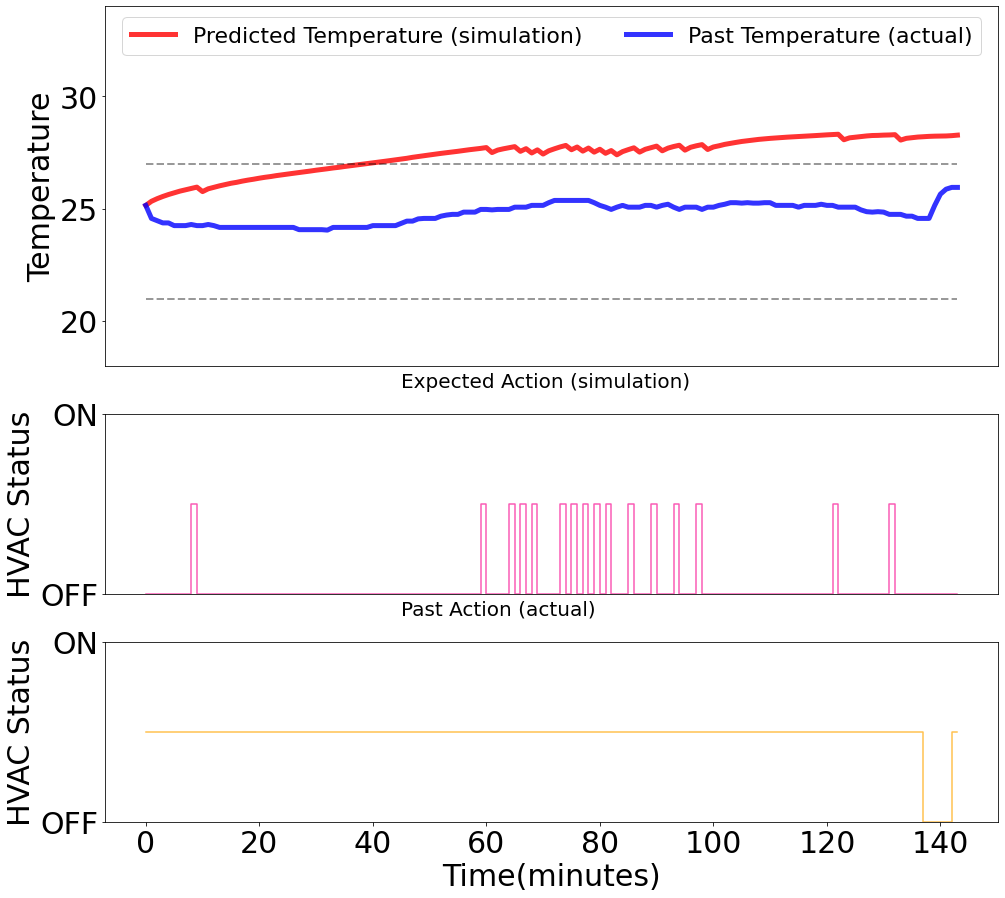

139.0
16
1 일 평균 절감율 :  88.48920863309353 실제 평균 온도 :  24.792361111111124 학습 평균 온도 :  27.382397703374956 오차율 :  -2.590036592263832
/raid/deallab/ecm/model_result/2019-09-16/20190916w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.87
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-16 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  3 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.186081332556327


<Figure size 432x288 with 0 Axes>

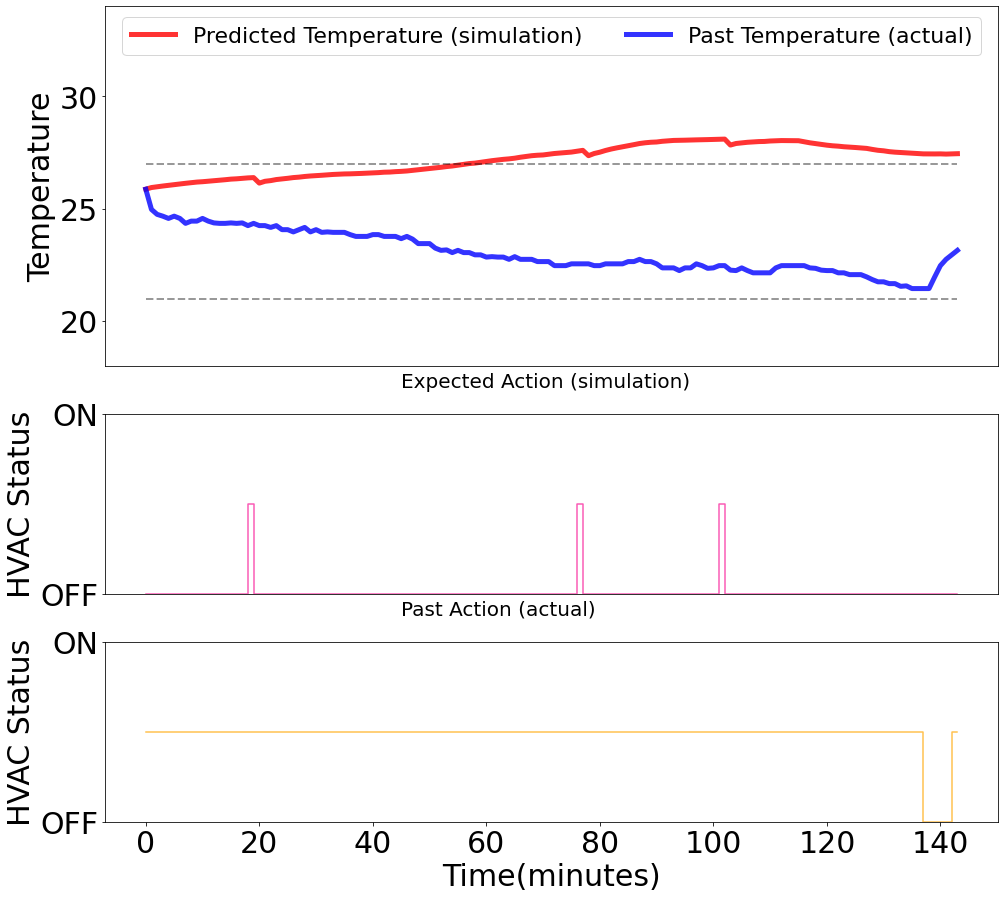

139.0
3
1 일 평균 절감율 :  97.84172661870504 실제 평균 온도 :  23.038611111111102 학습 평균 온도 :  27.186081332556327 오차율 :  -4.147470221445225
/raid/deallab/ecm/model_result/2019-09-17/20190917w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-17 실제 데이터 길이 :  144  : real action :  106.0 , expected action :  13 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.266677987292592


<Figure size 432x288 with 0 Axes>

106.0
13
1 일 평균 절감율 :  87.73584905660378 실제 평균 온도 :  20.71111111111105 학습 평균 온도 :  26.266677987292592 오차율 :  -5.55556687618154
/raid/deallab/ecm/model_result/2019-09-18/20190918w1_linear_regression.joblib
F_SET_MODE_0
Reset data f3_temp : 21.97
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-18 실제 데이터 길이 :  144  : real action :  98.0 , expected action :  143 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578


<Figure size 432x288 with 0 Axes>

98.0
143
1 일 평균 절감율 :  -45.91836734693878 실제 평균 온도 :  21.58861111111112 학습 평균 온도 :  20.735822419252578 오차율 :  0.8527886918585423
/raid/deallab/ecm/model_result/2019-09-19/20190919w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-19 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  142 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  20.581859958861102


<Figure size 432x288 with 0 Axes>

139.0
142
1 일 평균 절감율 :  -2.158273381294964 실제 평균 온도 :  20.312569444444435 학습 평균 온도 :  20.581859958861102 오차율 :  -0.2692905144166673
/raid/deallab/ecm/model_result/2019-09-20/20190920w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-20 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  143 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  20.38981534006944


<Figure size 432x288 with 0 Axes>

139.0
143
1 일 평균 절감율 :  -2.877697841726619 실제 평균 온도 :  20.338472222222222 학습 평균 온도 :  20.38981534006944 오차율 :  -0.051343117847217457
/raid/deallab/ecm/model_result/2019-09-21/20190921w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-21 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  4 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.011500040166275


<Figure size 432x288 with 0 Axes>

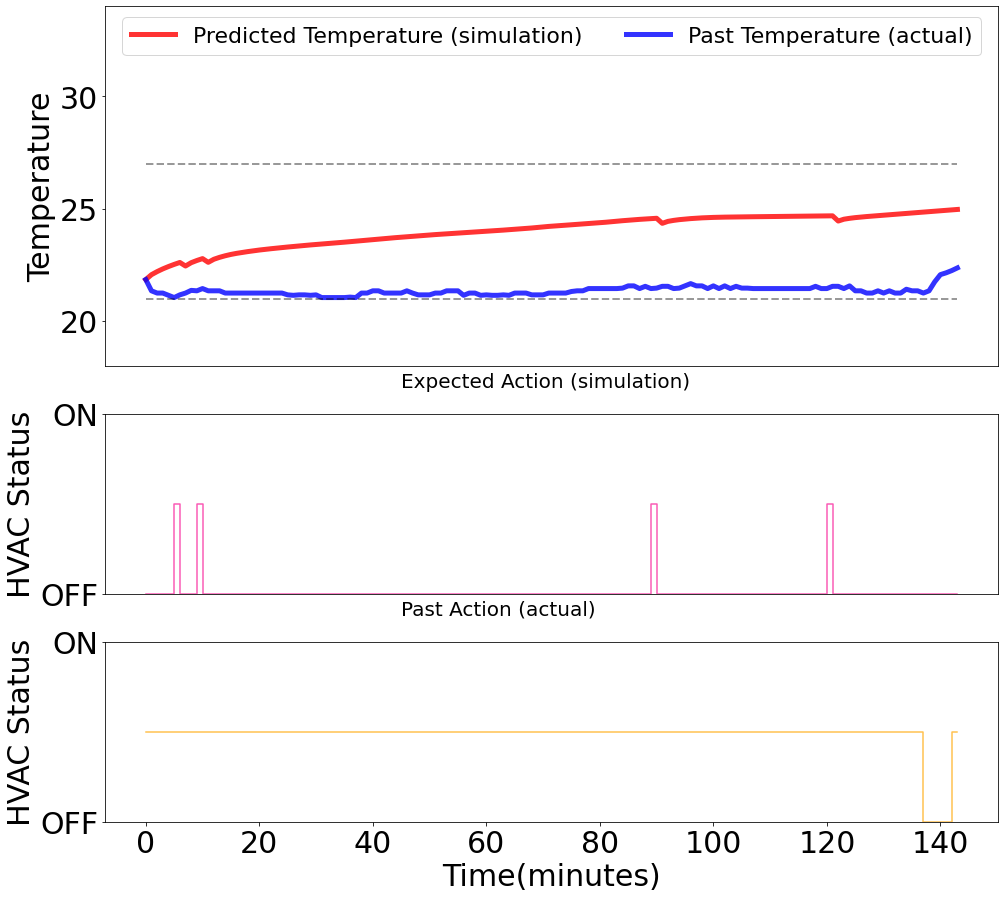

139.0
4
1 일 평균 절감율 :  97.12230215827337 실제 평균 온도 :  21.357361111111096 학습 평균 온도 :  24.011500040166275 오차율 :  -2.654138929055179
/raid/deallab/ecm/model_result/2019-09-22/20190922w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.15
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-22 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  3 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.889144804609927


<Figure size 432x288 with 0 Axes>

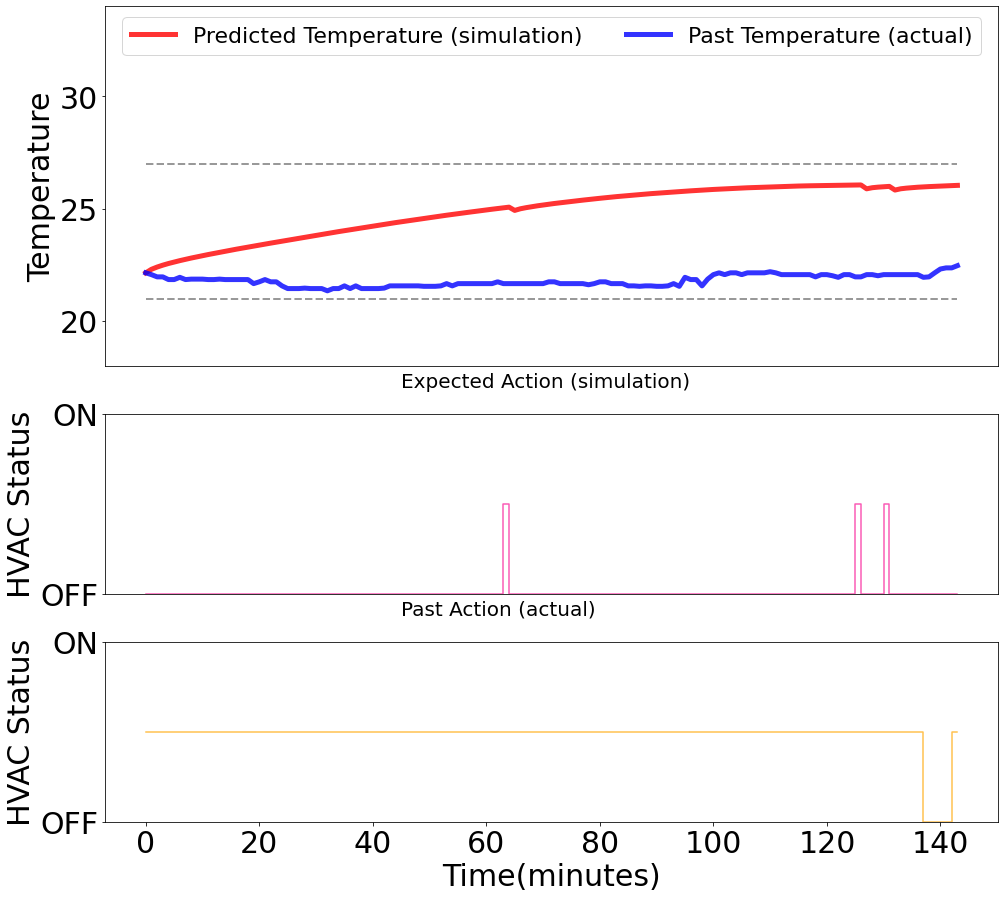

139.0
3
1 일 평균 절감율 :  97.84172661870504 실제 평균 온도 :  21.800625000000032 학습 평균 온도 :  24.889144804609927 오차율 :  -3.088519804609895
/raid/deallab/ecm/model_result/2019-09-23/20190923w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.25
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-23 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  26 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.305474464900385


<Figure size 432x288 with 0 Axes>

139.0
26
1 일 평균 절감율 :  81.29496402877699 실제 평균 온도 :  21.74673611111113 학습 평균 온도 :  23.305474464900385 오차율 :  -1.5587383537892556
/raid/deallab/ecm/model_result/2019-09-24/20190924w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.97
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-24 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  73 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  22.34627903590124


<Figure size 432x288 with 0 Axes>

138.0
73
1 일 평균 절감율 :  47.10144927536232 실제 평균 온도 :  21.069166666666646 학습 평균 온도 :  22.34627903590124 오차율 :  -1.2771123692345938
/raid/deallab/ecm/model_result/2019-09-25/20190925w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.25
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-09-25 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  143 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  20.14077522038642


<Figure size 432x288 with 0 Axes>

138.0
143
1 일 평균 절감율 :  -3.6231884057971016 실제 평균 온도 :  19.939027777777756 학습 평균 온도 :  20.14077522038642 오차율 :  -0.20174744260866362
/raid/deallab/ecm/model_result/2019-09-26/20190926w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.45
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
2019-09-26 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  122 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  20.93636337245353


<Figure size 432x288 with 0 Axes>

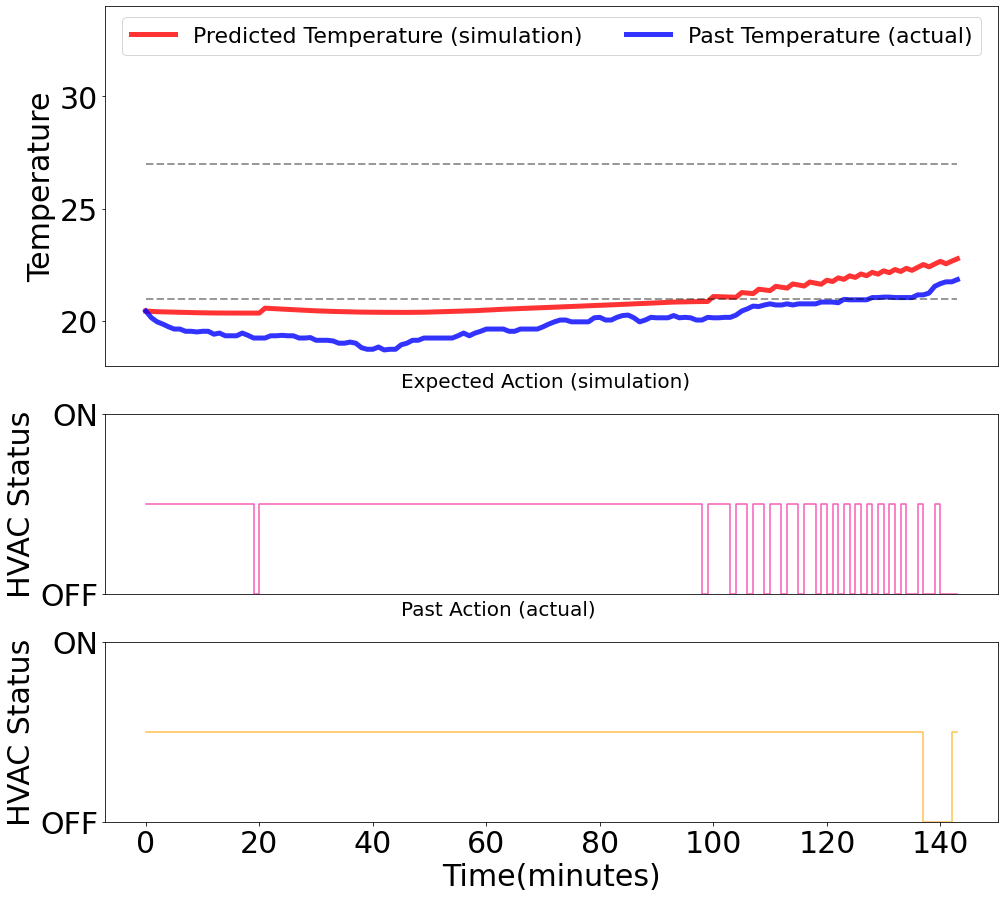

139.0
122
1 일 평균 절감율 :  12.23021582733813 실제 평균 온도 :  19.976111111111123 학습 평균 온도 :  20.93636337245353 오차율 :  -0.9602522613424078
/raid/deallab/ecm/model_result/2019-09-27/20190927w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-27 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  6 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.293547213025953


<Figure size 432x288 with 0 Axes>

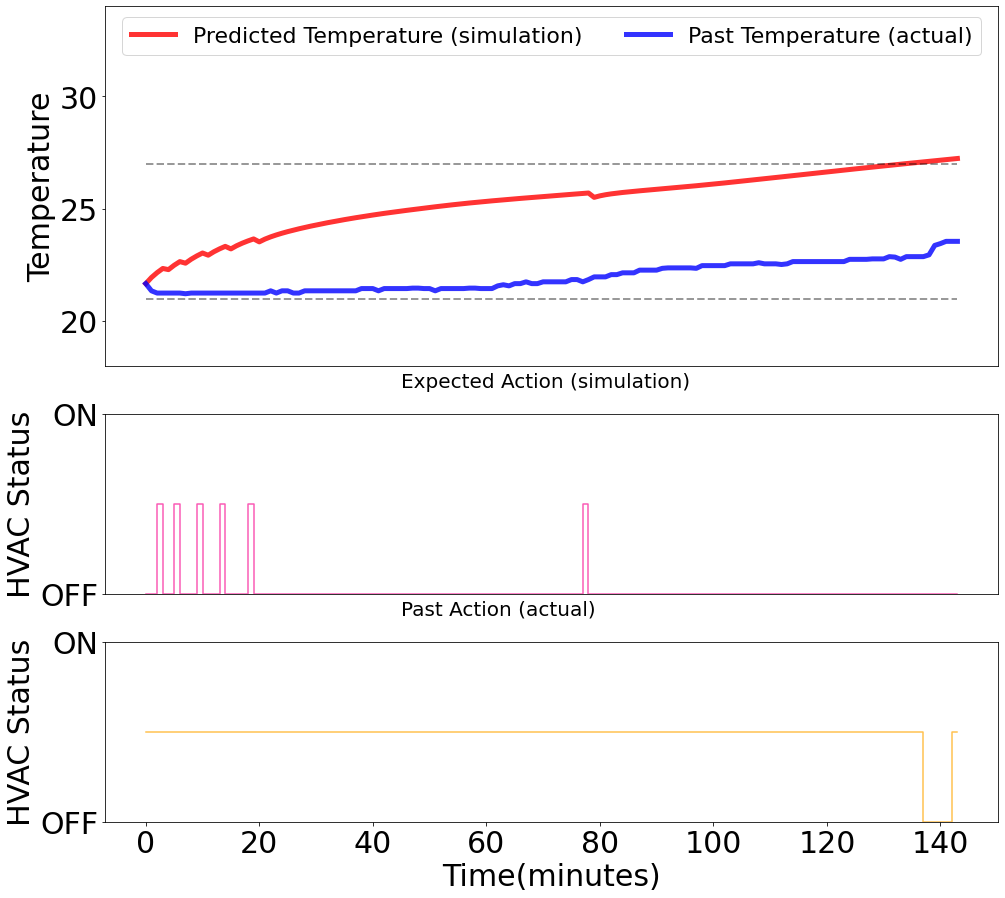

139.0
6
1 일 평균 절감율 :  95.68345323741008 실제 평균 온도 :  21.957916666666677 학습 평균 온도 :  25.293547213025953 오차율 :  -3.335630546359276
/raid/deallab/ecm/model_result/2019-09-28/20190928w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 23.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-28 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  3 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.77581837156902


<Figure size 432x288 with 0 Axes>

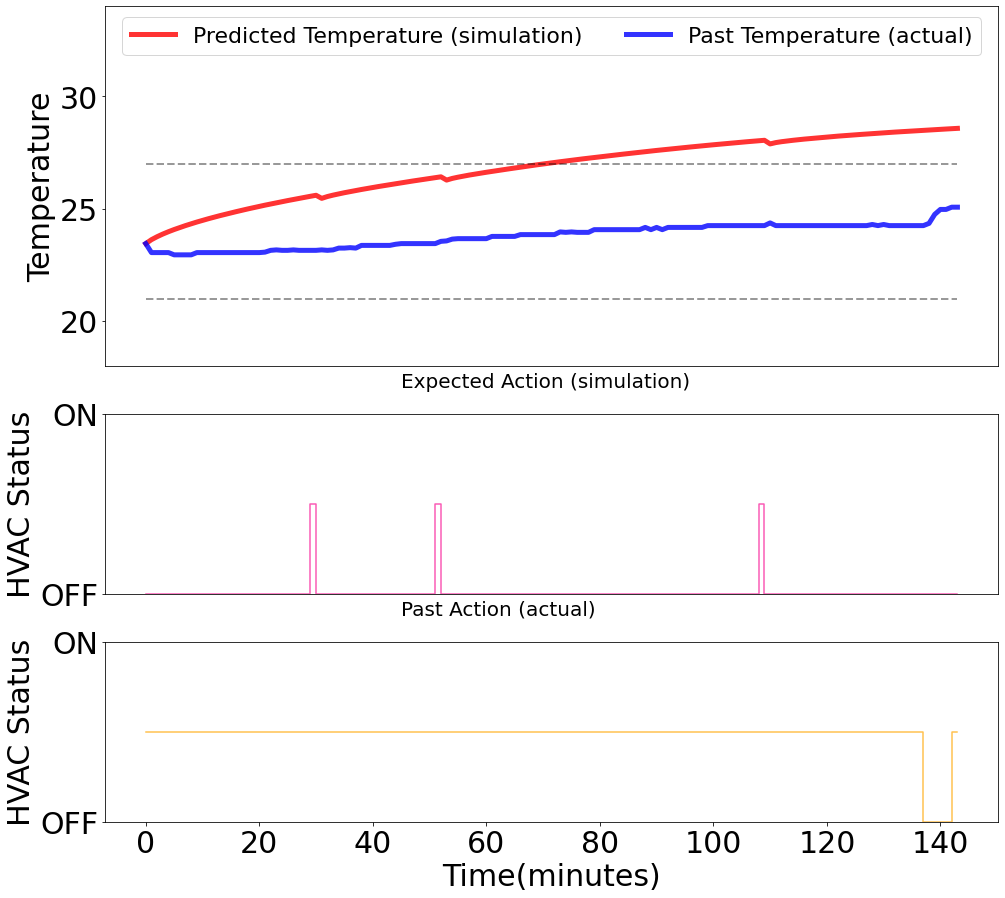

139.0
3
1 일 평균 절감율 :  97.84172661870504 실제 평균 온도 :  23.78881944444445 학습 평균 온도 :  26.77581837156902 오차율 :  -2.9869989271245707
/raid/deallab/ecm/model_result/2019-09-29/20190929w1_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.87
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-29 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.7360001892306


<Figure size 432x288 with 0 Axes>

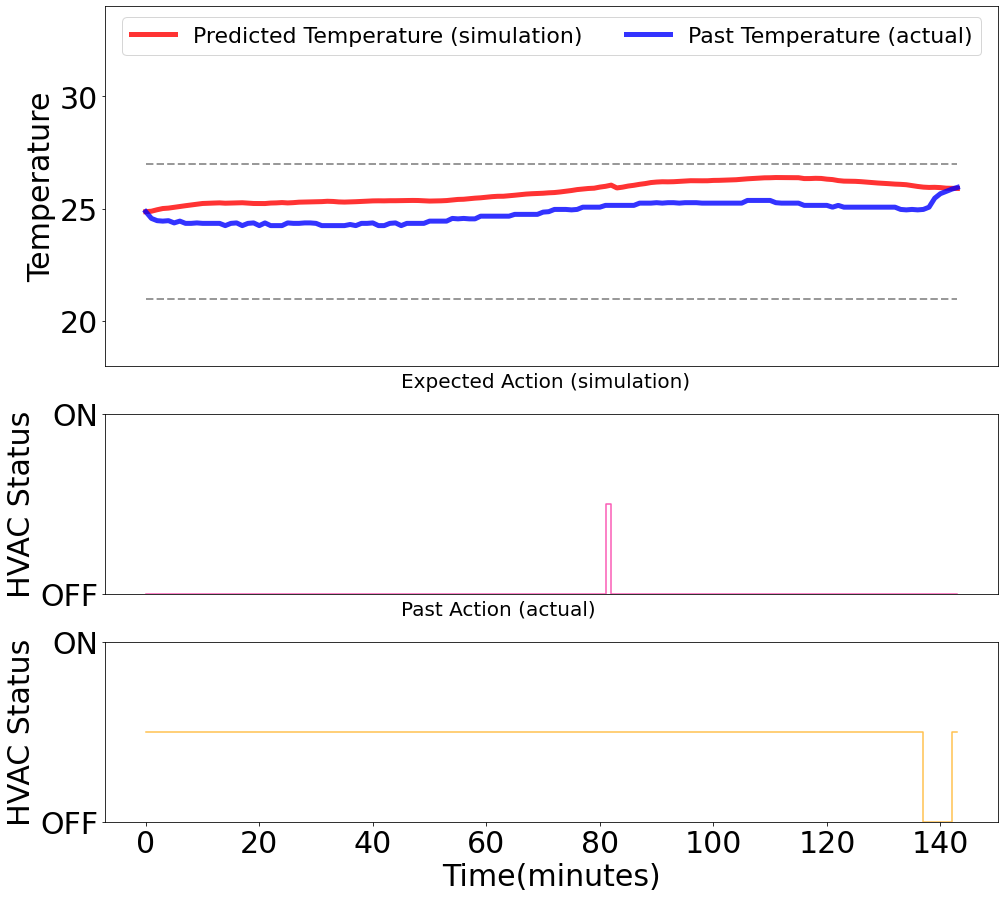

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  24.81729166666667 학습 평균 온도 :  25.7360001892306 오차율 :  -0.9187085225639322
/raid/deallab/ecm/model_result/2019-09-30/20190930w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.65
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-09-30 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  2 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.35225956367743


<Figure size 432x288 with 0 Axes>

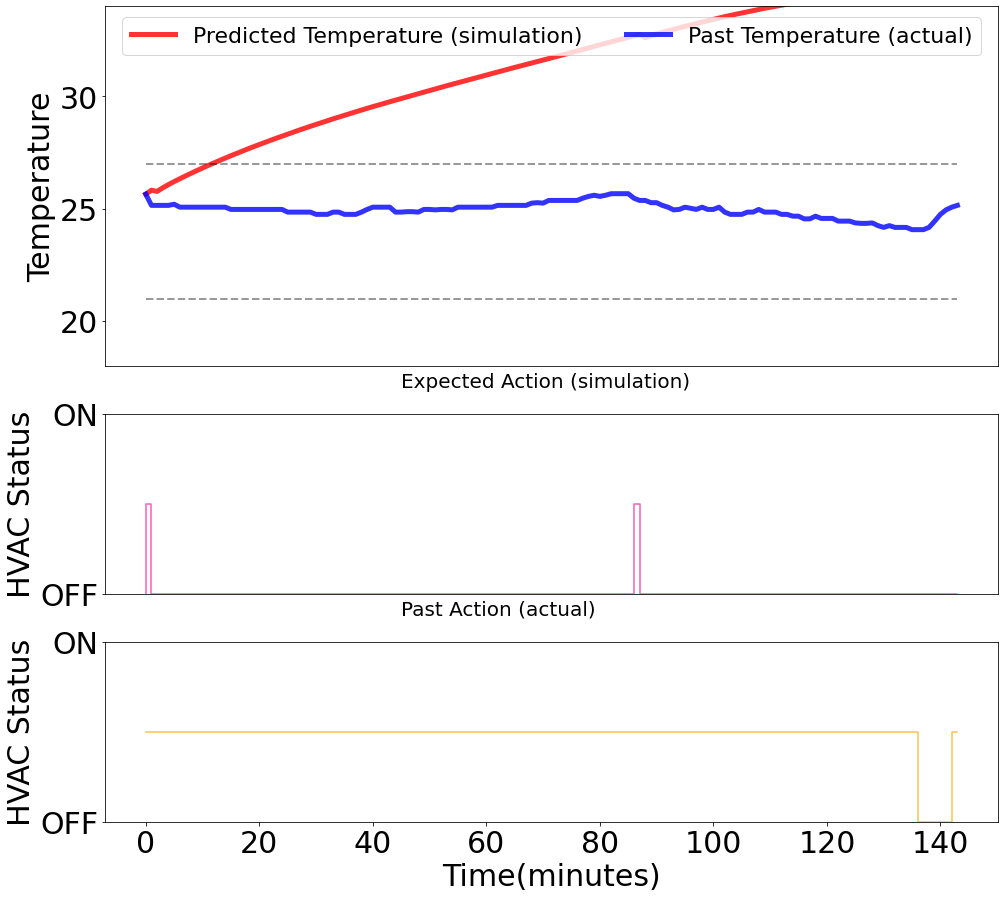

138.0
2
1 일 평균 절감율 :  98.55072463768117 실제 평균 온도 :  24.941805555555547 학습 평균 온도 :  31.35225956367743 오차율 :  -6.4104540081218815
/raid/deallab/ecm/model_result/2019-10-01/20191001w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.97
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
2019-10-01 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  77 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  25.12863977989936


<Figure size 432x288 with 0 Axes>

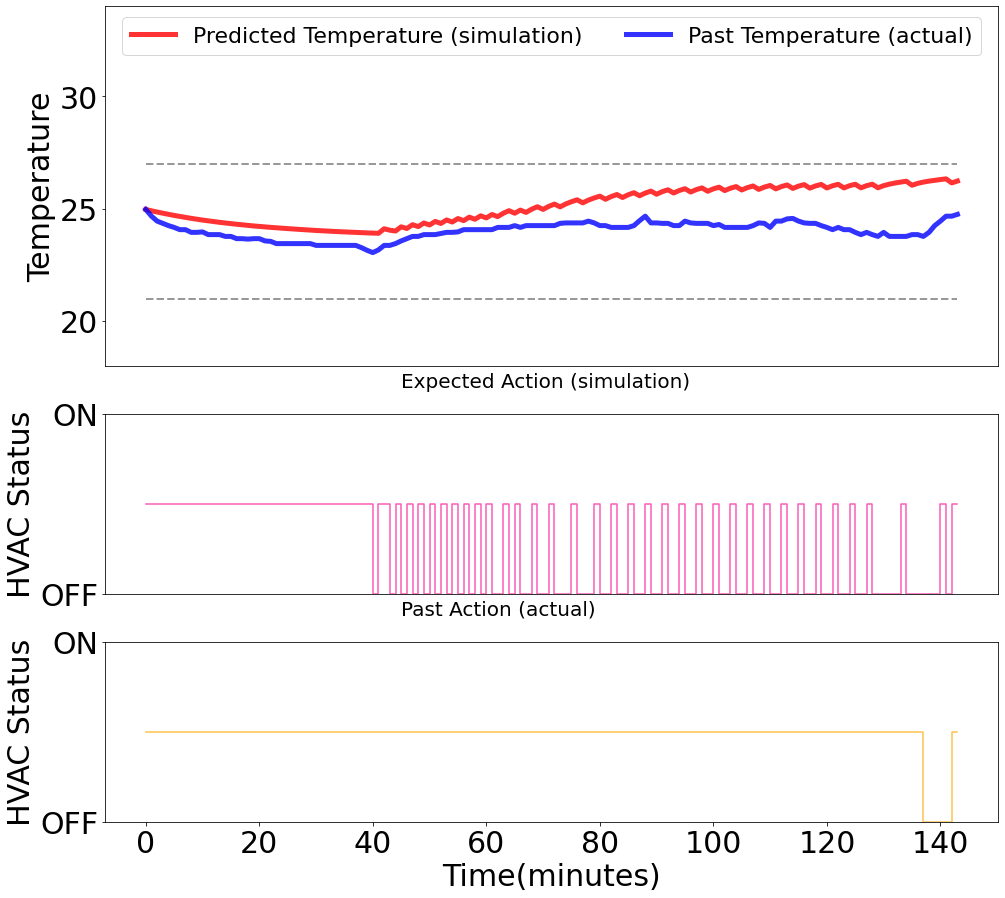

139.0
77
1 일 평균 절감율 :  44.60431654676259 실제 평균 온도 :  24.01958333333332 학습 평균 온도 :  25.12863977989936 오차율 :  -1.10905644656604
/raid/deallab/ecm/model_result/2019-10-02/20191002w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 24.45
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-02 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  1 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.3240948967822


<Figure size 432x288 with 0 Axes>

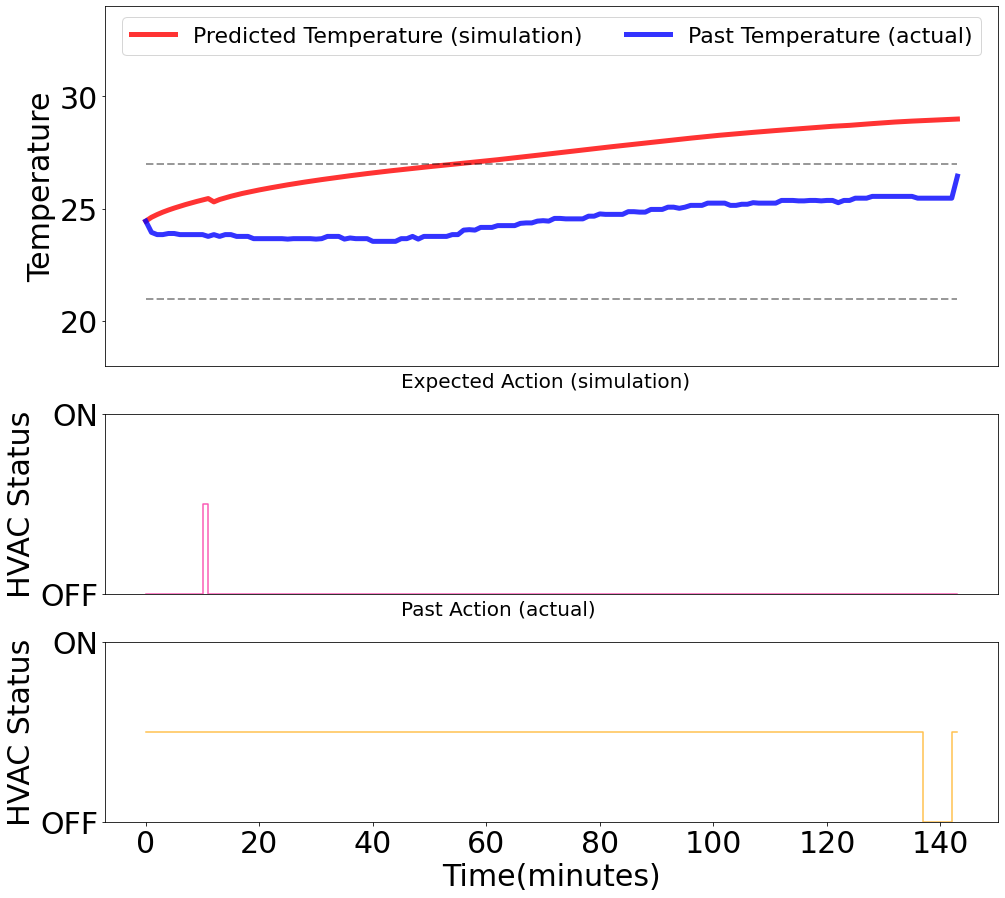

139.0
1
1 일 평균 절감율 :  99.28057553956835 실제 평균 온도 :  24.525972222222197 학습 평균 온도 :  27.3240948967822 오차율 :  -2.798122674560002
/raid/deallab/ecm/model_result/2019-10-03/20191003w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 26.17
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
2019-10-03 실제 데이터 길이 :  144  : real action :  97.5 , expected action :  81 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  26.112440949201552


<Figure size 432x288 with 0 Axes>

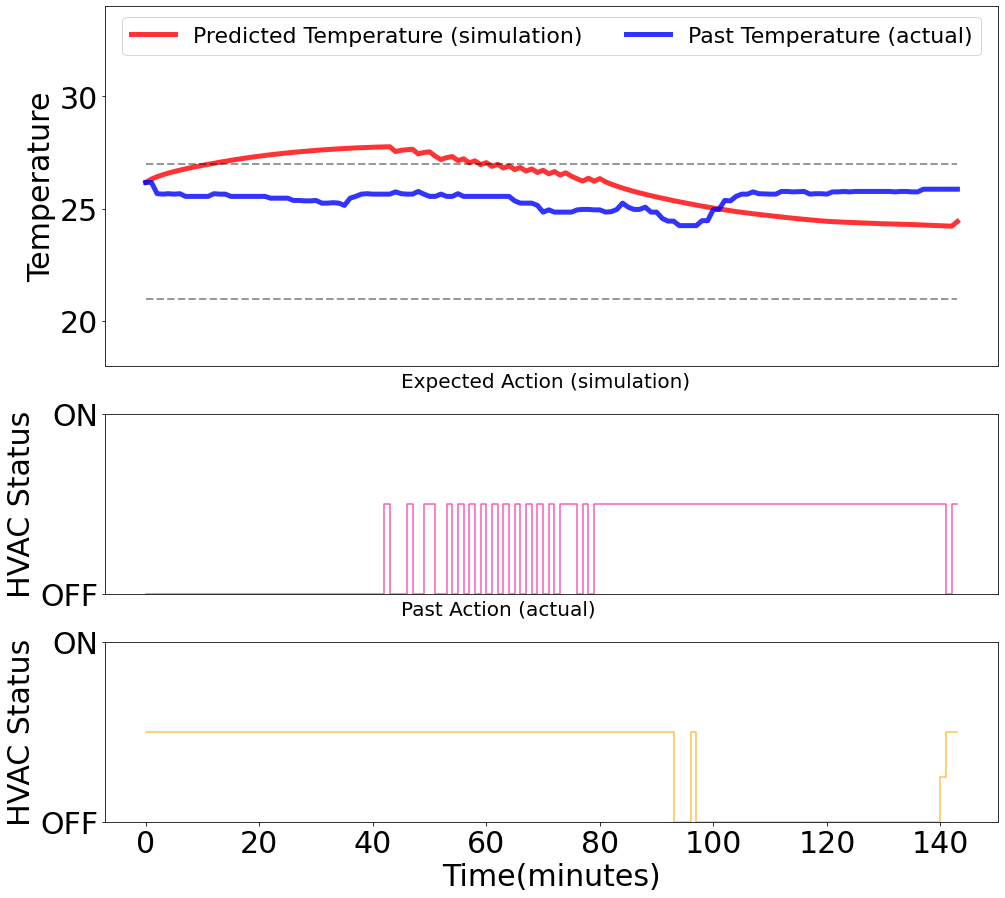

97.5
81
1 일 평균 절감율 :  16.923076923076923 실제 평균 온도 :  25.42805555555554 학습 평균 온도 :  26.112440949201552 오차율 :  -0.6843853936460107
/raid/deallab/ecm/model_result/2019-10-04/20191004w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 25.25
[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
2019-10-04 실제 데이터 길이 :  144  : real action :  137.0 , expected action :  71 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.749525034019097


<Figure size 432x288 with 0 Axes>

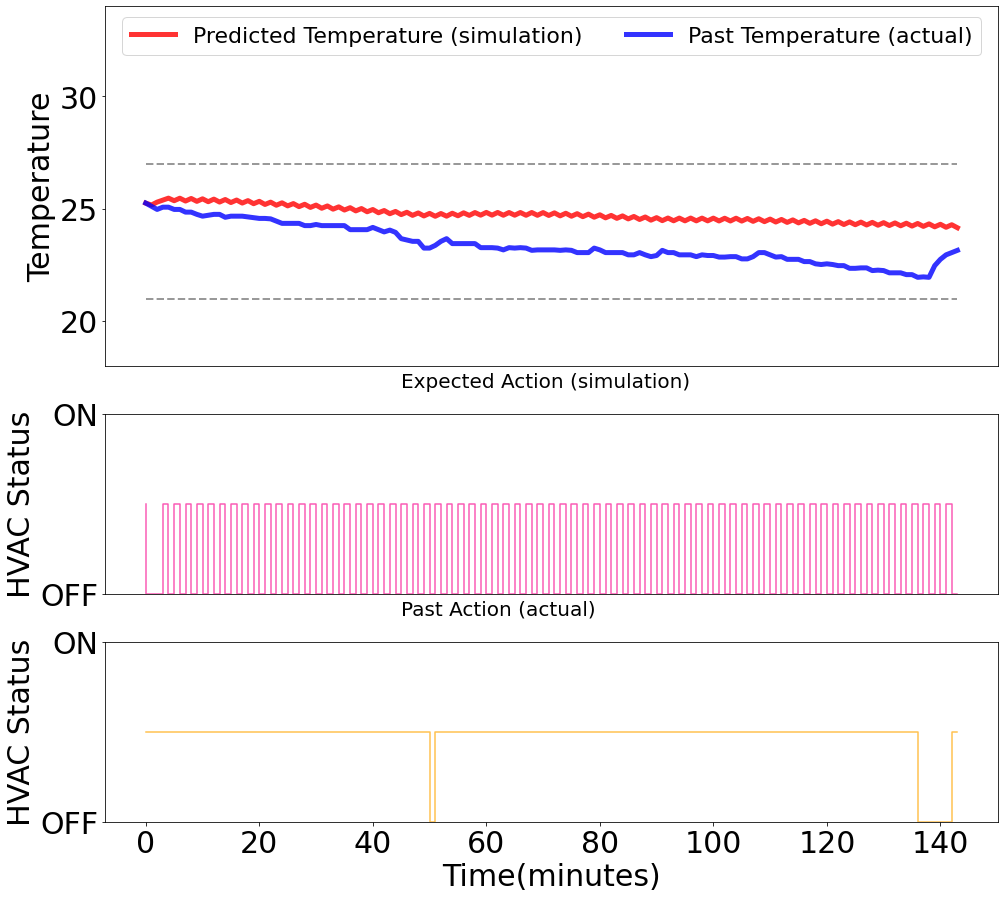

137.0
71
1 일 평균 절감율 :  48.175182481751825 실제 평균 온도 :  23.413124999999994 학습 평균 온도 :  24.749525034019097 오차율 :  -1.3364000340191033
/raid/deallab/ecm/model_result/2019-10-05/20191005w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.85
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-05 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  141 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  22.38238497561737


<Figure size 432x288 with 0 Axes>

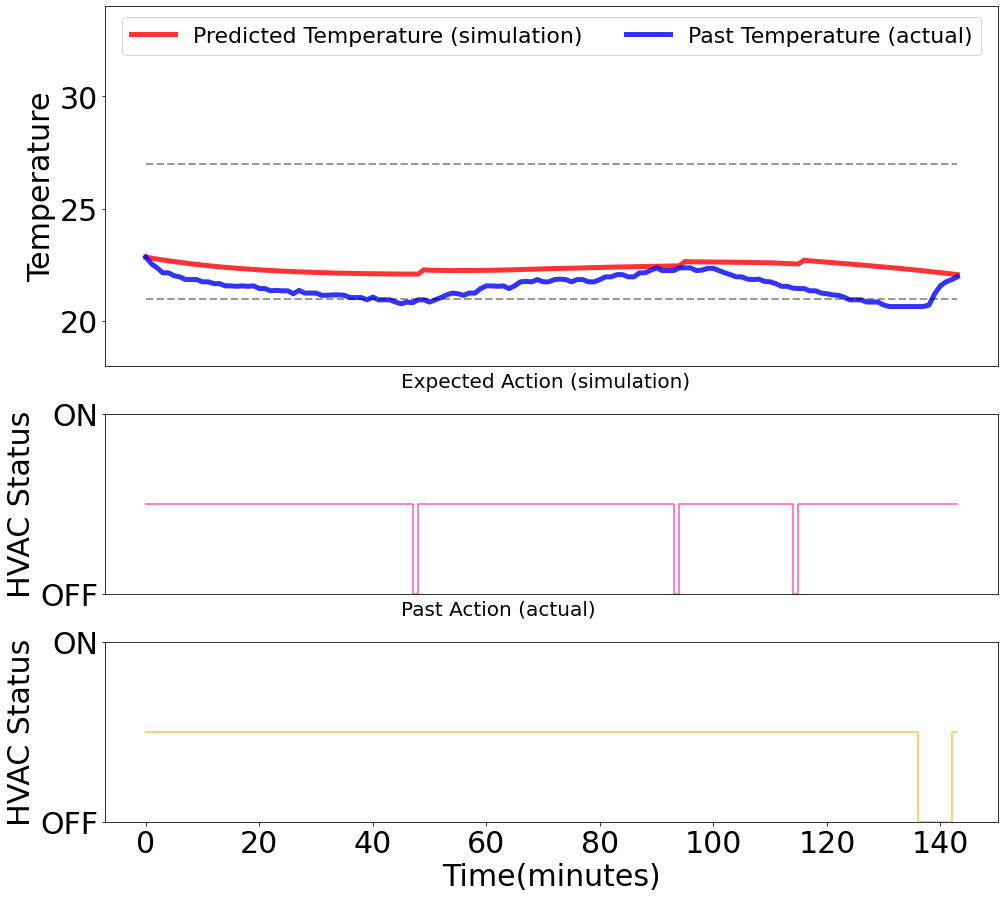

138.0
141
1 일 평균 절감율 :  -2.1739130434782608 실제 평균 온도 :  21.53027777777776 학습 평균 온도 :  22.38238497561737 오차율 :  -0.8521071978396115
/raid/deallab/ecm/model_result/2019-10-06/20191006w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.67
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
2019-10-06 실제 데이터 길이 :  144  : real action :  138.0 , expected action :  142 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  18.485492265457864


<Figure size 432x288 with 0 Axes>

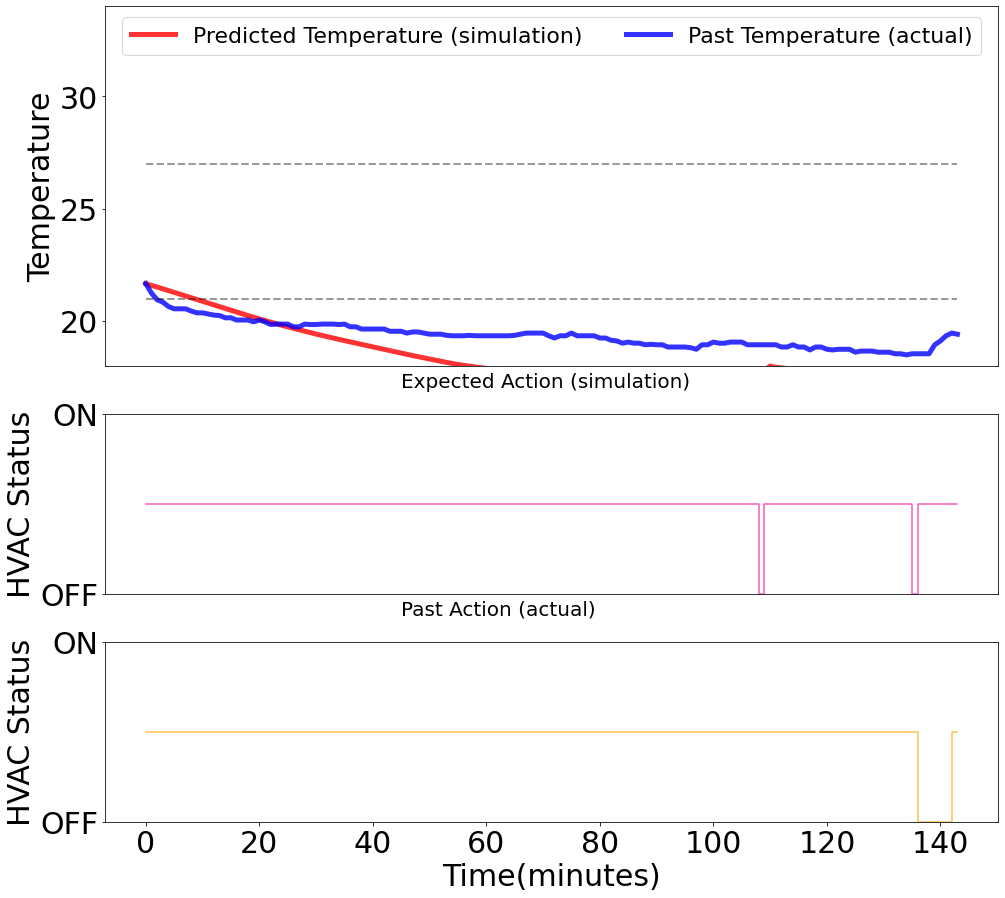

138.0
142
1 일 평균 절감율 :  -2.898550724637681 실제 평균 온도 :  19.38729166666664 학습 평균 온도 :  18.485492265457864 오차율 :  0.9017994012087769
/raid/deallab/ecm/model_result/2019-10-07/20191007w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 19.25
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-07 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  144 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.404442479258325


<Figure size 432x288 with 0 Axes>

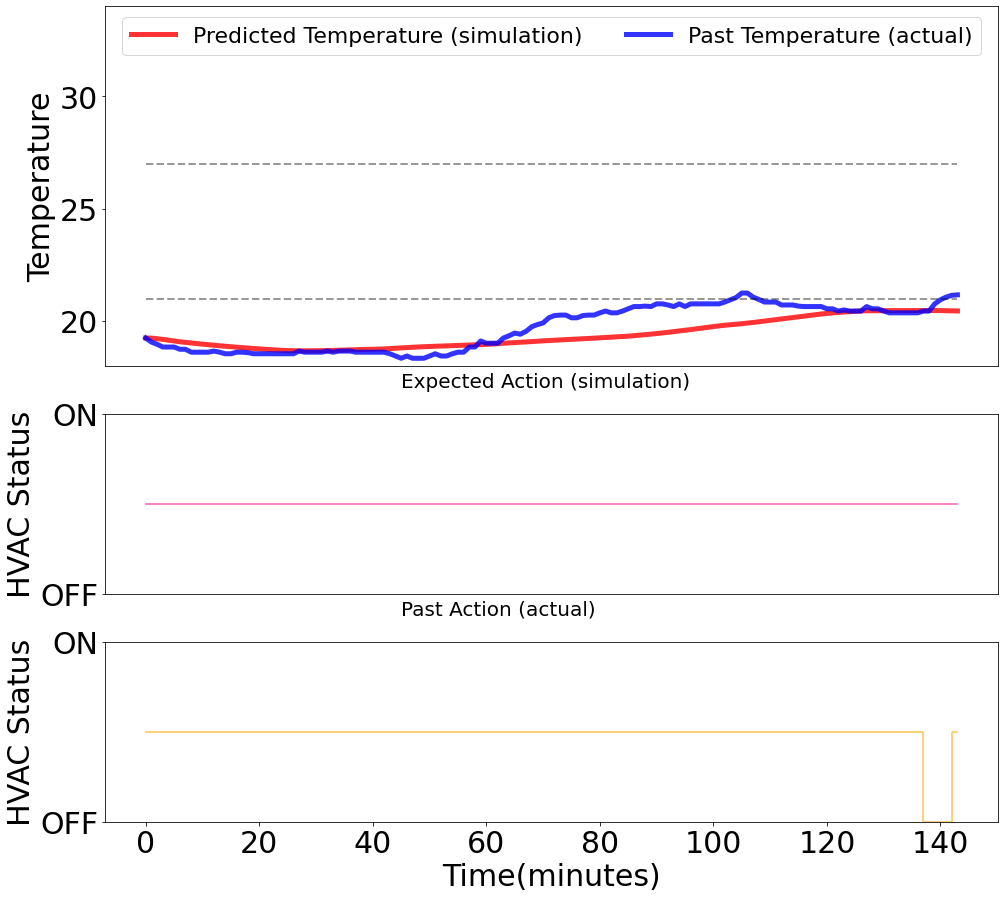

139.0
144
1 일 평균 절감율 :  -3.597122302158273 실제 평균 온도 :  19.7011111111111 학습 평균 온도 :  19.404442479258325 오차율 :  0.2966686318527749
/raid/deallab/ecm/model_result/2019-10-08/20191008w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.85
[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-08 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  113 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  20.785749916283812


<Figure size 432x288 with 0 Axes>

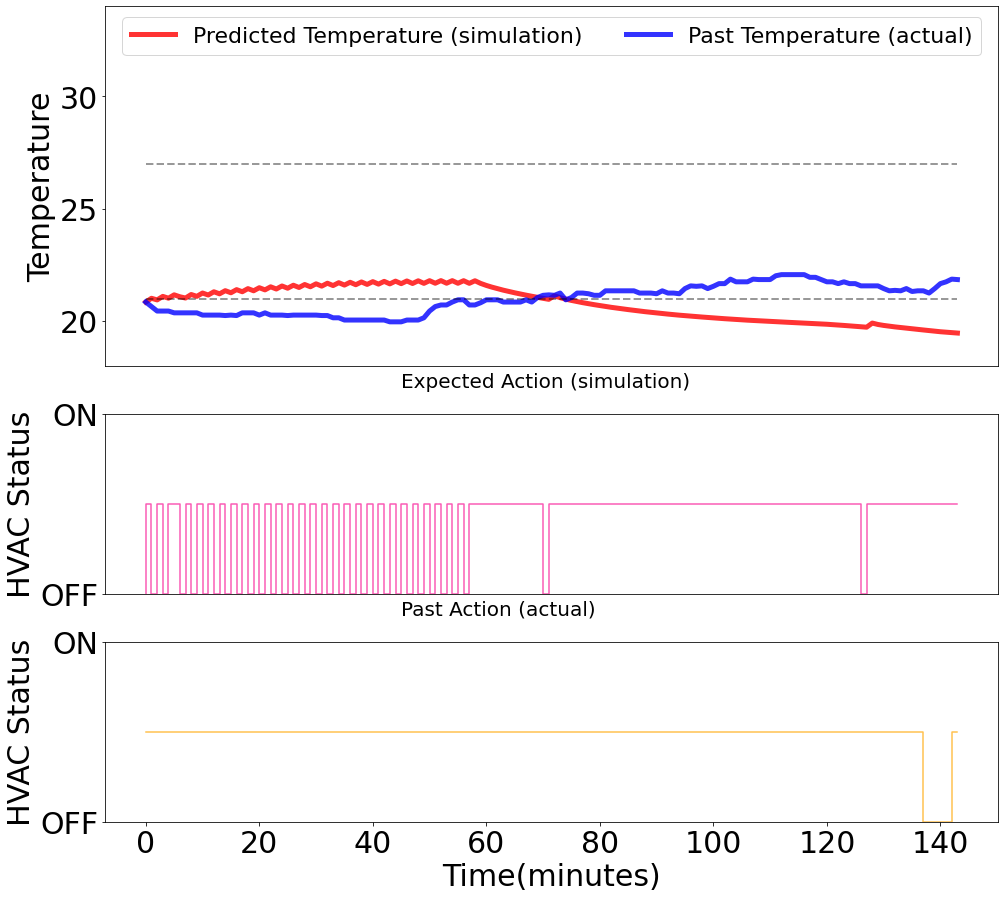

139.0
113
1 일 평균 절감율 :  18.705035971223023 실제 평균 온도 :  20.987222222222215 학습 평균 온도 :  20.785749916283812 오차율 :  0.20147230593840249
/raid/deallab/ecm/model_result/2019-10-09/20191009w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.55
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-09 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  144 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  18.62159823787275


<Figure size 432x288 with 0 Axes>

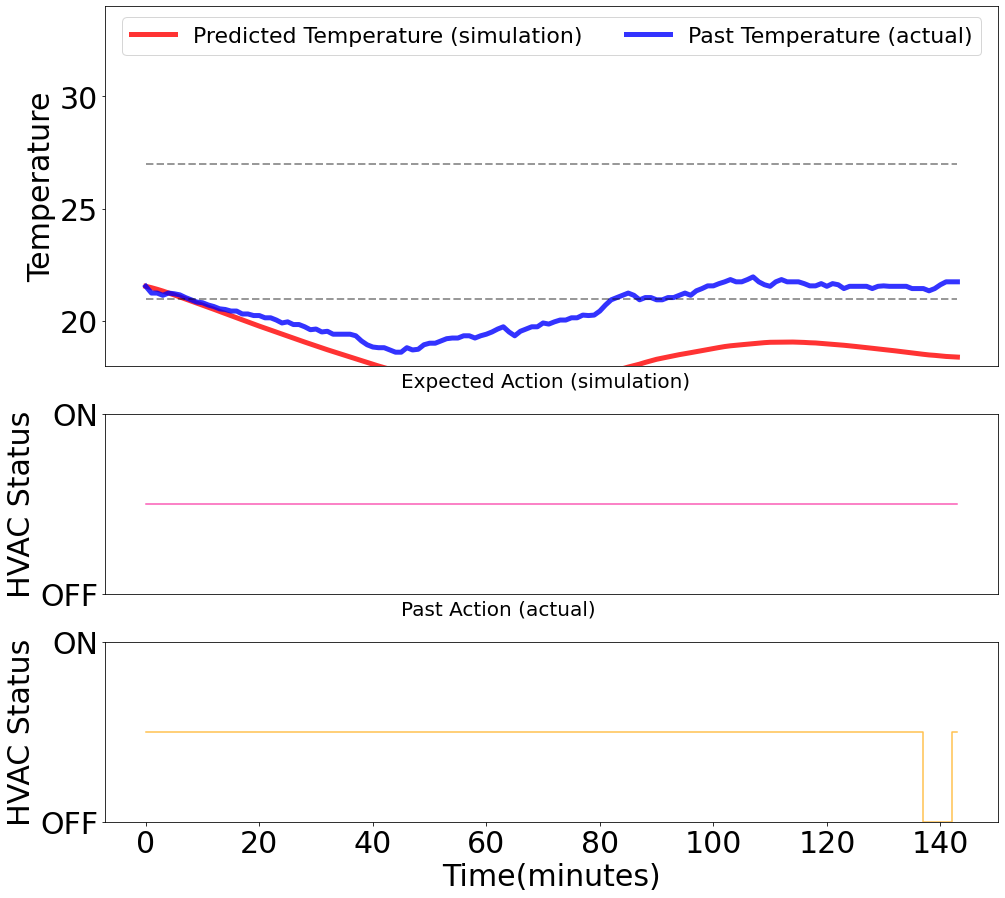

139.0
144
1 일 평균 절감율 :  -3.597122302158273 실제 평균 온도 :  20.557152777777784 학습 평균 온도 :  18.62159823787275 오차율 :  1.9355545399050342
/raid/deallab/ecm/model_result/2019-10-10/20191010w14_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.32
[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-10 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  11 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  24.91340964004203


<Figure size 432x288 with 0 Axes>

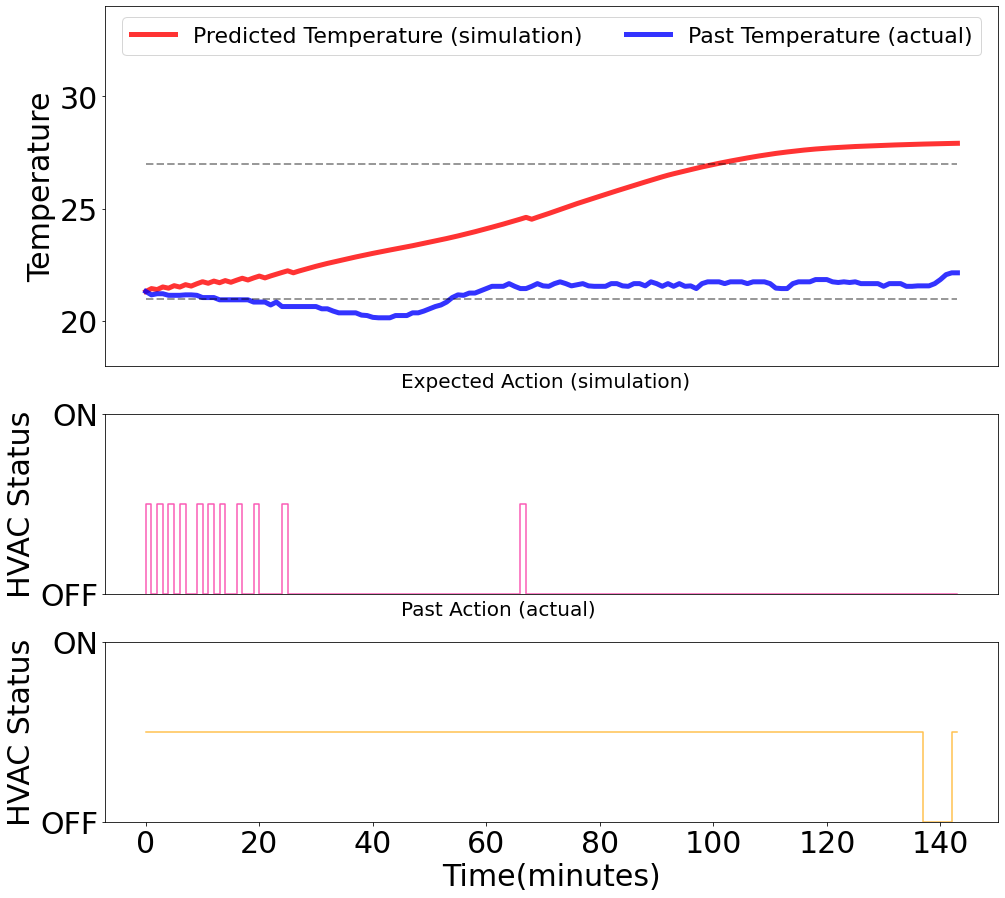

139.0
11
1 일 평균 절감율 :  92.08633093525181 실제 평균 온도 :  21.28416666666667 학습 평균 온도 :  24.91340964004203 오차율 :  -3.6292429733753586
/raid/deallab/ecm/model_result/2019-10-11/20191011w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.85
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
2019-10-11 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  66 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  22.772174366675298


<Figure size 432x288 with 0 Axes>

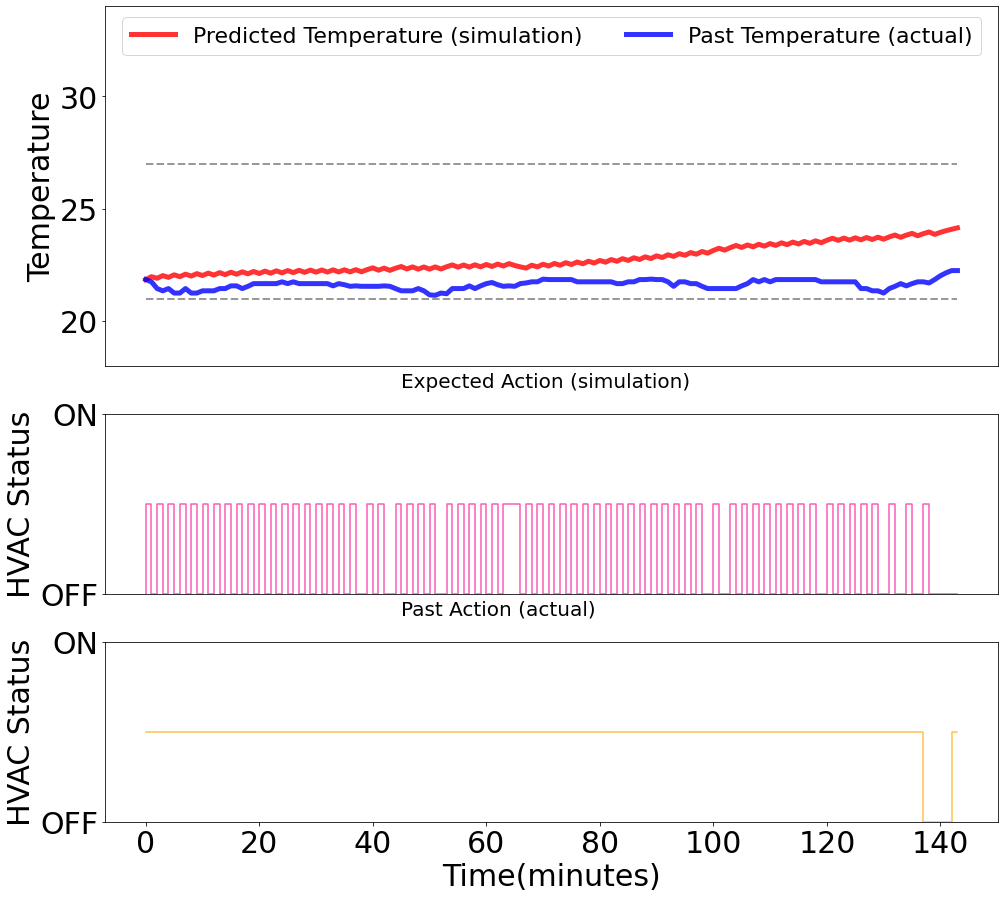

139.0
66
1 일 평균 절감율 :  52.51798561151079 실제 평균 온도 :  21.629513888888866 학습 평균 온도 :  22.772174366675298 오차율 :  -1.142660477786432
/raid/deallab/ecm/model_result/2019-10-12/20191012w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 22.07
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
2019-10-12 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  76 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  23.140724270738485


<Figure size 432x288 with 0 Axes>

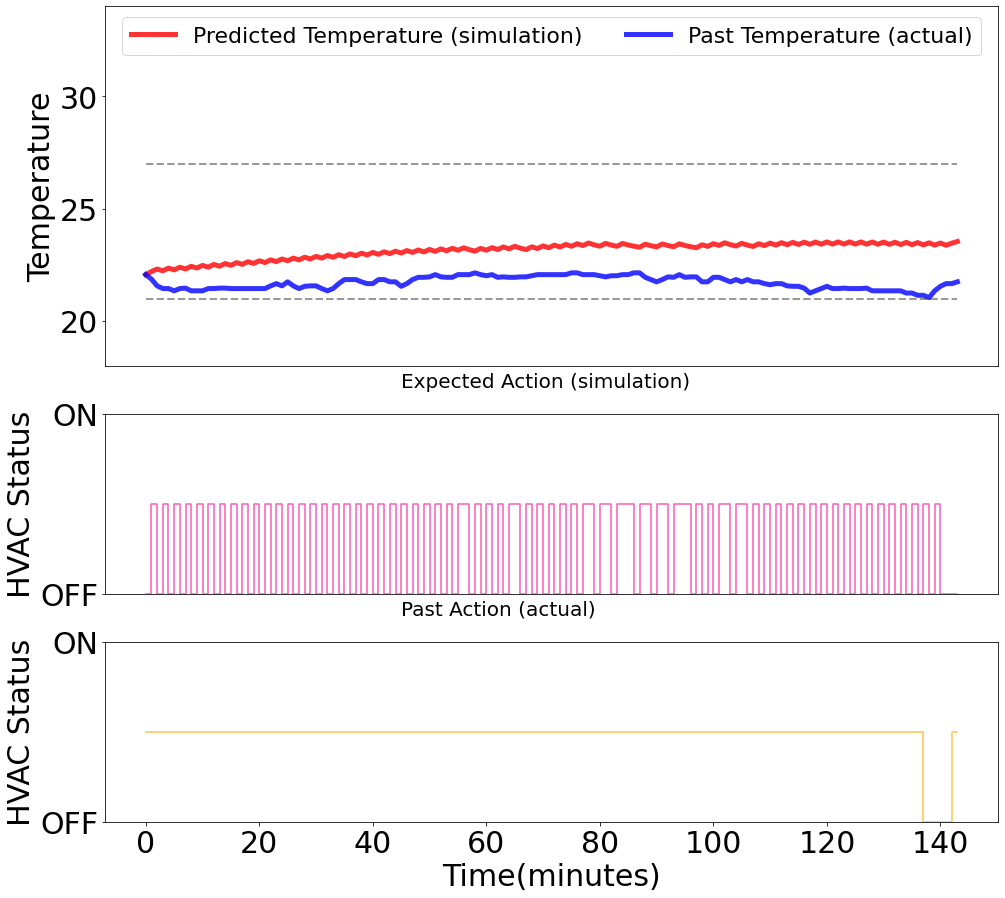

139.0
76
1 일 평균 절감율 :  45.32374100719424 실제 평균 온도 :  21.715694444444427 학습 평균 온도 :  23.140724270738485 오차율 :  -1.4250298262940575
/raid/deallab/ecm/model_result/2019-10-13/20191013w30_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 21.45
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2019-10-13 실제 데이터 길이 :  144  : real action :  139.0 , expected action :  23 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  23.706401932987525


<Figure size 432x288 with 0 Axes>

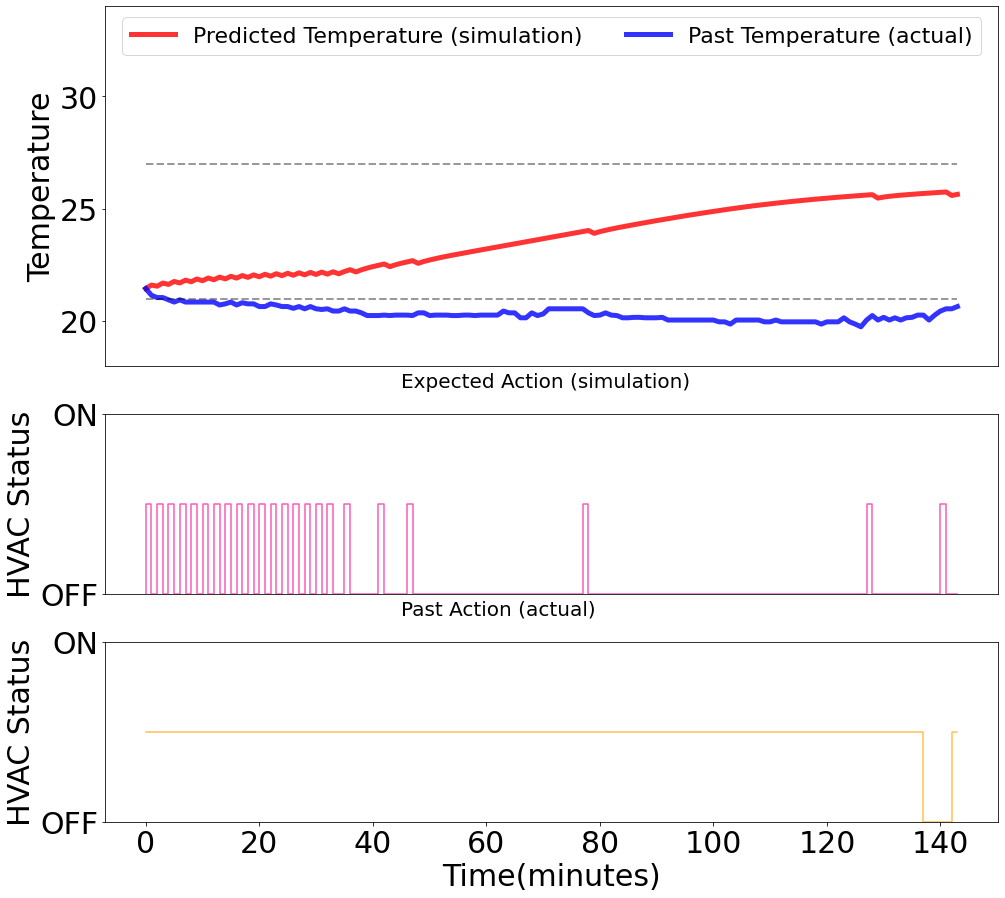

139.0
23
1 일 평균 절감율 :  83.45323741007195 실제 평균 온도 :  20.33749999999999 학습 평균 온도 :  23.706401932987525 오차율 :  -3.3689019329875336
/raid/deallab/ecm/model_result/2019-10-14/20191014w7_linear_regression.joblib
F_SET_MODE_5
Reset data f3_temp : 20.37
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
2019-10-14 실제 데이터 길이 :  144  : real action :  68.0 , expected action :  118 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  20.50593412647209


<Figure size 432x288 with 0 Axes>

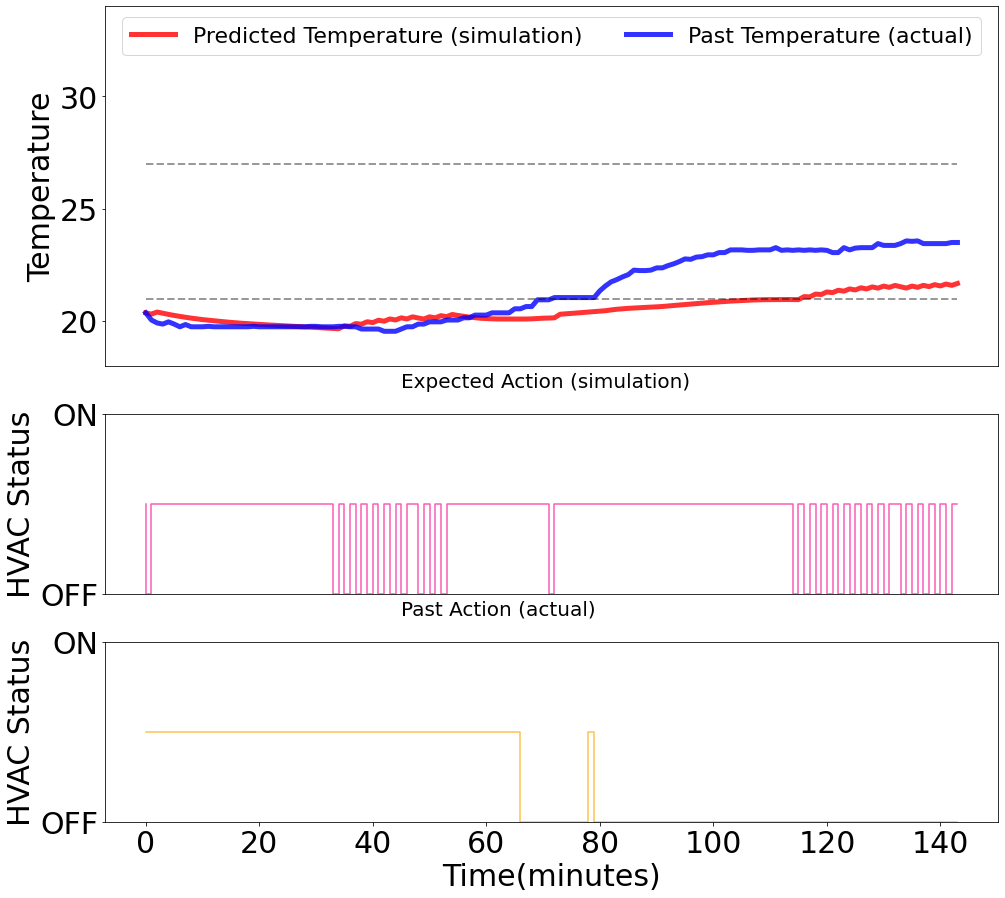

68.0
118
1 일 평균 절감율 :  -73.52941176470588 실제 평균 온도 :  21.350902777777772 학습 평균 온도 :  20.50593412647209 오차율 :  0.8449686513056811
/raid/deallab/ecm/model_result/2019-10-15/20191015w14_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.45
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-15 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  143 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.79658157916692


<Figure size 432x288 with 0 Axes>

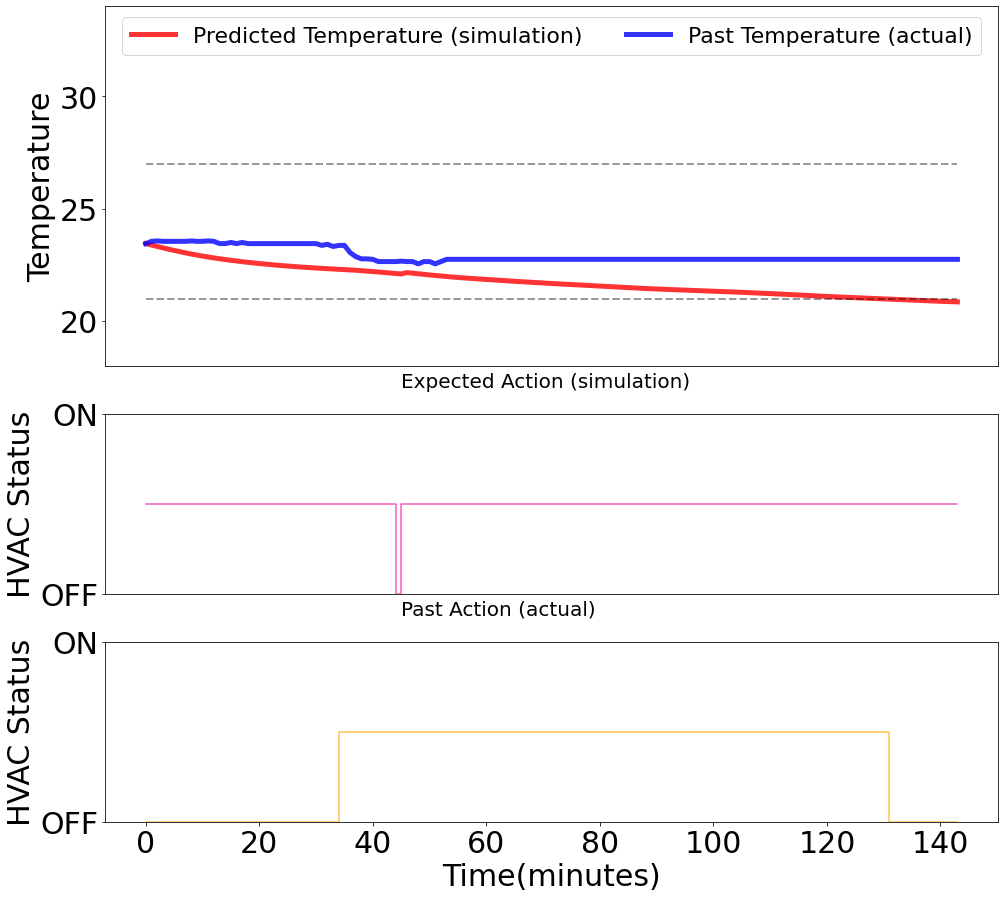

97.0
143
1 일 평균 절감율 :  -47.42268041237113 실제 평균 온도 :  22.925277777777783 학습 평균 온도 :  21.79658157916692 오차율 :  1.1286961986108643
/raid/deallab/ecm/model_result/2019-10-16/20191016w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 22.75
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2019-10-16 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  142 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.403638803441126


<Figure size 432x288 with 0 Axes>

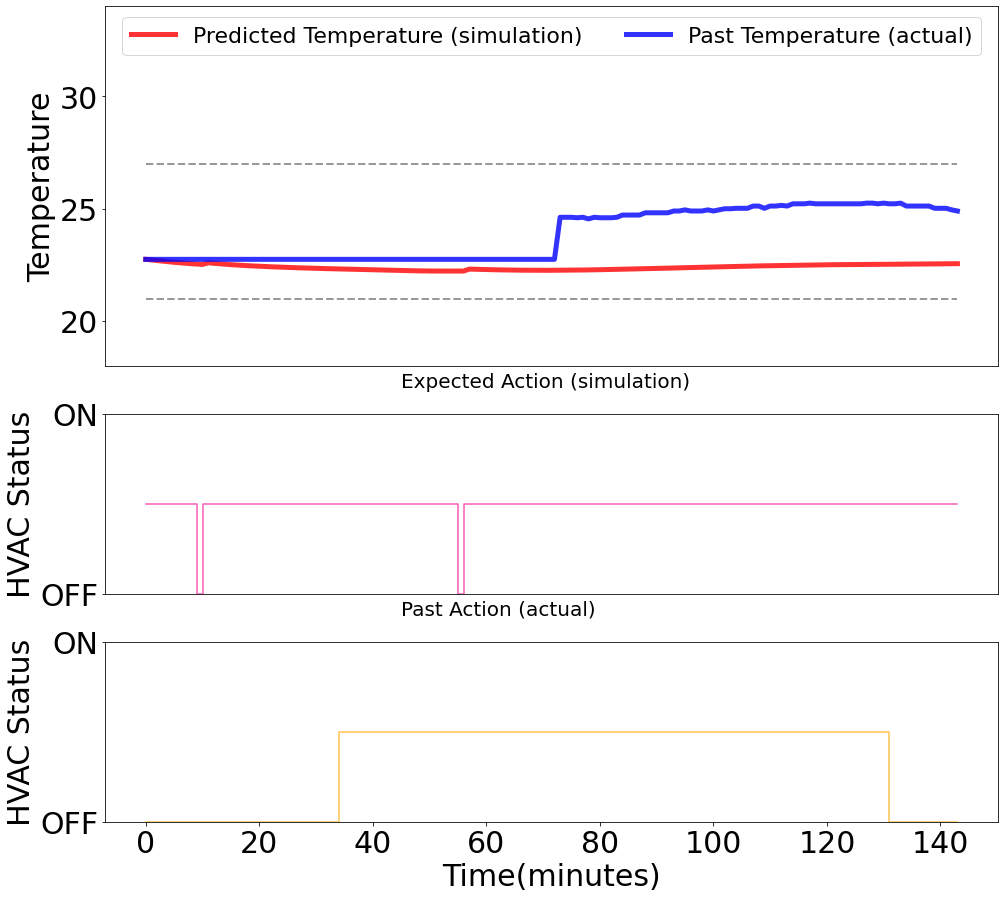

97.0
142
1 일 평균 절감율 :  -46.391752577319586 실제 평균 온도 :  23.85097222222219 학습 평균 온도 :  22.403638803441126 오차율 :  1.4473334187810636
/raid/deallab/ecm/model_result/2019-10-17/20191017w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.95
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
2019-10-17 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  107 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.265762223838948


<Figure size 432x288 with 0 Axes>

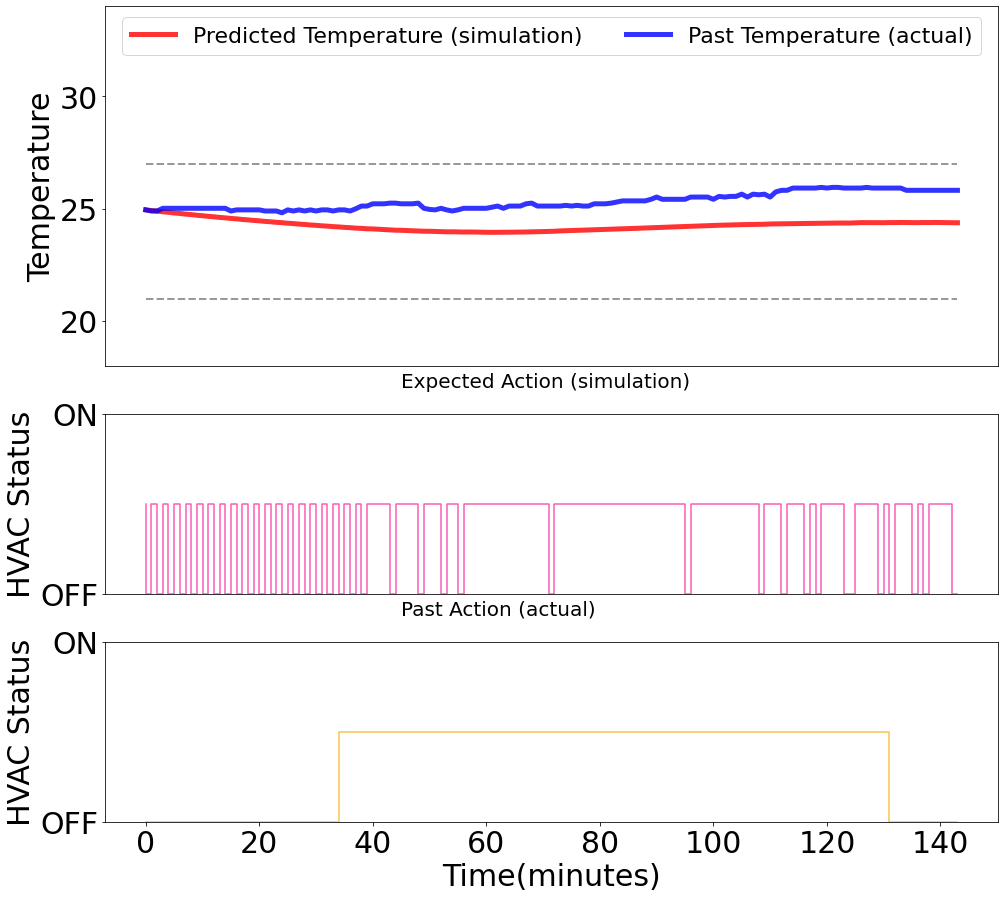

97.0
107
1 일 평균 절감율 :  -10.309278350515463 실제 평균 온도 :  25.320625000000017 학습 평균 온도 :  24.265762223838948 오차율 :  1.0548627761610696
/raid/deallab/ecm/model_result/2019-10-18/20191018w30_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 25.82
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2019-10-18 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  28 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.577433287614635


<Figure size 432x288 with 0 Axes>

97.0
28
1 일 평균 절감율 :  71.1340206185567 실제 평균 온도 :  25.29326388888887 학습 평균 온도 :  25.577433287614635 오차율 :  -0.28416939872576563
/raid/deallab/ecm/model_result/2019-10-19/20191019w7_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 24.35
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-19 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  16 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.175289606011198


<Figure size 432x288 with 0 Axes>

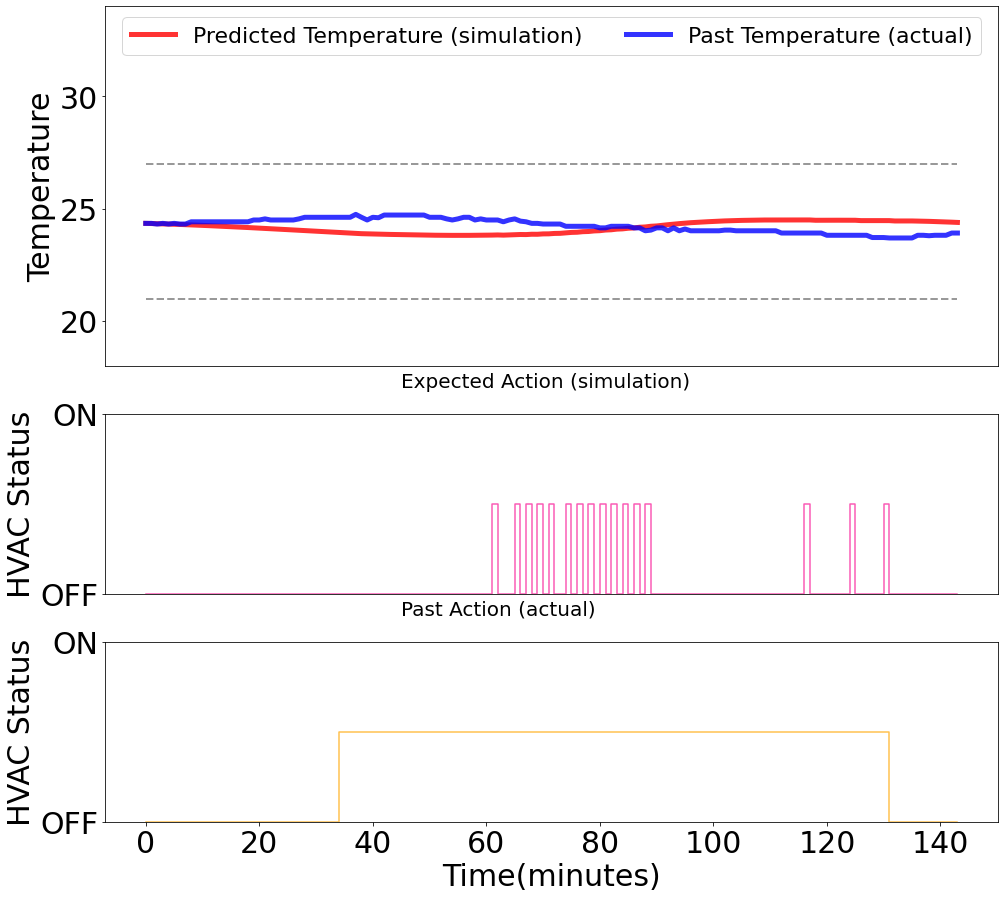

97.0
16
1 일 평균 절감율 :  83.50515463917526 실제 평균 온도 :  24.250416666666677 학습 평균 온도 :  24.175289606011198 오차율 :  0.07512706065547903
/raid/deallab/ecm/model_result/2019-10-20/20191020w1_linear_regression.joblib
F_SET_MODE_3
Reset data f3_temp : 23.92
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-20 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  35 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.63282652435879


<Figure size 432x288 with 0 Axes>

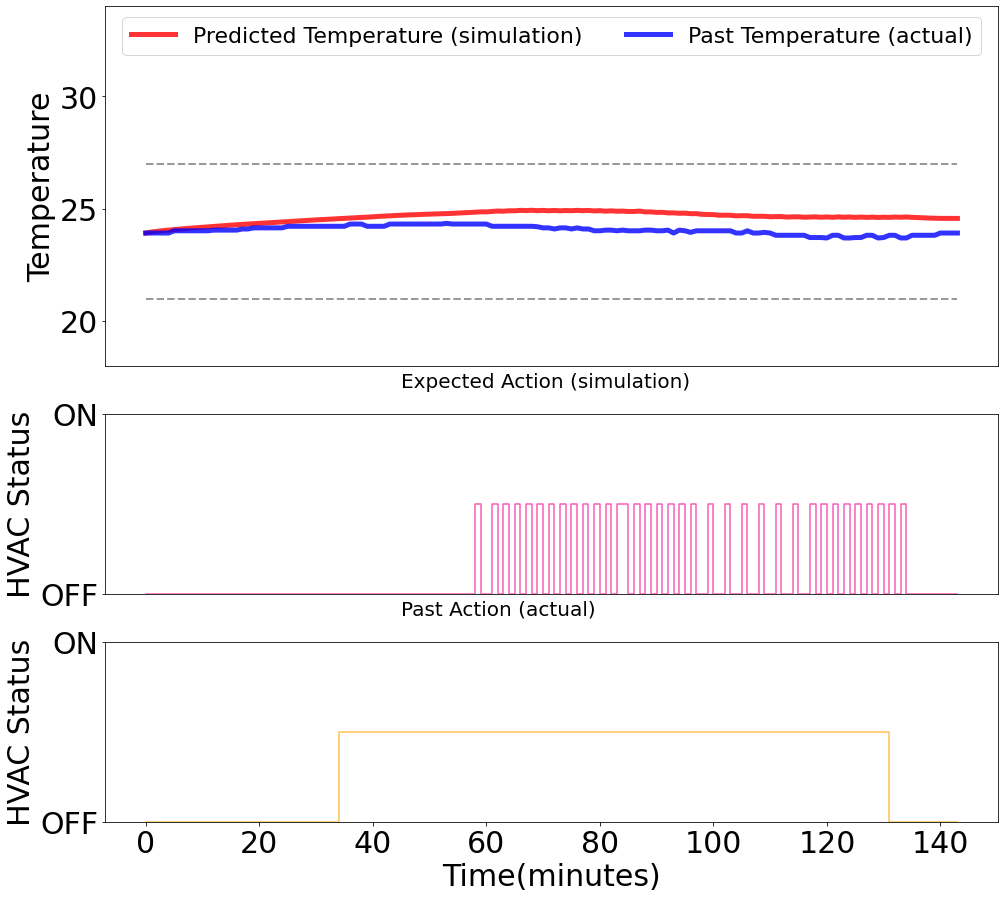

97.0
35
1 일 평균 절감율 :  63.91752577319587 실제 평균 온도 :  24.05208333333334 학습 평균 온도 :  24.63282652435879 오차율 :  -0.5807431910254515
/raid/deallab/ecm/model_result/2019-10-21/20191021w14_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.92
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-21 실제 데이터 길이 :  144  : real action :  53.0 , expected action :  91 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  23.827096392991997


<Figure size 432x288 with 0 Axes>

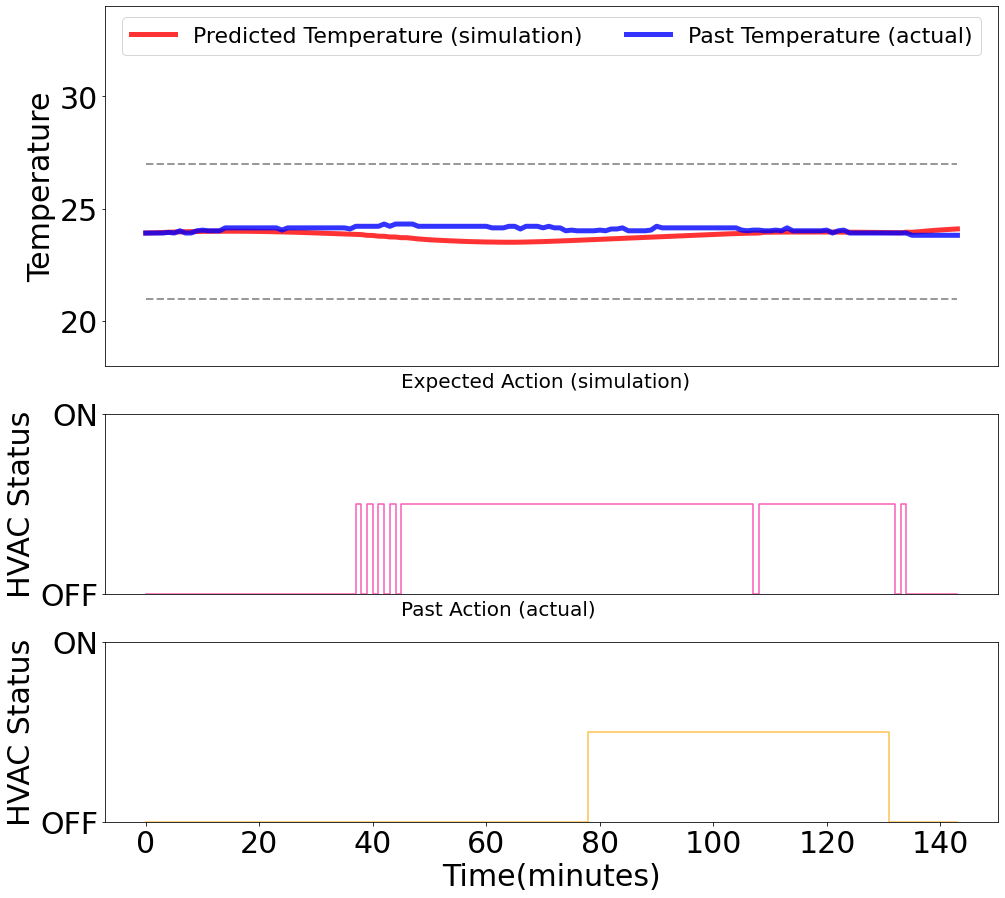

53.0
91
1 일 평균 절감율 :  -71.69811320754717 실제 평균 온도 :  24.083680555555585 학습 평균 온도 :  23.827096392991997 오차율 :  0.2565841625635876
/raid/deallab/ecm/model_result/2019-10-22/20191022w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.82
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-22 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  51 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.800631221809006


<Figure size 432x288 with 0 Axes>

97.0
51
1 일 평균 절감율 :  47.42268041237113 실제 평균 온도 :  23.582847222222213 학습 평균 온도 :  23.800631221809006 오차율 :  -0.21778399958679273
/raid/deallab/ecm/model_result/2019-10-23/20191023w30_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-23 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  49 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.24627084118036


<Figure size 432x288 with 0 Axes>

97.0
49
1 일 평균 절감율 :  49.48453608247423 실제 평균 온도 :  23.762013888888905 학습 평균 온도 :  24.24627084118036 오차율 :  -0.48425695229145305
/raid/deallab/ecm/model_result/2019-10-24/20191024w7_linear_regression.joblib
F_SET_MODE_4
Reset data f3_temp : 23.72
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2019-10-24 실제 데이터 길이 :  144  : real action :  97.0 , expected action :  29 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.423799671215573


<Figure size 432x288 with 0 Axes>

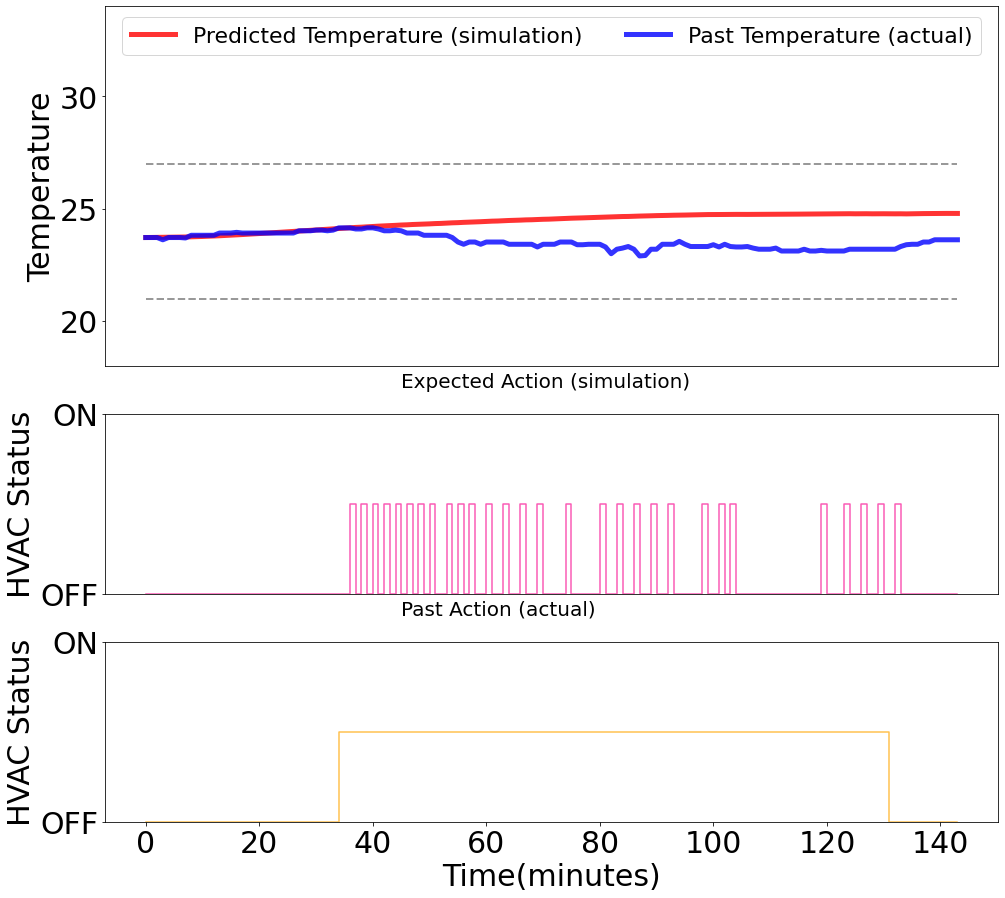

97.0
29
1 일 평균 절감율 :  70.10309278350515 실제 평균 온도 :  23.554791666666656 학습 평균 온도 :  24.423799671215573 오차율 :  -0.8690080045489168


In [43]:
Train_date =  datetime.date(2019,8,23)
#start_date = datetime.date(2019, 8,23)
end_date = datetime.date(2019,10,24)
daterange = pd.date_range(Train_date, end_date)

checkpoint_path = '/raid/deallab/yechae/ECM/2023/result/2019-10-24/RL_ECM_DQN-lin-6-pre-basic-7_2023-02-02_00-43-22wiao_vyi/checkpoint_006100/checkpoint-6100'
print(checkpoint_path)

max_action = getMaxAction(df_test_pre)
path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
method_name = "Env_ML"
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action, 'init_data' : df_test_pre}


env = ECM_Env_ML(env_config)
select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

# print(path)
    
save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN-lin-6-result-7'))
    
trainer_dqn.restore(checkpoint_path)
result_final_df = pd.DataFrame()


for single_date in daterange:
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date)
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.window_size.values[0]
    model_name = cur_model.model.values[0]
    
    if Train_date == datetime.date(2019,10,3) or Train_date == datetime.date(2019,10,4):  # 결측 데이터 처리 
        df_test_pre = df_test_pre.interpolate(method='linear', limit_direction='forward')
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     one_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w1_linear_regression.joblib'
#     seven_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w7_linear_regression.joblib'
#     fourtenn_day_path =  f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w14_linear_regression.joblib'
#     model_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w21_linear_regression.joblib'


#     if Train_date <= datetime.date(2019,8,28):
#         path = one_day_path
#     elif Train_date <= datetime.date(2019,9,4):
#         path = seven_day_path
#     elif Train_date <= datetime.date(2019, 9,11):
#         path = fourtenn_day_path
#     else:
#         path = model_path
    path = f'/raid/deallab/ecm/model_result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_linear_regression.joblib'
    print(path)
    
    max_action = getMaxAction(df_test_pre)    
    
    real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path, max_action, trainer_dqn)
    new_df = pd.DataFrame()
    new_df.index = real_df.index
    new_df['real_temp'] = real_df['temp']
    new_df['real_hum'] = real_df['hum']
    new_df['real_action'] = real_df['action']
    new_df['RL_temp'] = next_df['f3_temp']
    new_df['RL_hum'] = next_df['f3_hum']
    new_df['RL_action'] = actions
    
    # path 변경하기 
    new_df_path = f'/raid/deallab/yechae/ECM/2023/result/FinalResult2/{Train_date.strftime("%Y-%m-%d")}-DQN.csv'
    new_df.to_csv(new_df_path)
    result_final_df = result_df.append(result_final_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
result_df_path = f'/raid/deallab/yechae/ECM/2023/result/FinalResult2/DQN_final_result.csv'
result_final_df.to_csv(result_df_path)

    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [42]:
result_final_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-08-25  26.732014   
0  NaN         NaN          NaN             NaN  2019-08-24  26.305000   
0  NaN         NaN          NaN             NaN  2019-08-23  24.707986   

           2           3  
0  27.334233   99.280576  
0  24.243274  100.000000  
0  25.616542   98.561151

(scheduler +41m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [40]:
result_df

date actual_temp predict_temp power_reduction           0          1  \
0  NaN         NaN          NaN             NaN  2019-10-01  24.186944   

           2          3  
0  24.273519  99.275362

(scheduler +35m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +36m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [ ]:
# Train_date = Train_date = datetime.date(2019,9,21)
# checkpoint_path = checkpoint
# print(checkpoint_path)

# print(Train_date)
# cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
# df_test_pre = makeData(df_train, Train_date )
# date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
# Train_window_size = cur_model.TimeWindows.values[0]
# model_name = cur_model.Model.values[0]

# #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
# path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
# max_action = getMaxAction(df_test_pre)
# method_name = "Env_ML"
# env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}

# env = ECM_Env_ML(env_config)
# select_env = "ECMEnv2023-v0"
# register_env(select_env, lambda config: ECM_Env_ML(env_config))
# print(path)

# save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
# trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

# trainer_dqn.restore(checkpoint_path)

In [ ]:
Train_date = Train_date = datetime.date(2019,9,21)
checkpoint_path = checkpoint
print(checkpoint_path)

for i in range(52):
    print(Train_date)
    cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
    df_test_pre = makeData(df_train, Train_date )
    date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
    Train_window_size = cur_model.TimeWindows.values[0]
    model_name = cur_model.Model.values[0]
    
    #dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
    path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
    max_action = getMaxAction(df_test_pre)
    method_name = "Env_ML"
    env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    


    env = ECM_Env_ML(env_config)
    select_env = "ECMEnv2023-v0"
    register_env(select_env, lambda config: ECM_Env_ML(env_config))

    print(path)
    
    save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
    trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
    trainer_dqn.restore(checkpoint_path)
    
    
    s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
    train_dqn_episode = 100
    reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
    # === Train === 
    start = time.time()
    start_after_for = time.time()
    print(train_dqn_episode)
    for i in range(train_dqn_episode):
        print("start_after_for : ", time.time() - start_after_for )
        start_episode = time.time()
        result = trainer_dqn.train()
        print(s.format(
            i + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"]
           ))
        reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
        if i % 100 == 0:
            checkpoint = trainer_dqn.save()
            print("checkpoint saved at", checkpoint)
        print("Elapsed time one episode : ", time.time() - start_episode)
        start_after_for = time.time()
    print("Elapsed time : ", time.time() - start)
    checkpoint_path = trainer_dqn.save()

    print("checkpoint saved at", checkpoint)
    
    
    #real_df, next_df, actions, result_df = result_base_RL([df_test_pre], Train_date, path)
    #new_df = pd.DataFrame()
    #new_df.index = real_df.index
    #new_df['real_temp'] = real_df['temp']
    #new_df['real_hum'] = real_df['hum']
    #new_df['real_action'] = real_df['action']
    #new_df['RL_temp'] = next_df['f3_temp']
    #new_df['RL_hum'] = next_df['f3_hum']
    #new_df['RL_action'] = actions
    
    #new_df_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y-%m-%d")}-DQN-pre.csv'
    #new_df.to_csv(new_df_path)
    #result_df = result_df.append(result_df)
    
    Train_date = Train_date+datetime.timedelta(days=1)
    
#result_df_path = f'/raid/deallab/yechae/ECM/2023/result/DQN_final-pre.csv'
#result_df.to_csv(result_df_path)

#Train_date = Train_date+datetime.timedelta(days=1)
    # ENV 세팅
    #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    #env = ECM_Env_DL(env_config)
    
    #select_env = "ECMEnv2023-v0"
    #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [ ]:
# Train_date = Train_date+datetime.timedelta(days=1)
# checkpoint_path = checkpoint

# for i in range(54):
#     print(Train_date)
#     cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
#     df_test_pre = makeData(df_train, Train_date )
#     date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
#     Train_window_size = cur_model.TimeWindows.values[0]
#     model_name = cur_model.Model.values[0]
    
#     dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
#     ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
#     max_action = getMaxAction(df_test_pre)
#     env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
    
#     if model_name in ml_models:
#         path = ml_path
#         print("ML : ", model_name)
#         #model = joblib.load(path)
#         method_name = "Env_ML"
#         env = ECM_Env_ML(env_config)
#         select_env = "ECMEnv2023-v0"
#         register_env(select_env, lambda config: ECM_Env_ML(env_config))
#     else:
#         path = dl_path
#         print("DL : ", model_name)
#         Train_date = Train_date+datetime.timedelta(days=1)
#         continue;
#         #model = tf.keras.models.load_model(dl_path)
#         #method_name = "Env_DL"
#         #env = ECM_Env_DL(env_config)
#         #select_env = "ECMEnv2023-v0"
#         #register_env(select_env, lambda config: ECM_Env_DL(env_config))
#     print(path)
    
#     save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
#     trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))
    
#     trainer_dqn.restore(checkpoint_path)
    
    
#     s = "{:3d} reward min : {:6.2f}/ mean : {:6.2f}/ max : {:6.2f}/ len {:6.2f}"
#     train_dqn_episode = 500
#     reward_dqn_list = pd.DataFrame(columns = ['mean'])
    
#     # === Train === 
#     start = time.time()
#     start_after_for = time.time()
#     print(train_dqn_episode)
#     for i in range(train_dqn_episode):
#         print("start_after_for : ", time.time() - start_after_for )
#         start_episode = time.time()
#         result = trainer_dqn.train()
#         print(s.format(
#             i + 1,
#             result["episode_reward_min"],
#             result["episode_reward_mean"],
#             result["episode_reward_max"],
#             result["episode_len_mean"]
#            ))
#         reward_dqn_list = reward_dqn_list.append({'mean': result["episode_reward_mean"]}, ignore_index=True)
#         if i % 500 == 0:
#             checkpoint = trainer_dqn.save()
#             print("checkpoint saved at", checkpoint)
#         print("Elapsed time one episode : ", time.time() - start_episode)
#         start_after_for = time.time()
#     print("Elapsed time : ", time.time() - start)
#     checkpoint_path = trainer_dqn.save()

#     print("checkpoint saved at", checkpoint)
#     Train_date = Train_date+datetime.timedelta(days=1)


# #Train_date = Train_date+datetime.timedelta(days=1)
#     # ENV 세팅
#     #env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
#     #env = ECM_Env_DL(env_config)
    
#     #select_env = "ECMEnv2023-v0"
#     #register_env(select_env, lambda config: ECM_Env_DL(env_config))
        

In [39]:
Train_date = datetime.date(2019,9,21)
# init 
cur_model = best_forecastmodel[(pd.to_datetime(best_forecastmodel.index).date) == Train_date]
df_test_pre = makeData(df_train, Train_date )
date = datetime.datetime.strptime(cur_model.index.values[0], '%Y-%m-%d')
Train_window_size = cur_model.TimeWindows.values[0]
model_name = cur_model.Model.values[0]

dl_path = f'/raid/deallab/ecm/model_result_no_window_dl/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.h5'
ml_path = f'/raid/deallab/ecm/model_result_no_window/{Train_date.strftime("%Y-%m-%d")}/{Train_date.strftime("%Y%m%d")}w{Train_window_size}_{model_name}.joblib'
if model_name in ml_models:
    path = ml_path
    print("ML : ", model_name)
    #model = joblib.load(path)
    method_name = "Env_ML"
else:
    path = dl_path
    print("DL : ", model_name)
    #model = tf.keras.models.load_model(dl_path)
    method_name = "Env_DL"
print(path)
max_action = getMaxAction(df_test_pre)

# ENV 세팅
env_config = {'max_temp': 27, 'min_temp' : 21, 'method_name': method_name, 'model' : path, 'max_action' : max_action}
env = ECM_Env_ML(env_config)

select_env = "ECMEnv2023-v0"
register_env(select_env, lambda config: ECM_Env_ML(env_config))

config_dqn = agents.dqn.DEFAULT_CONFIG.copy()
config_dqn["log_level"] = "WARN"
config_dqn["env"] = select_env
config_dqn["env_config"] = env_config
config_dqn["evaluation_num_workers"] = 1
config_dqn["train_batch_size"] = 256
# config_dqn["model.fcnet_activation"] = 'relu'
config_dqn["target_network_update_freq"] = 50
config_dqn["learning_starts"] = 800
config_dqn["timesteps_per_iteration"] = 144
config_dqn["num_gpus_per_worker"] = 1
config_dqn["model"]["custom_model"] = False
#config_dqn["model"]["custom_model"] = "my_model"
config_dqn["model"]["fcnet_hiddens"] = [256,256]
config_dqn["model"]["fcnet_activation"] = "relu"
config_dqn["n_step"] = 144
config_dqn["dueling"] = False
config_dqn["double_q"] = False

save_path = f'/raid/deallab/yechae/ECM/2023/result/{Train_date.strftime("%Y-%m-%d")}/' #./result/agent
print(save_path)
trainer_dqn = agents.dqn.DQNTrainer(config_dqn, env=select_env, logger_creator = custom_log_creator(os.path.expanduser(save_path), 'RL_ECM_DQN'))

2023-01-26 15:02:22,874	INFO trainer.py:2141 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-26 15:02:22,879	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:22,883	INFO simple_q.py:155 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2023-01-26 15:02:22,883	INFO trainer.py:781 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


ML :  extra_trees_regressor
/raid/deallab/ecm/model_result_no_window/2019-09-21/20190921w14_extra_trees_regressor.joblib
Reset data f3_temp : 25.2
/raid/deallab/yechae/ECM/2023/result/2019-09-21/
Reset data f3_temp : 25.2
Reset data f3_temp : 24.6


2023-01-26 15:02:35,609	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2023-01-26 15:02:35,610	WARNING trainer.py:2348 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2023-01-26 15:02:35,868	INFO trainable.py:130 -- Trainable.setup took 12.995 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
